---
title: "Data gathering"
format: 
  html:
    code-fold: true
execute: 
  enabled: true
---

## Introduction:
EDA, or Exploratory Data Analysis, is a crucial phase in the data analysis process that involves summarizing the main characteristics of a dataset, often with the help of statistical graphics and other data visualization methods. The primary goal of EDA is to understand the structure and key features of the data, discover patterns, identify potential outliers, and generate hypotheses for further analysis.


### This part will mainly focus on the following 2 datasets:
1. Tesla Deaths - Deaths
2. UK Road Safety: Traffic Accidents and Vehicles (gas car)

## First dataset: Tesla Deaths - Deaths

### Pre-process the data and take a look at the cleaned data

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
df = pd.read_csv("./Data/Tesla Deaths - Deaths.csv")
new_df = pd.DataFrame()
for i in range(len(df.columns[:14]),1,-1):
    new_df.insert(0,df.columns[i],df[df.columns[i]])
df = new_df
for i in range(5,10):
    df[df.columns[i]] = df[df.columns[i]].fillna("-")
    
for i in range(11,13):
    df[df.columns[i]] = df[df.columns[i]].fillna('-')
df = df.dropna()
df.columns = ['Date','Country','State','Description','Deaths',"Tesla_driver","Tesla_occupant","Other_vehicle","CP","tsla+cp","Model","Claimed","VTAD"]
for i in range(5,13):
    for b in range(len(df)):
        if "-"in df[df.columns[i]].values[b]:
            df[df.columns[i]].values[b] = 0
        elif "1" in df[df.columns[i]].values[b]:
            df[df.columns[i]].values[b] = 1
        elif "2" in df[df.columns[i]].values[b]:
            df[df.columns[i]].values[b] = 2
        elif "3" in df[df.columns[i]].values[b]:
            df[df.columns[i]].values[b] = 3
        elif "4" in df[df.columns[i]].values[b]:
            df[df.columns[i]].values[b] = 4

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\23898\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\23898\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df.head()

Date   Country State                         Description  Deaths  \
0   1/17/2023      USA     CA    Tesla crashes into back of semi      1.0   
1    1/7/2023   Canada      -                      Tesla crashes      1.0   
2    1/7/2023      USA     WA   Tesla hits pole, catches on fire      1.0   
3  12/22/2022      USA     GA            Tesla crashes and burns      1.0   
4  12/19/2022   Canada      -      Tesla crashes into storefront      1.0   

  Tesla_driver Tesla_occupant Other_vehicle CP tsla+cp Model Claimed VTAD  
0            1              0             0  0       1     0       0    0  
1            1              0             0  0       1     0       0    0  
2            0              1             0  0       1     0       0    0  
3            1              0             0  0       1     0       0    0  
4            0              0             0  1       1     0       0    0

## Start EDA 
### The 'Date' variable is not in the default date format

In [3]:
#| warning: false
df.loc[:, "event_year"] = 0
df.loc[:, "event_month"] = 0
df.loc[:, "event_day"] = 0
for i in range(len(df)):
    df.loc[df.index[i], "event_year"] = int(df["Date"].values[i].split('/')[2])
    df.loc[df.index[i], "event_month"] = int(df["Date"].values[i].split('/')[0])
    df.loc[df.index[i], "event_day"] = int(df["Date"].values[i].split('/')[1])
df['Date']

0       1/17/2023
1        1/7/2023
2        1/7/2023
3      12/22/2022
4      12/19/2022
          ...    
289     7/14/2014
290      7/4/2014
291      7/4/2014
292     11/2/2013
293      4/2/2013
Name: Date, Length: 294, dtype: object

### Let's see the distribution of crashes around the world
It seems that USA has the most accidents, then followed by China and Germany.

<BarContainer object of 23 artists>

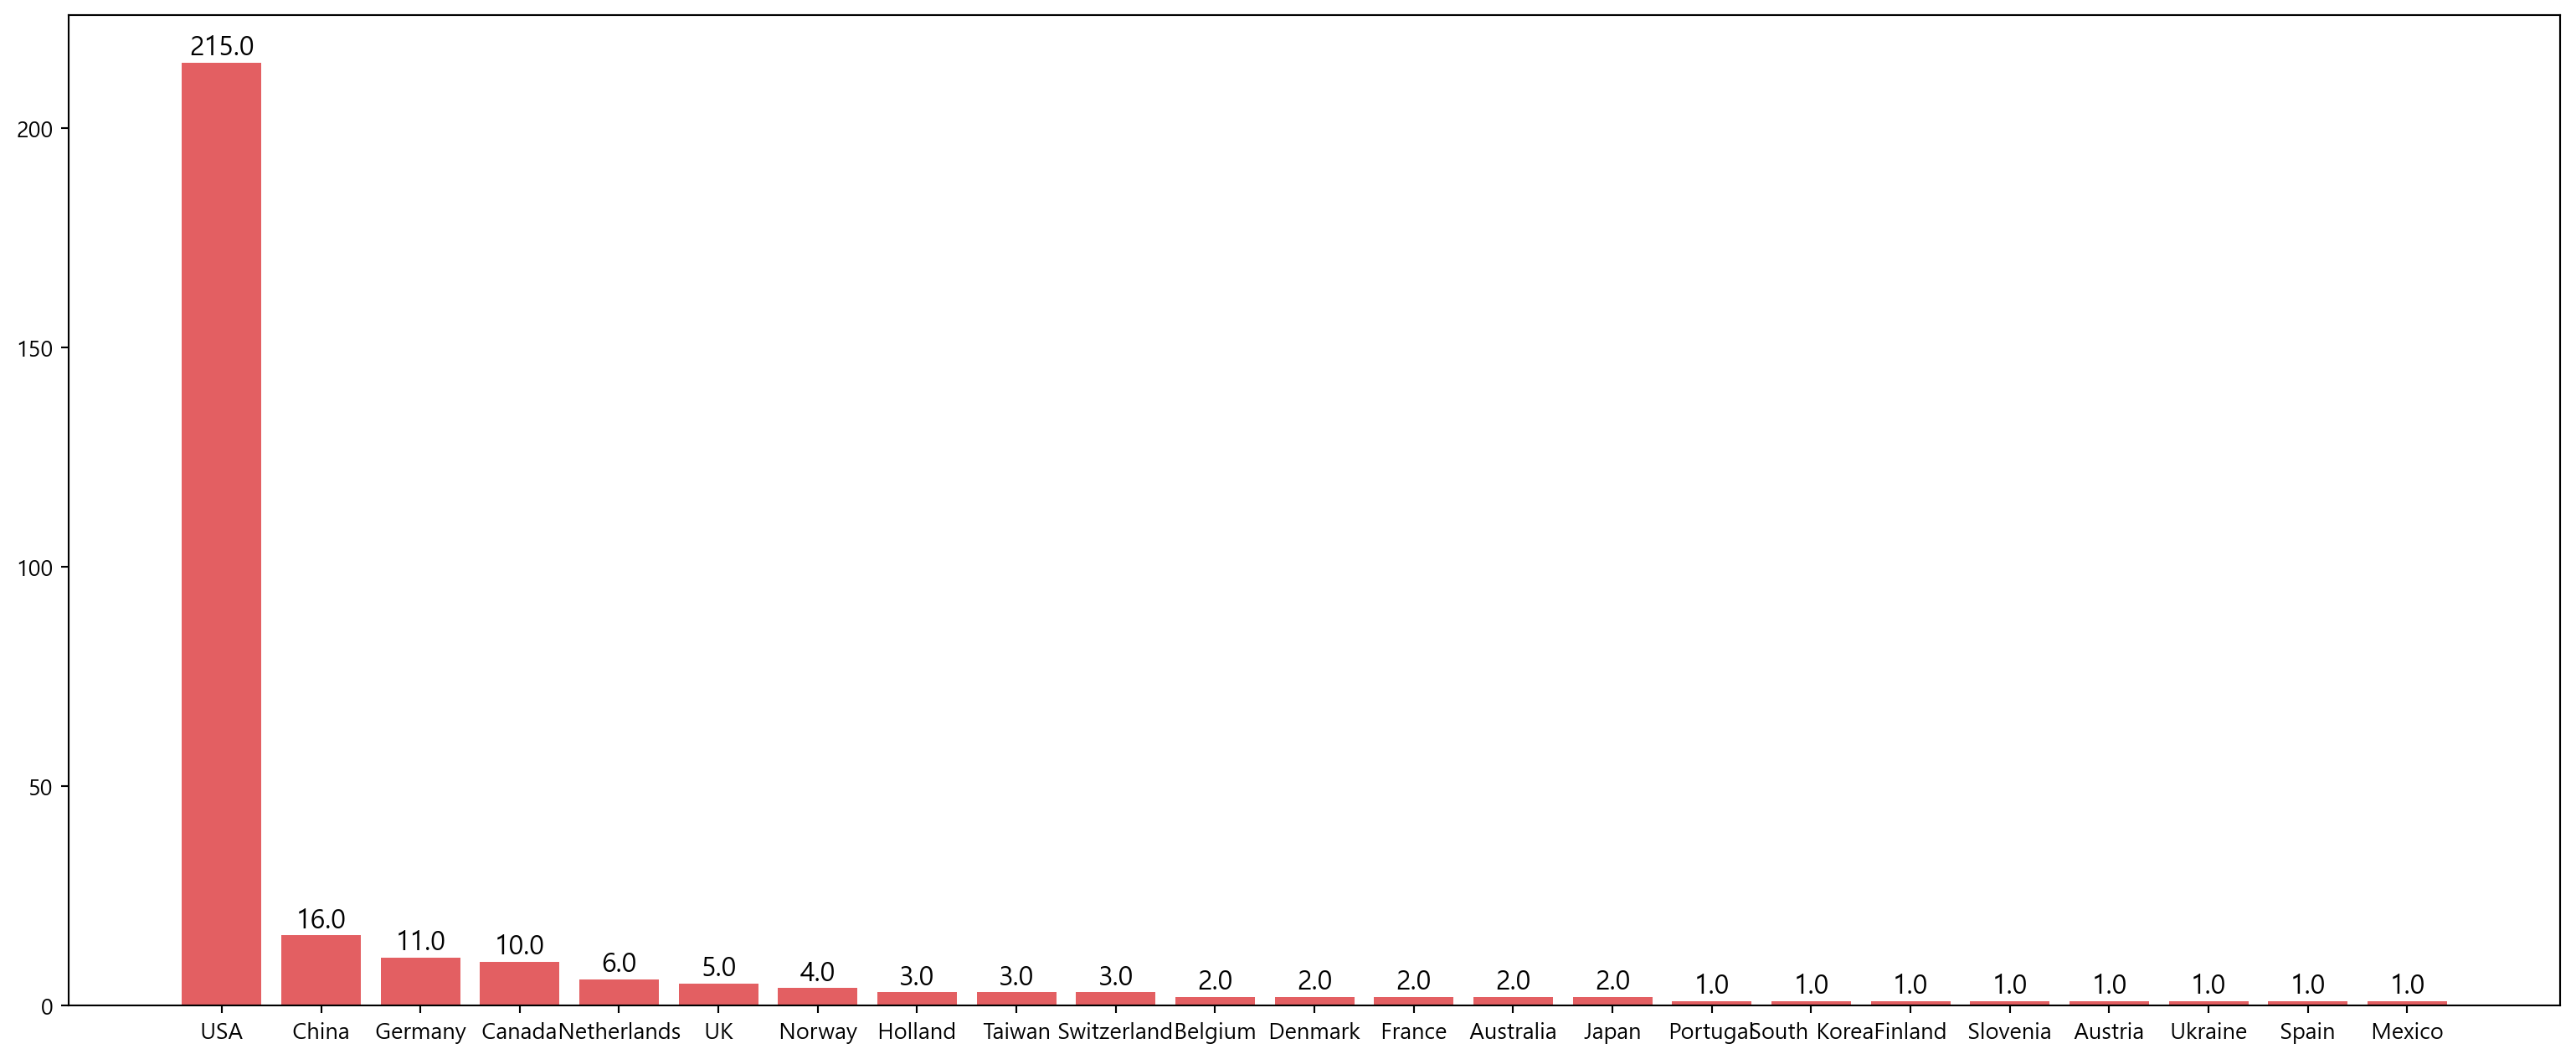

In [4]:
x = df["Country"].value_counts().index
y = df["Country"].value_counts().values
plt.figure(figsize=(20,8))
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)
plt.bar(x,y,color='#e35f62')

### Let's look at the number of accidents per month

<BarContainer object of 12 artists>

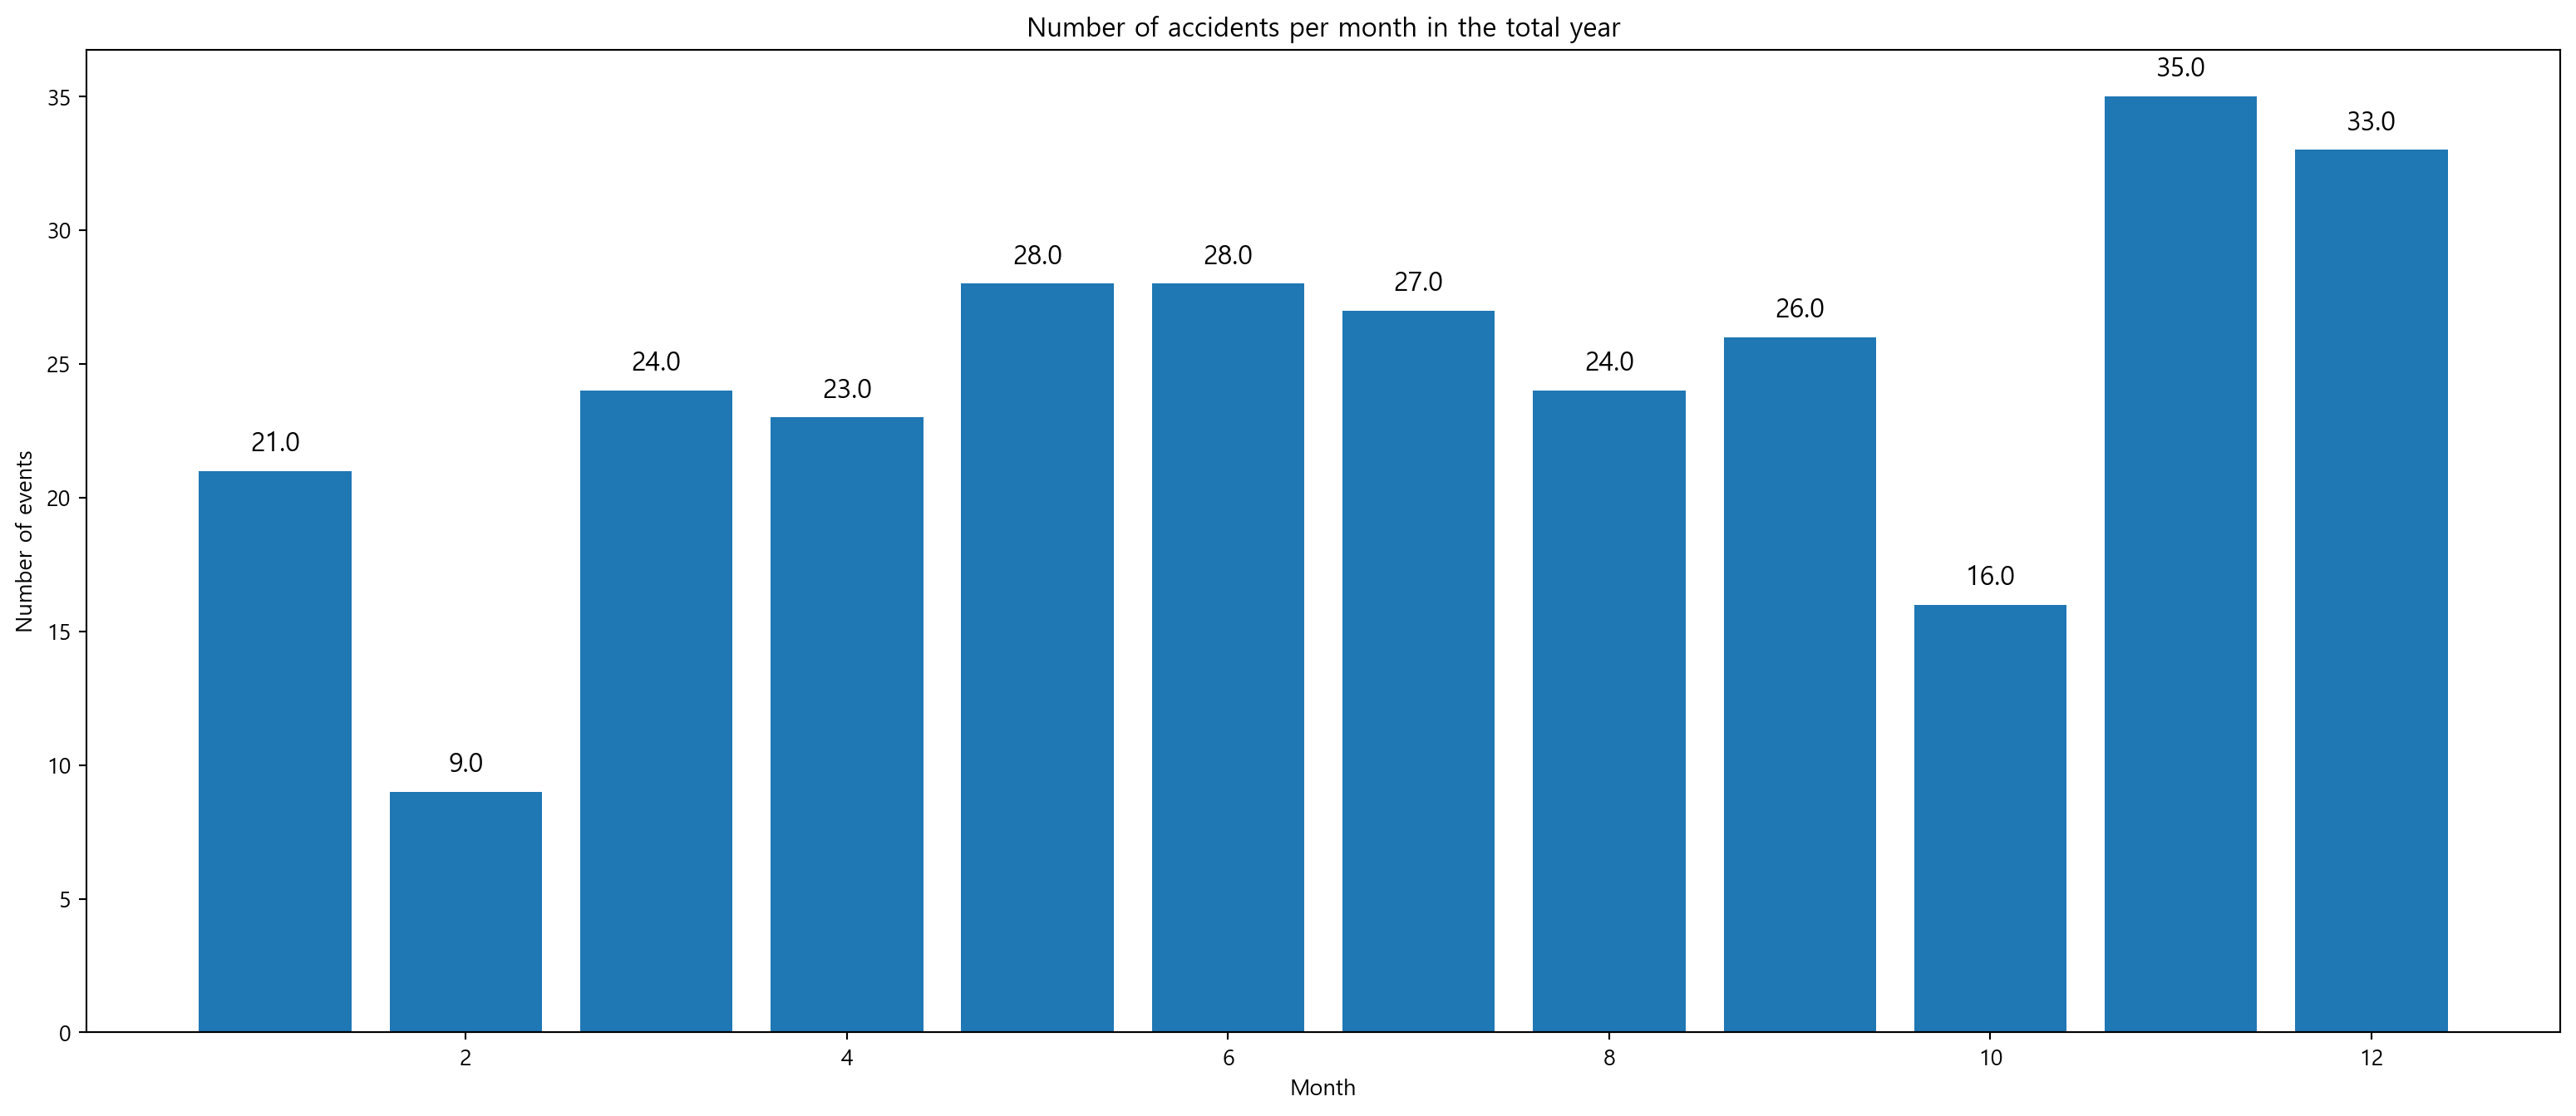

In [5]:
#| warning: false
plt.figure(figsize=(20,8))
x = df["event_month"].value_counts().sort_index().index
y = df["event_month"].value_counts().sort_index().values
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 0.5, '%.1f' %height, ha='center', va='bottom', size = 12)
plt.title("Number of accidents per month in the total year")
plt.xlabel("Month")
plt.ylabel("Number of events")
plt.bar(x,y)

### It appears that there are relatively more accidents in November and December.

### Let's look at the distribution of the following variables:

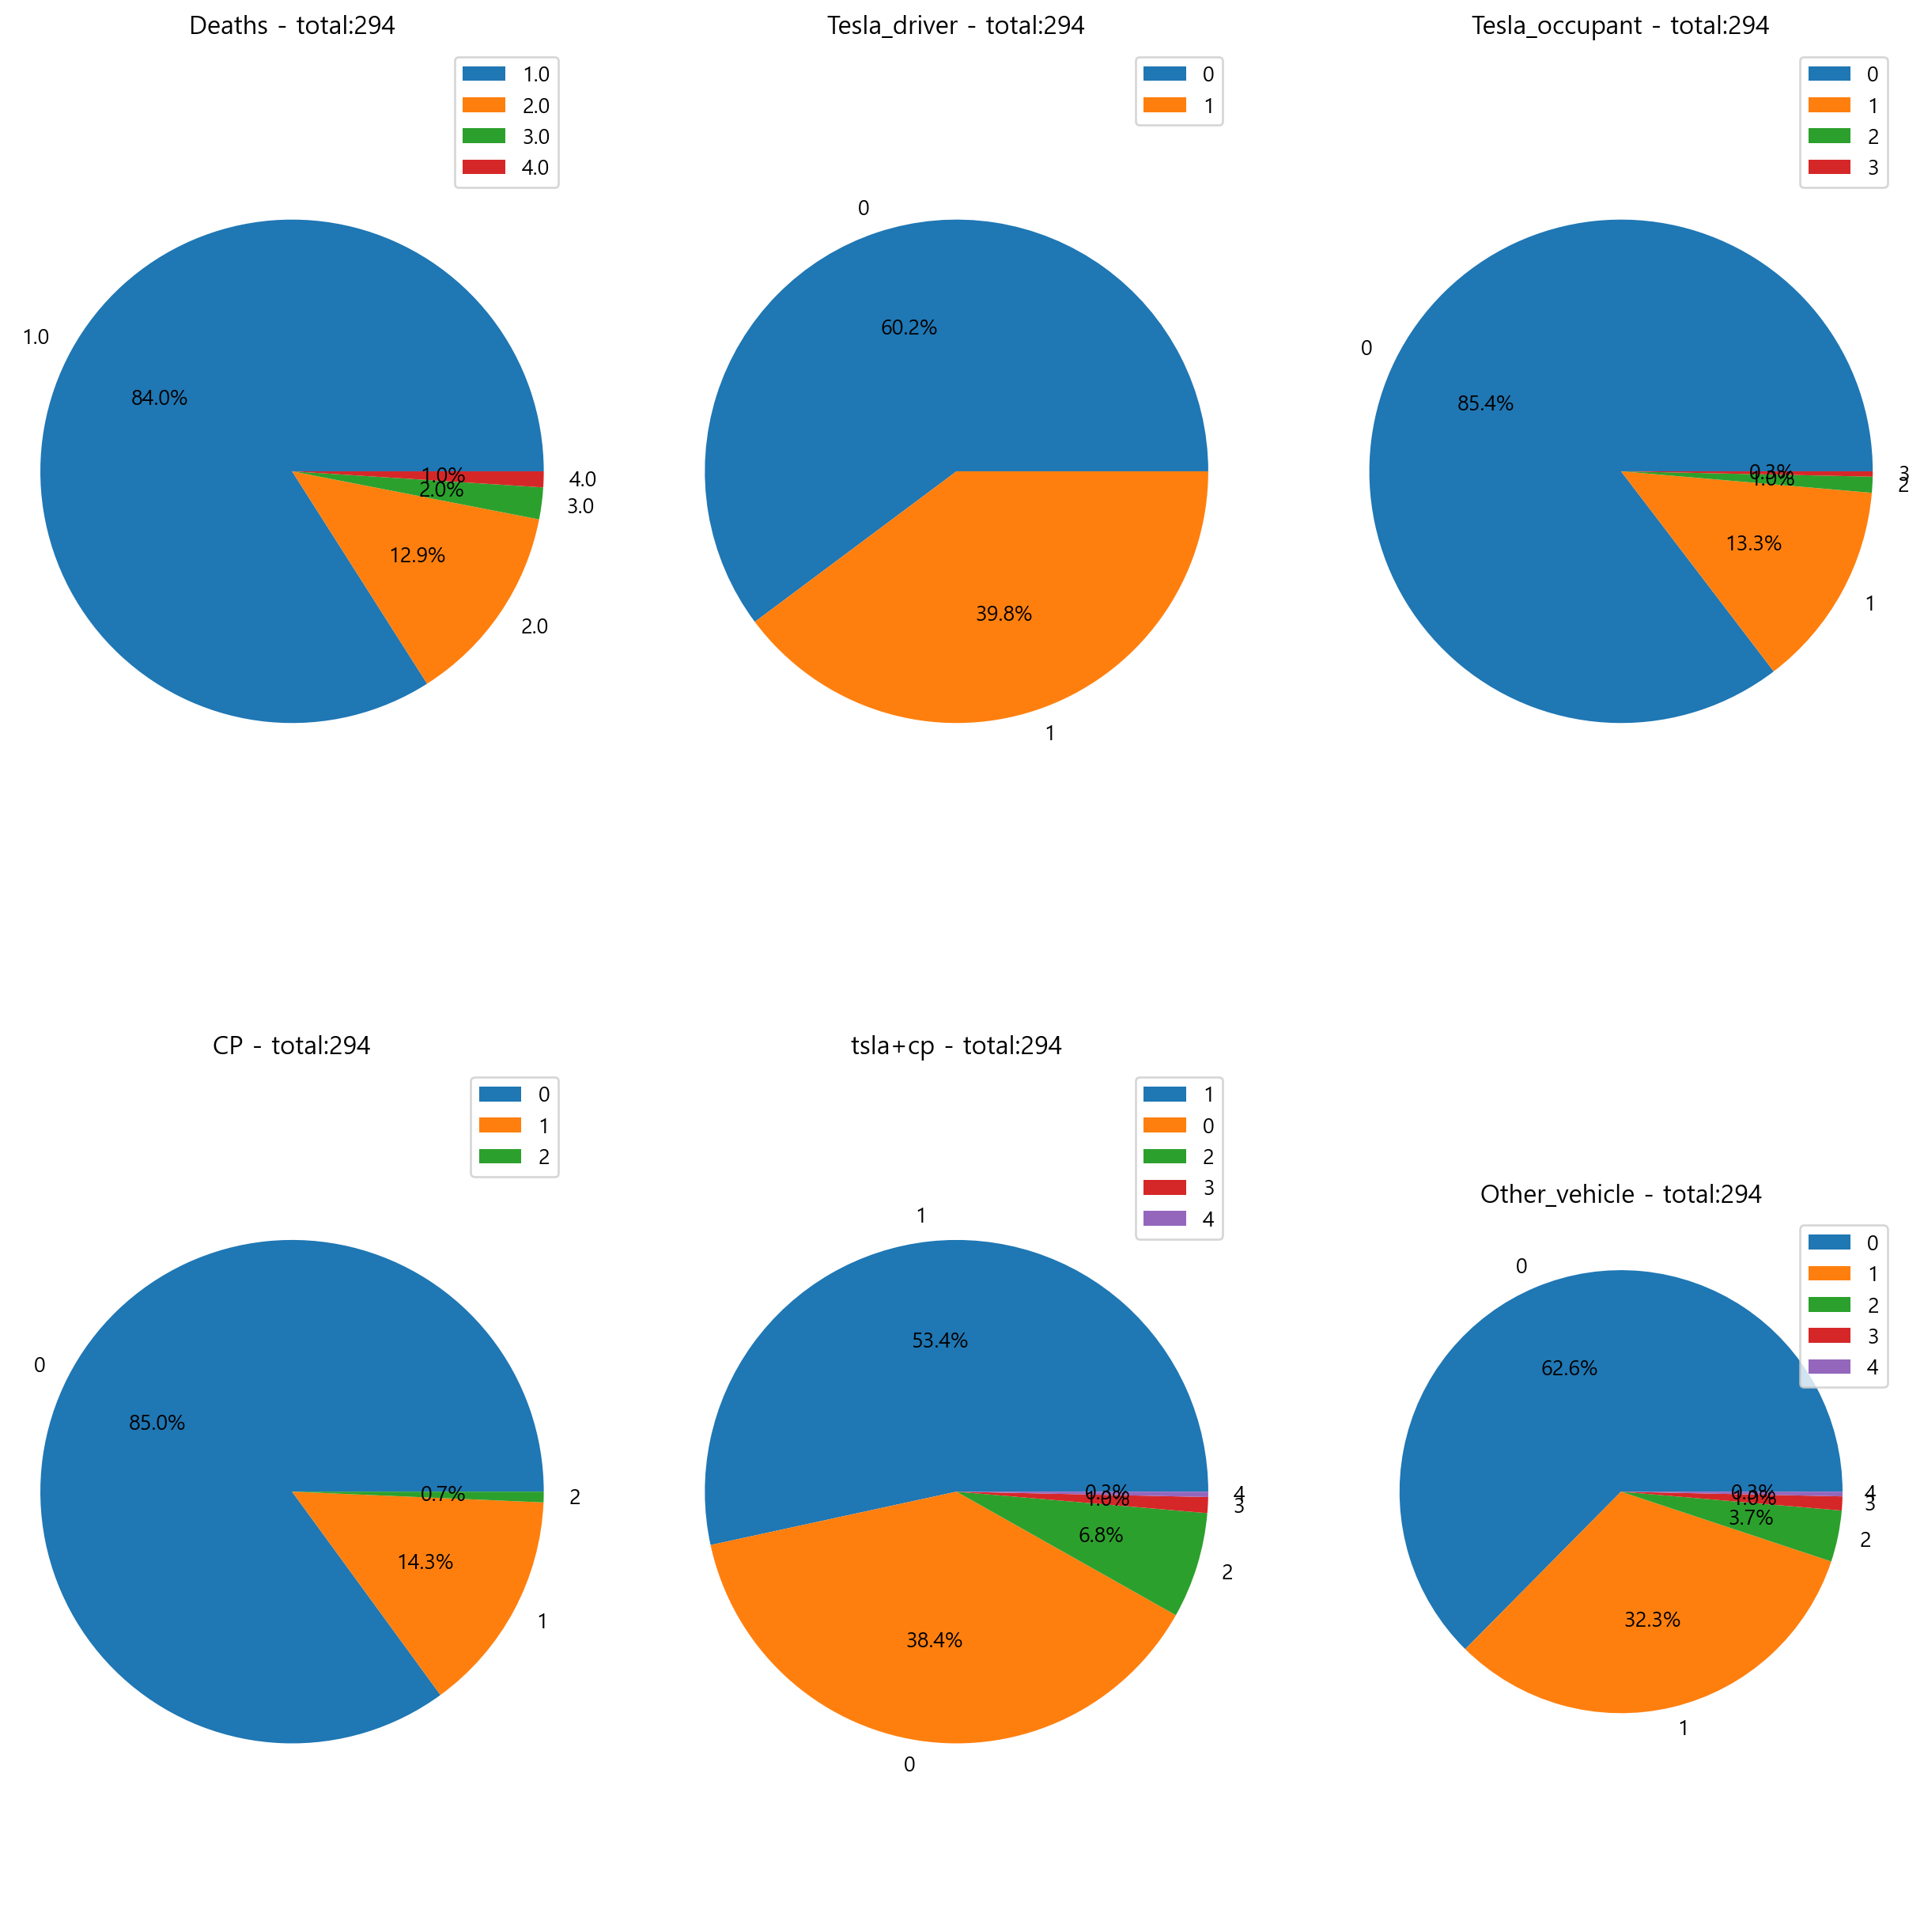

In [6]:
#| warning: false
d_list = ["Deaths","Tesla_driver","Tesla_occupant","CP","tsla+cp","Other_vehicle"]
label = ["0","1","2","3","4","5"]
plt.figure(figsize = (16,16))
for b in range(len(d_list)):
    size = df[d_list[b]].value_counts().values
    colors = []
    label = df[d_list[b]].value_counts().index
    plt.axis("equal")
    plt.rc("font",family="Malgun Gothic")
    plt.rc('legend', fontsize=10)
    plt.subplot(2,3,b+1)
    plt.title(d_list[b]+" - total:" +str(len(df[d_list[b]])))
    plt.pie(size,labels=label, autopct = "%.1f%%")
    plt.legend()

### The above collection of pie charts indicates that the majority of the accidents involve one casualty.

### why are there more accidents in November and December? Does that necessarily mean Tesla is maneuverable?  
Since there is a 'description' variable in the dataset, which briefly depicts the possible cause and the crash scene, I will classify the accidents into smaller categories.

In [7]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)]
data = df["Description"]

lemmatized_data = [lemmatize_text(text) for text in data]
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform([' '.join(text) for text in lemmatized_data])

kmeans = KMeans(n_clusters= 5, random_state=0)
kmeans.fit(X)
clusters = kmeans.predict(X)

### Let's see how the classification goes.

In [8]:
df["Description"].value_counts()

Description
 Tesla kills pedestrian                         10
 Tesla kills motorcyclist                        6
 Tesla into oncoming traffic                     5
 Tesla rear ends stopped car                     4
 Tesla drives off cliff                          4
                                                ..
 Tesla crashes into trees                        1
 Multi-crash involving DUI                       1
 Tesla loses control and drives into river       1
 Crash in public area including 20 injuries      1
 Tesla veers into opposite lane                  1
Name: count, Length: 248, dtype: int64

### Let's look at the distribution of the classification

<BarContainer object of 5 artists>

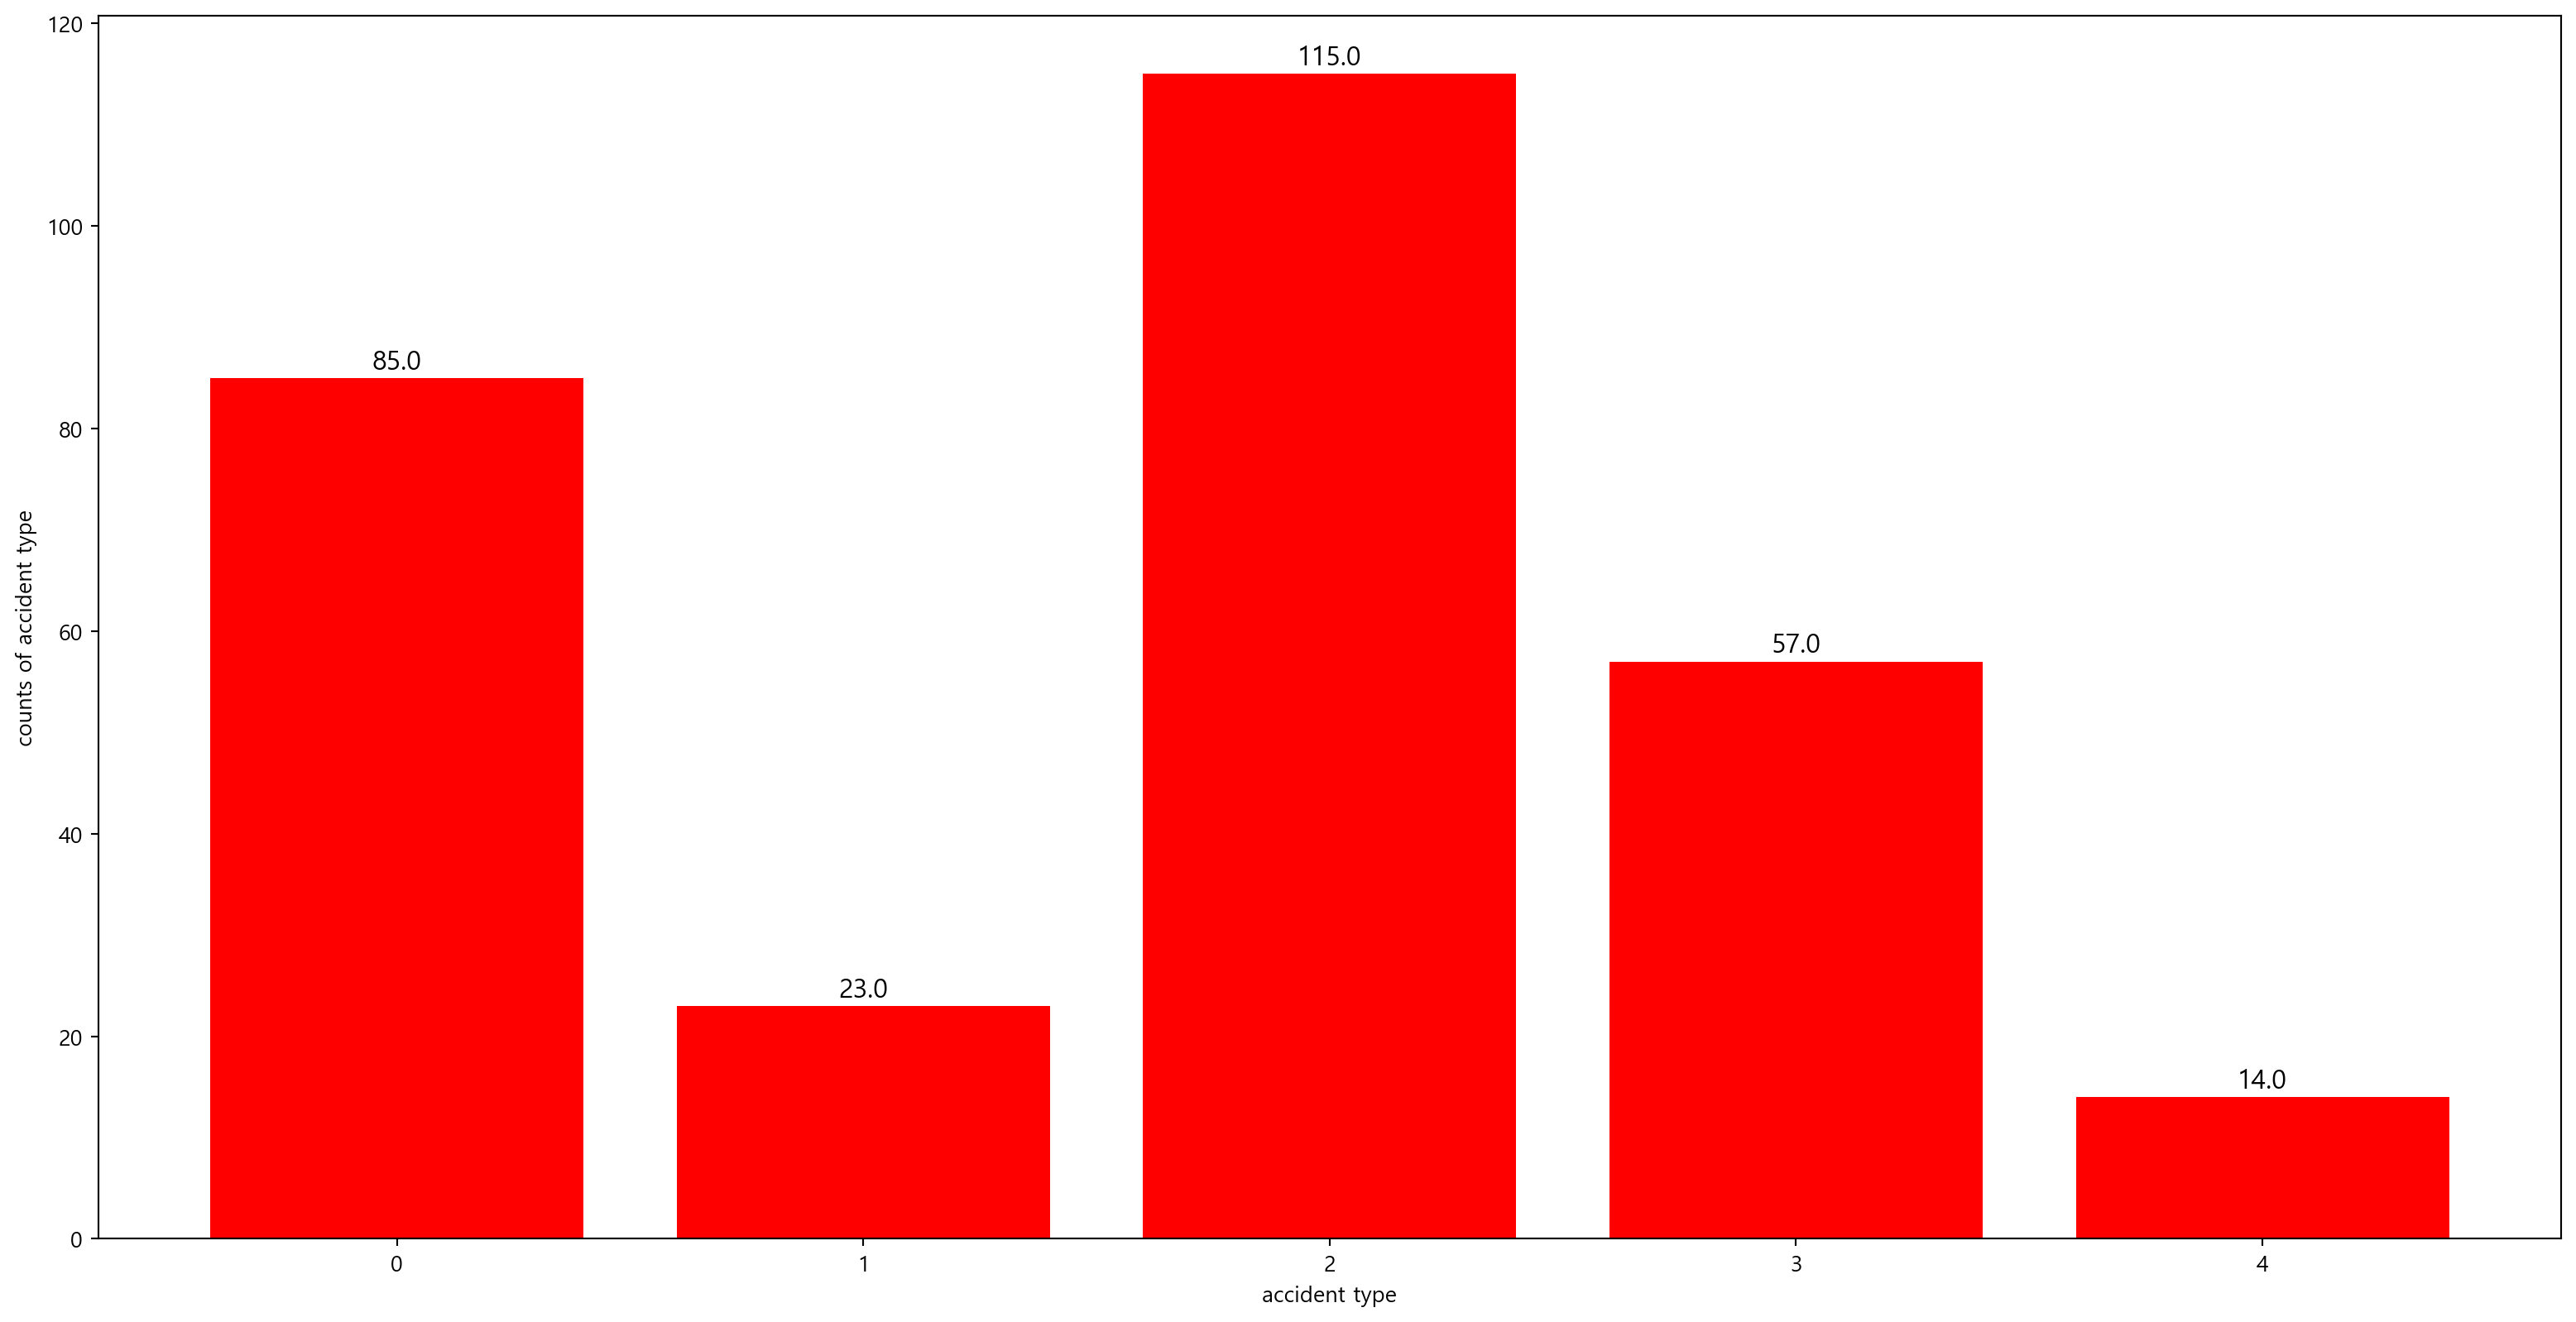

In [9]:
#| warning: false
df.loc[:, "cluster"] = 0
for i, item in enumerate(df["Description"]):
    for cluster, description in zip(clusters, data):
        if item == description:
            df["cluster"][i] = cluster
accident_0 = []
accident_1 = []
accident_2 = []
accident_3 = []
accident_4 = []
for i, cluster in enumerate(clusters):
    if cluster == 0:
        accident_0.append(data[i])
    elif cluster == 1:
        accident_1.append(data[i])
    elif cluster == 2:
        accident_2.append(data[i])
    elif cluster == 3:
        accident_3.append(data[i])
    elif cluster == 4:
        accident_4.append(data[i])
accident_0_score = []
accident_1_score = []
accident_2_score = []
accident_3_score = []
accident_4_score = []

def get_score_list(a,b1):
    for i in range(len(a)):
        for b in range(len(df["Description"].value_counts().index)):
            if df["Description"].value_counts().index[b] == a[i]:
                b1.append(df["Description"].value_counts().values[b])
                
get_score_list(accident_0,accident_0_score)
get_score_list(accident_1,accident_1_score)
get_score_list(accident_2,accident_2_score)
get_score_list(accident_3,accident_3_score)
get_score_list(accident_4,accident_4_score)
x = [0,1,2,3,4]
y = [len(accident_0),len(accident_1),len(accident_2),len(accident_3),len(accident_4)]
plt.figure(figsize=(20,10))
# plt.title("accident type's counts")
plt.xlabel("accident type")
plt.ylabel("counts of accident type")
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 0.25, '%.1f' %height, ha='center', va='bottom', size = 12)
plt.bar(x,y,color='red')

### Let's see what type-2 accident is about.
It seems that this type of collision has little to do with the maneuverability of Tesla.

In [10]:
df[df['cluster'] == 2].head(10)

Date   Country State  \
8   12/11/2022      USA     MO   
9    12/6/2022   Canada      -   
10  11/28/2022    China      -   
15  11/12/2022      USA     CA   
18   11/4/2022      USA     IL   
20  10/18/2022      USA     FL   
26   9/16/2022      USA     GA   
27   9/13/2022      USA     CA   
28   9/12/2022      USA     NY   
29    9/7/2022      USA     CA   

                                          Description  Deaths Tesla_driver  \
8                          Collision at intersection      1.0            0   
9                   Tesla veers, collides with truck      1.0            1   
10      Tesla runs red light, collides with two cars      2.0            0   
15                            Multi-vehicle accident      1.0            0   
18   Collision at intersection, Tesla driver dies ...     1.0            1   
20   Tesla collides with minivan, engulfed by flames      4.0            1   
26   Tesla loses control and crashes into bus shel...     1.0            0   
27                            Tesla runs off highway      1.0            1   
28                 Tesla runs off road, catches fire      1.0            1   
29                    Motorcycle collides with Tesla      1.0            1   

   Tesla_occupant Other_vehicle CP tsla+cp Model Claimed VTAD  event_year  \
8               0             1  0       0     0       0    0        2022   
9               0             0  0       0     0       0    0        2022   
10              0             2  0       0    Y        0    0        2022   
15              0             1  0       0     0       0    0        2022   
18              0             0  0       1     0       0    0        2022   
20              1             2  0       2     0       0    0        2022   
26              0             0  1       1     0       1    0        2022   
27              0             0  0       1     0       0    0        2022   
28              0             0  0       0     0       0    0        2022   
29              0             0  0       0     0       0    0        2022   

    event_month  event_day  cluster  
8            12         11        2  
9            12          6        2  
10           11         28        2  
15           11         12        2  
18           11          4        2  
20           10         18        2  
26            9         16        2  
27            9         13        2  
28            9         12        2  
29            9          7        2

### Let's see what type-0 accident is about.
It seems that this type of collision also has little to do with the maneuverability of Tesla.

In [11]:
df[df['cluster'] == 0].head(10)

Date   Country State                         Description  Deaths  \
0    1/17/2023      USA     CA    Tesla crashes into back of semi      1.0   
1     1/7/2023   Canada      -                      Tesla crashes      1.0   
3   12/22/2022      USA     GA            Tesla crashes and burns      1.0   
4   12/19/2022   Canada      -      Tesla crashes into storefront      1.0   
7   12/11/2022      USA     CA            Tesla crashes into wall      1.0   
13  11/18/2022    China      -      Tesla crashes into dump truck      1.0   
19  10/19/2022      USA     CA                     Multicar crash      1.0   
21  10/12/2022       UK      -           Tesla crashes into ditch      1.0   
24   9/18/2022      USA     SC   Tesla crashes into tree, ignites      2.0   
25   9/18/2022      USA     MD                 Multi-car accident      1.0   

   Tesla_driver Tesla_occupant Other_vehicle CP tsla+cp Model Claimed VTAD  \
0             1              0             0  0       1     0       0    0   
1             1              0             0  0       1     0       0    0   
3             1              0             0  0       1     0       0    0   
4             0              0             0  1       1     0       0    0   
7             1              0             0  0       0     0       0    0   
13            1              0             0  0       1     0       0    0   
19            1              0             0  0       1     1       0    0   
21            1              0             0  0       1     2       0    0   
24            1              1             0  0       2     0       0    0   
25            0              0             1  0       0     0       0    0   

    event_year  event_month  event_day  cluster  
0         2023            1         17        0  
1         2023            1          7        0  
3         2022           12         22        0  
4         2022           12         19        0  
7         2022           12         11        0  
13        2022           11         18        0  
19        2022           10         19        0  
21        2022           10         12        0  
24        2022            9         18        0  
25        2022            9         18        0

### Number of deaths in each type of accident 

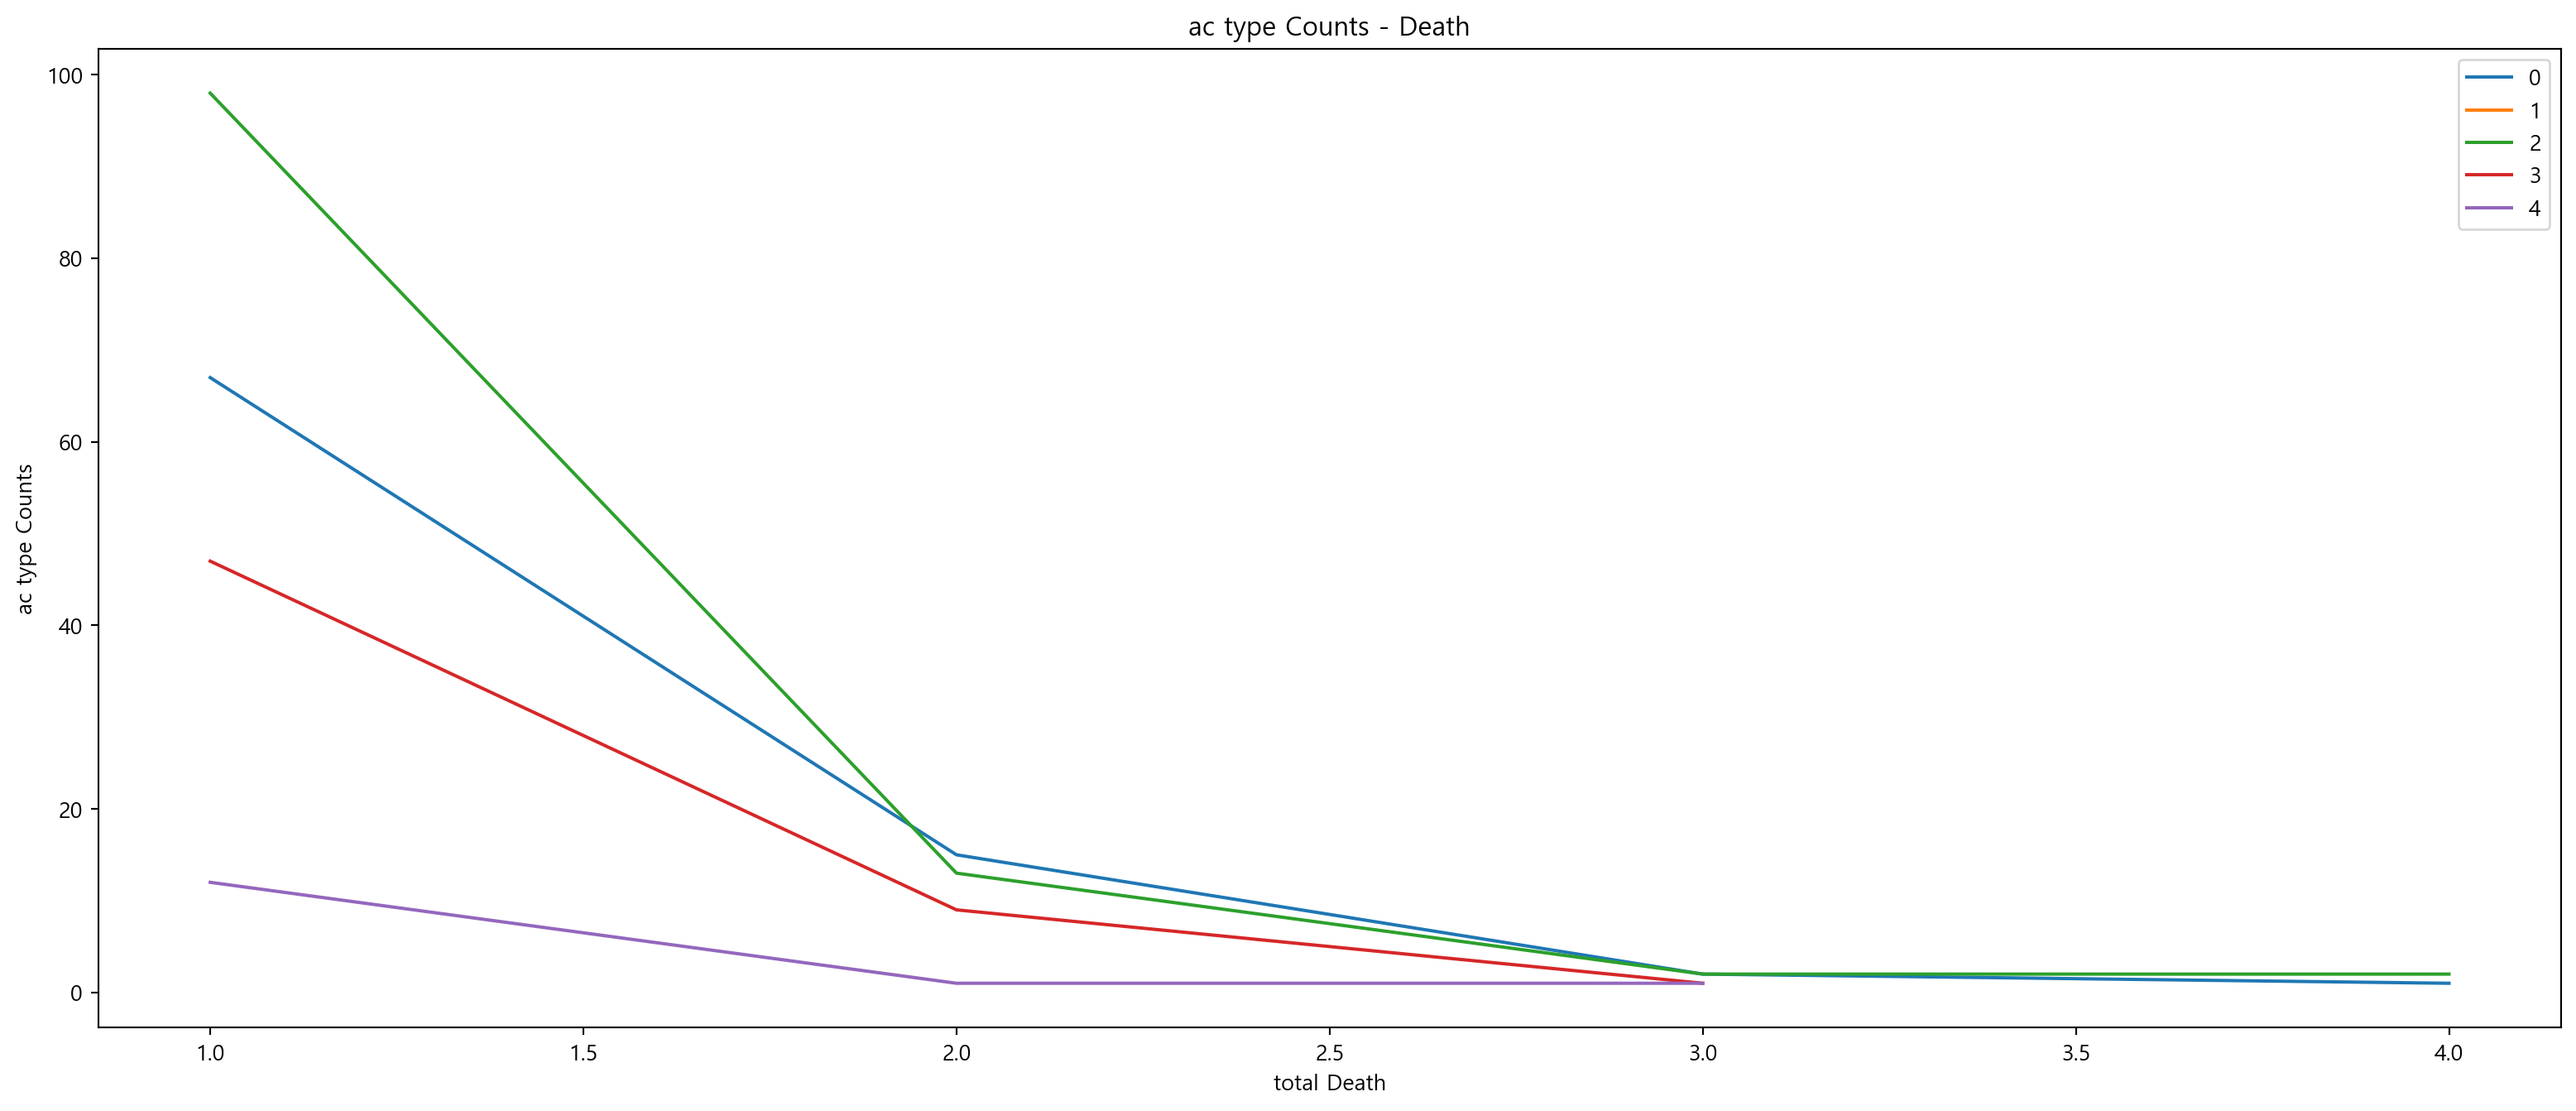

In [12]:
for i in range(0,5):
    df[df["cluster"]==i]["Deaths"].value_counts().sort_index().plot(figsize=(20,8))
    plt.xlabel("total Death")
    plt.ylabel("ac type Counts")
    plt.title("ac type Counts - Death")
    plt.legend("01234")

### Distribution of each type of accident at each year recorded

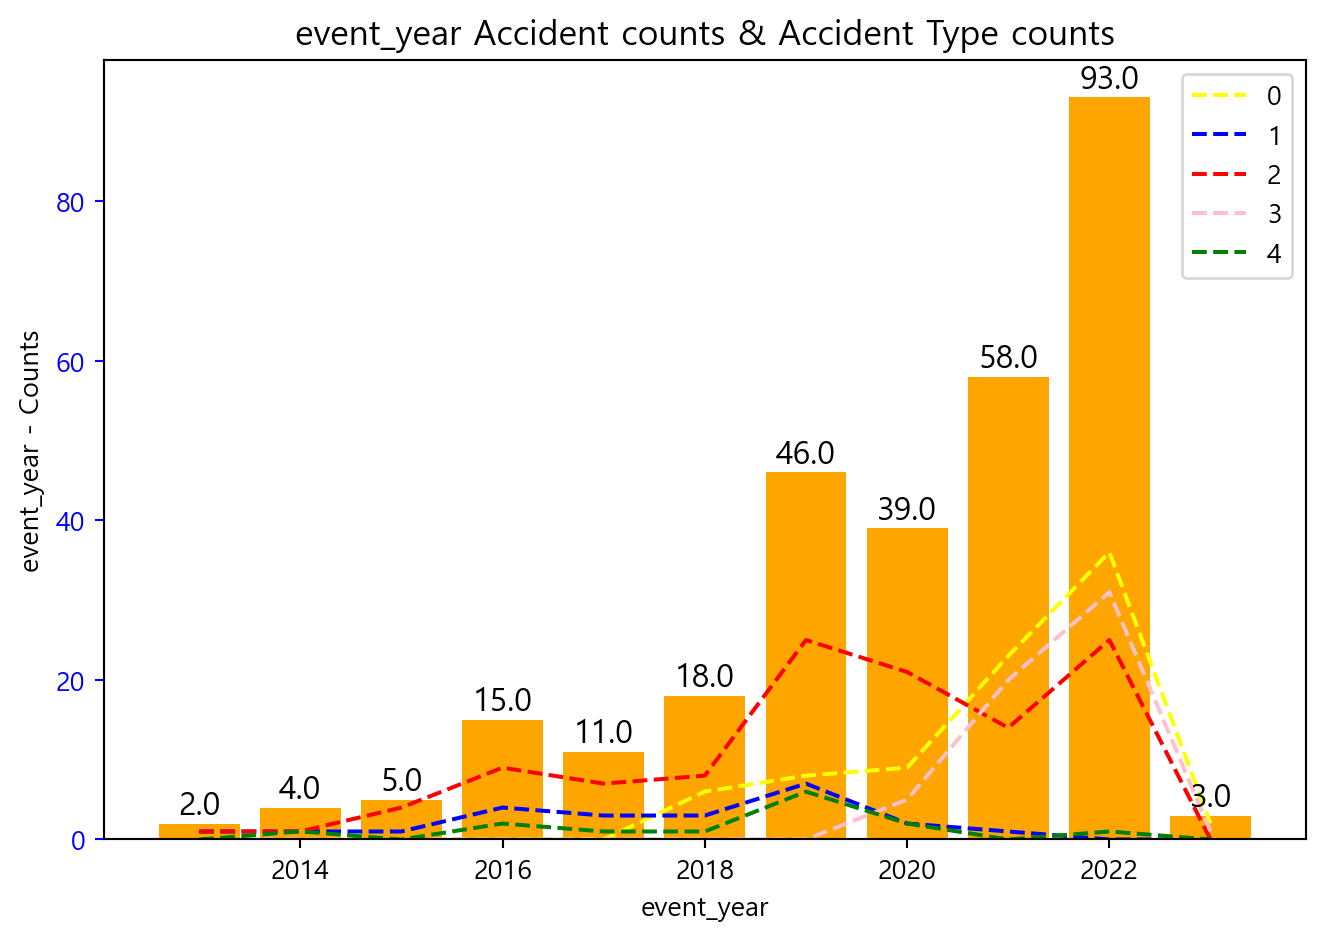

<Figure size 1920x768 with 0 Axes>

In [13]:
def make_Graph(feature):
    x_s = df[feature].value_counts().sort_index().index
    y_s = df[feature].value_counts().sort_index().values
    y0_s = df[df["cluster"]==0][feature].value_counts().sort_index()
    y1_s = df[df["cluster"]==1][feature].value_counts().sort_index()
    y2_s = df[df["cluster"]==2][feature].value_counts().sort_index()
    y3_s = df[df["cluster"]==3][feature].value_counts().sort_index()
    y4_s = df[df["cluster"]==4][feature].value_counts().sort_index()
    def fill_y(x,y):
        for i in x:
            if i not in y.index:
                y[i] = 0
    fill_y(x_s,y0_s)
    fill_y(x_s,y1_s)
    fill_y(x_s,y2_s)
    fill_y(x_s,y3_s)
    fill_y(x_s,y4_s)
    
#     plt.figure(figsize=(10,8))
    ax,ax0,ax1,ax2,ax3,ax4 = plt.gca(),plt.gca(),plt.gca(),plt.gca(),plt.gca(),plt.gca()

    for i in range(len(x_s)):
        height = y_s[i]
        plt.text(x_s[i], height + 0.15, '%.1f' %height, ha='center', va='bottom', size = 12)

    ax.bar(x_s, y_s, color='orange', linestyle='--')
    ax.set_ylabel(feature+' - Counts', fontsize=10)
    ax.tick_params('y', colors='blue') 

    ax0.plot(x_s, y0_s.sort_index().values, color='yellow', linestyle='--',label = "0")
    ax1.plot(x_s, y1_s.sort_index().values, color='blue', linestyle='--',label = "1")
    ax2.plot(x_s, y2_s.sort_index().values, color='red', linestyle='--',label = "2")
    ax3.plot(x_s, y3_s.sort_index().values, color='pink', linestyle='--',label = "3")
    ax4.plot(x_s, y4_s.sort_index().values, color='green', linestyle='--',label = "4")

    ax1.set_xlabel(feature, fontsize=10)
    plt.title(feature+" Accident counts & Accident Type counts",fontsize=13)
    plt.tight_layout()
    plt.legend()
    plt.figure(figsize=(20,8))
make_Graph("event_year")

### Conclusion:
We do not have enough evidence to claim that the maneuverability of Tesla is flawed, since most accidents are caused by human errors. However, more accidents did occur at latest years, which might be due to the largely increased number of Tesla on road.

## Second dataset: UK Road Safety: Traffic Accidents and Vehicles (gas car)

In [14]:
from collections import Counter
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')
from sklearn.pipeline import Pipeline
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import boxcox
import pickle
from numpy.random import seed
seed(862)
from tensorflow.random import set_seed
set_seed(862)
data = pd.read_csv("./Data/RoadAccident.csv")
data.drop(['Accident_Index','Datetime'], axis = 1,inplace=True) 
d = {"Feature":[i for i in data.columns]    ,"Nunique" :data.nunique().values ,'Type' : data.dtypes.values, "No: of nulls" : data.isnull().sum() }
description = pd.DataFrame(data = d)
description
data["Season"]=data["Season"].astype(str)
data["Month_of_Year"]=data["Month_of_Year"].astype(str)
data["Day_of_Week"]=data["Day_of_Week"].astype(str)
data["Year"]=data["Year"].astype(str)
data["Number_of_Vehicles"]=data["Number_of_Vehicles"].astype(str)
Counter(data['Accident_Severity'])

Counter({'Slight': 56705, 'Fatal_Serious': 18845})

### Plot count plots for the categorical data and histogram for numerical data

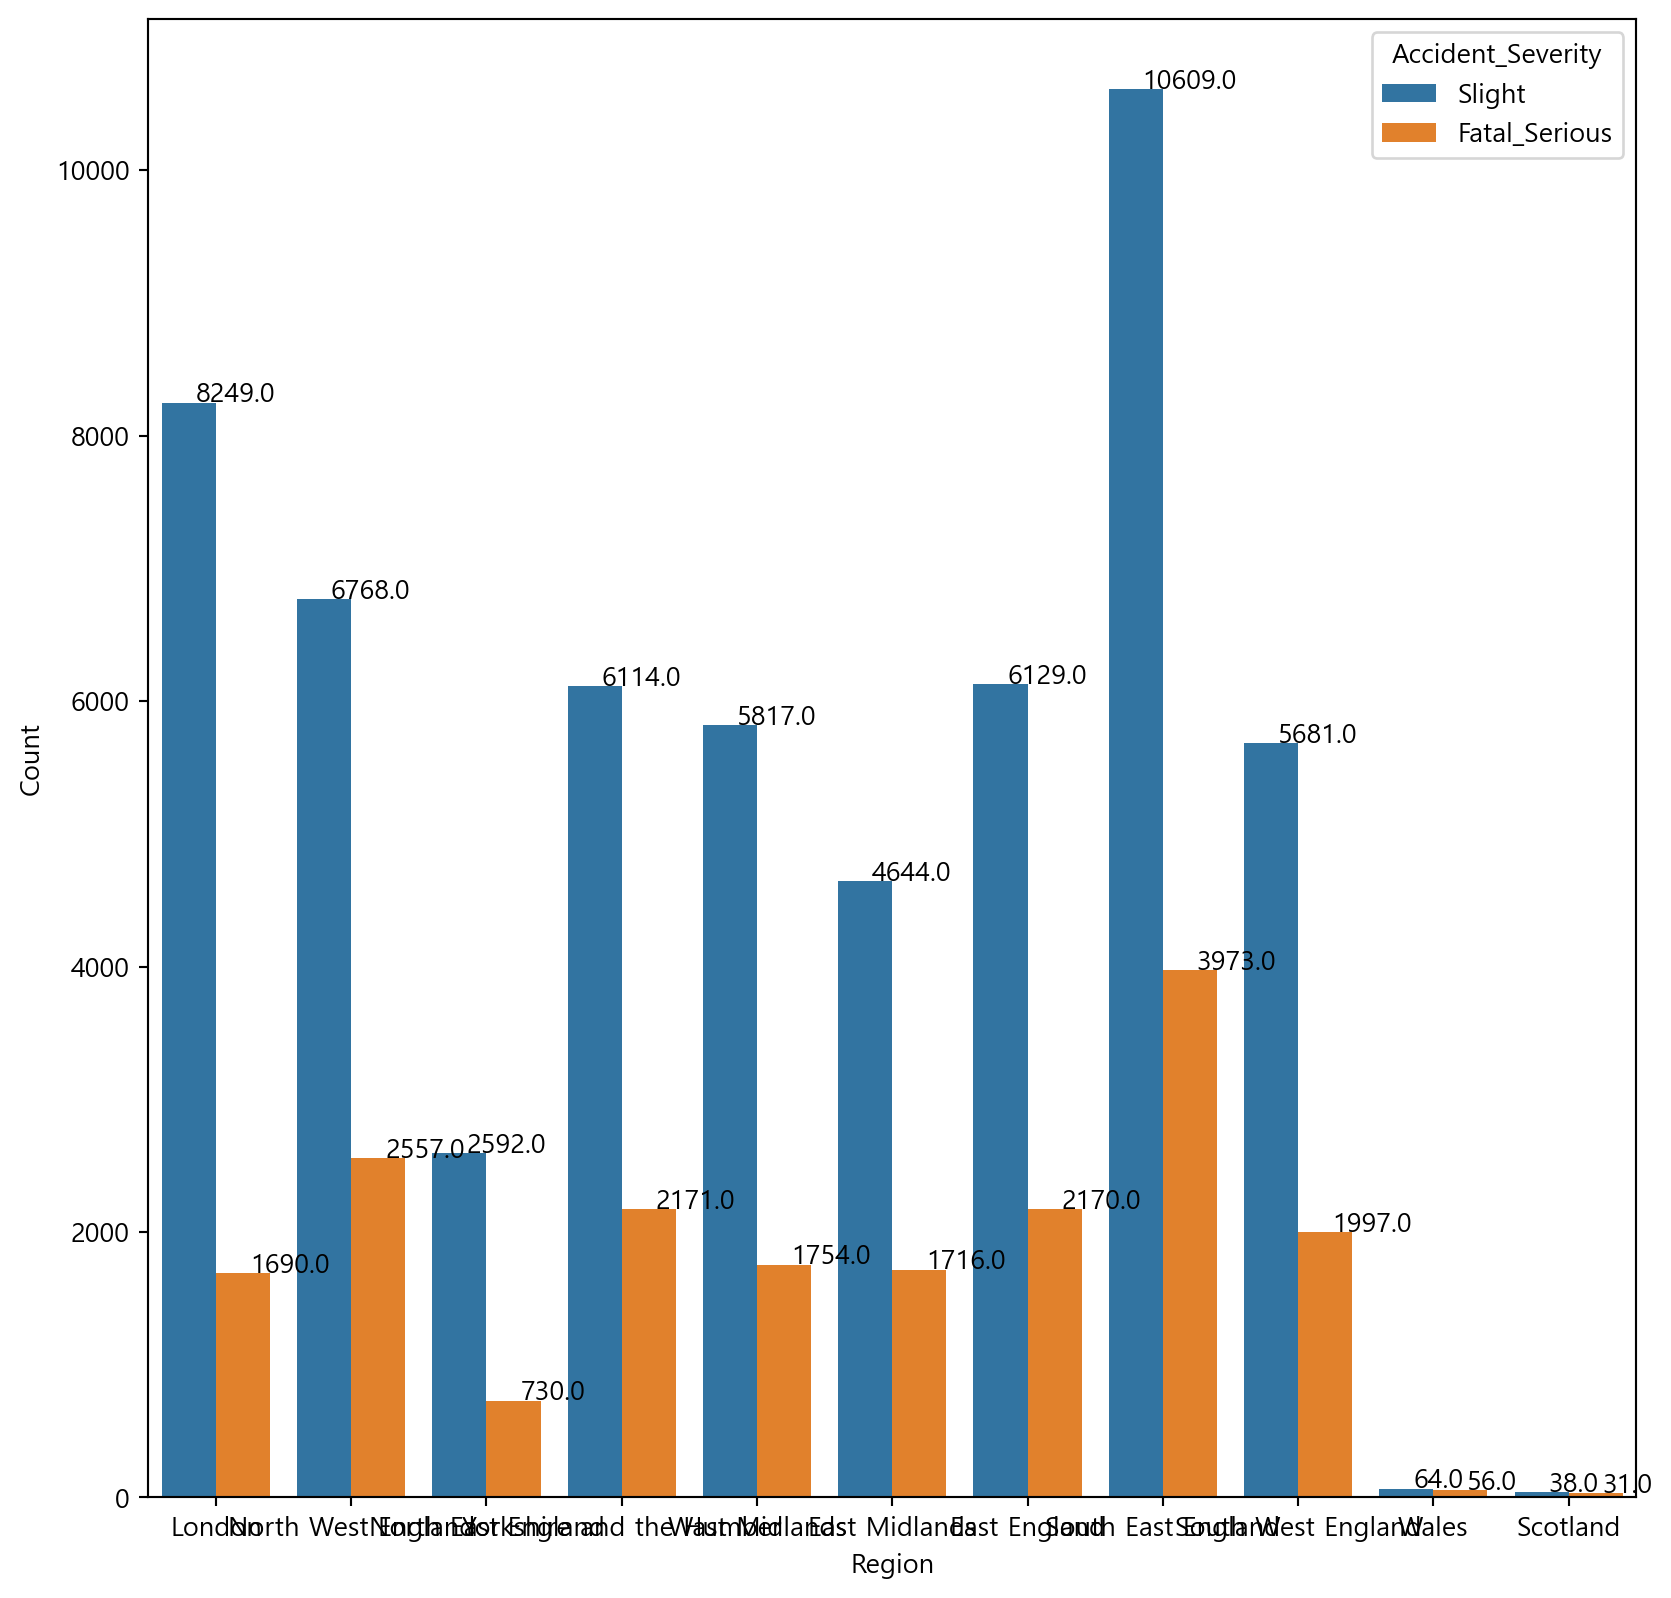

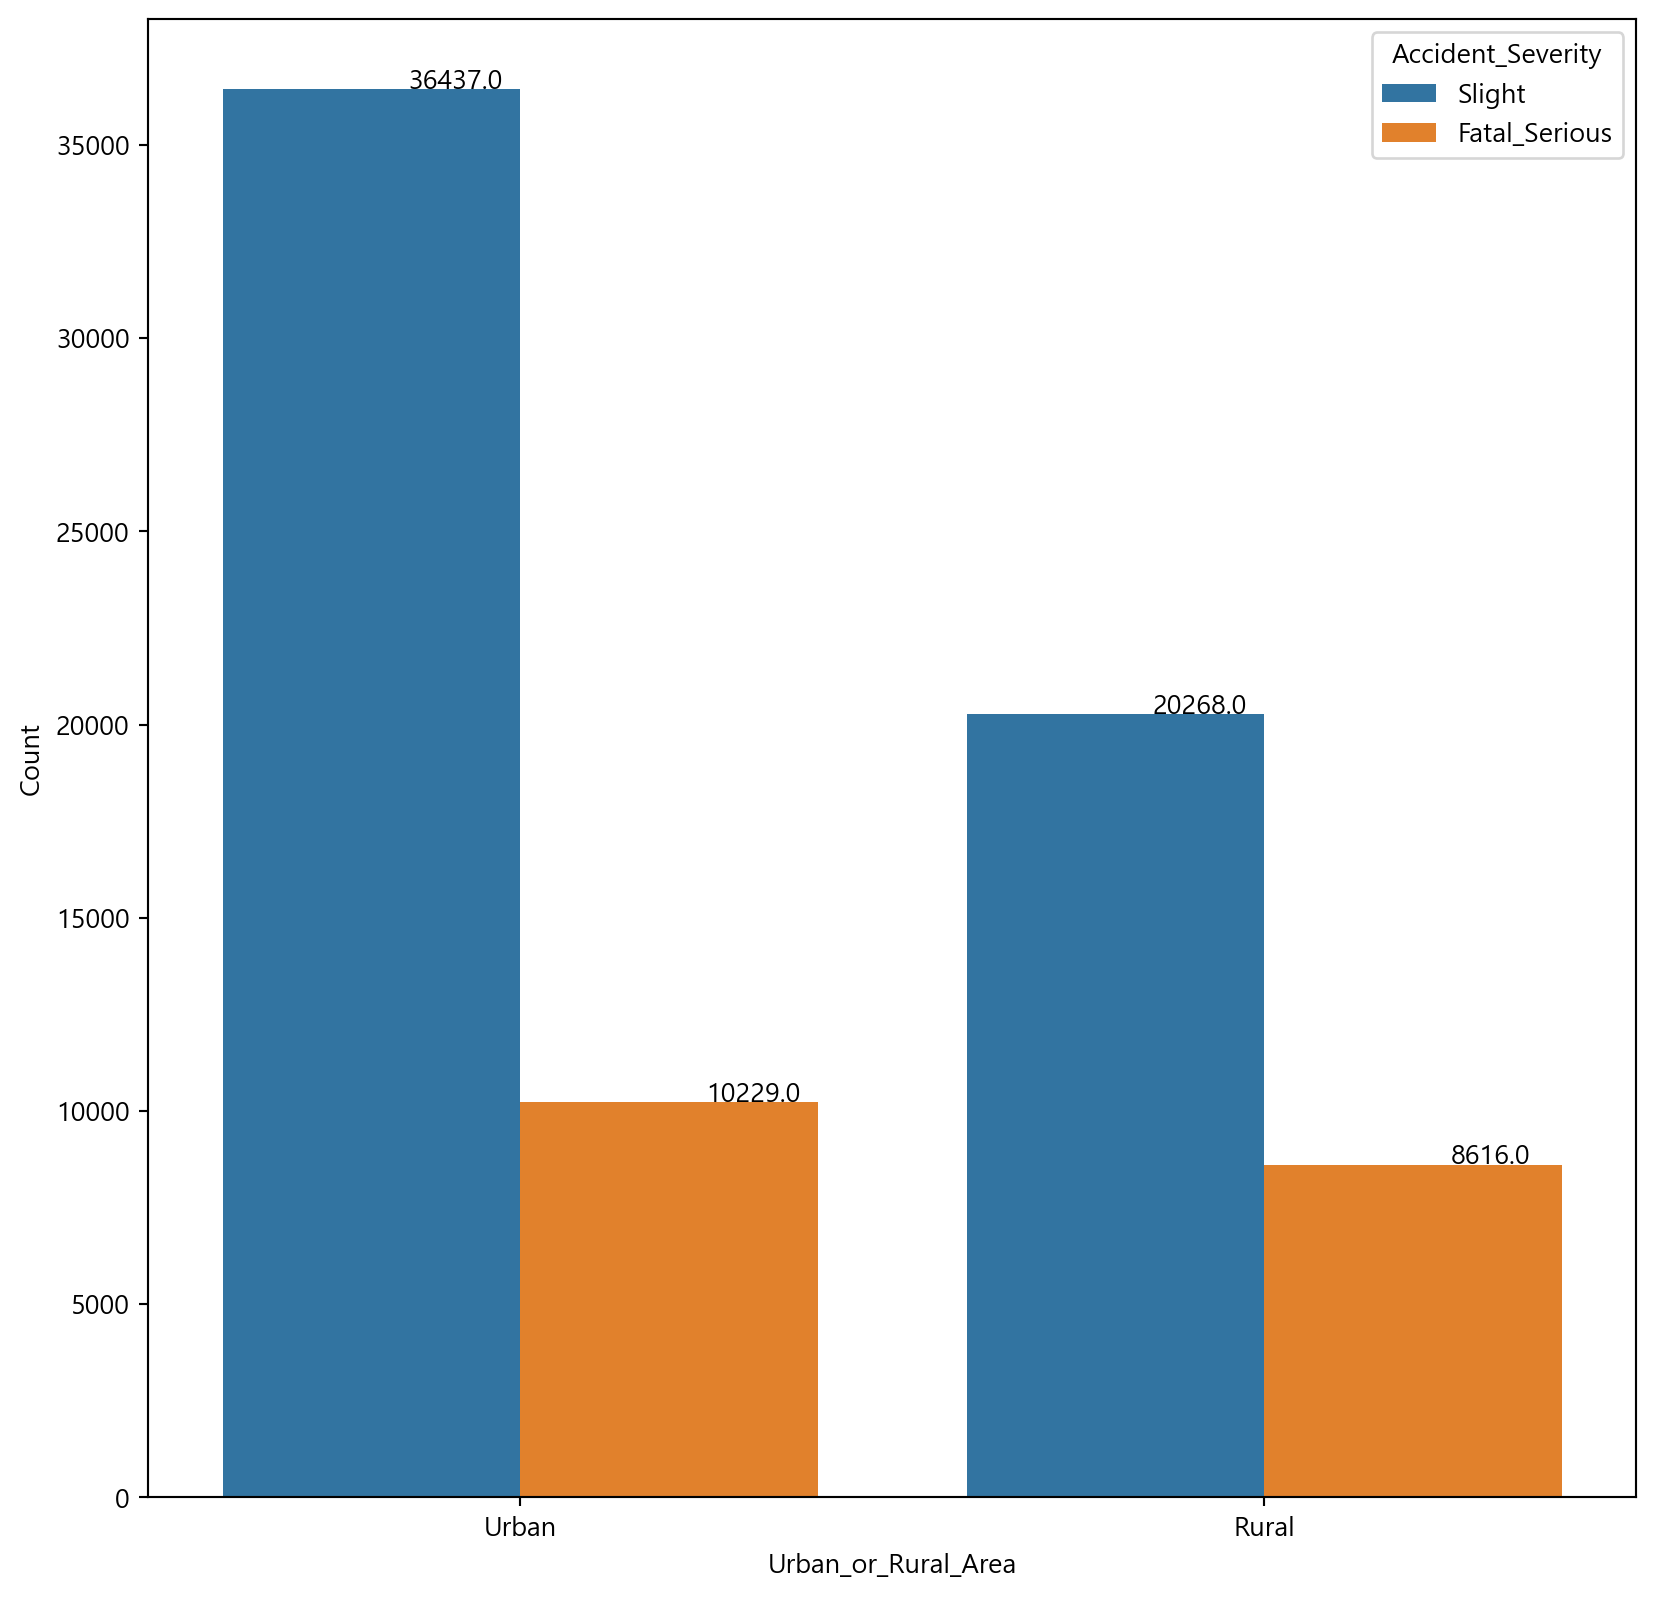

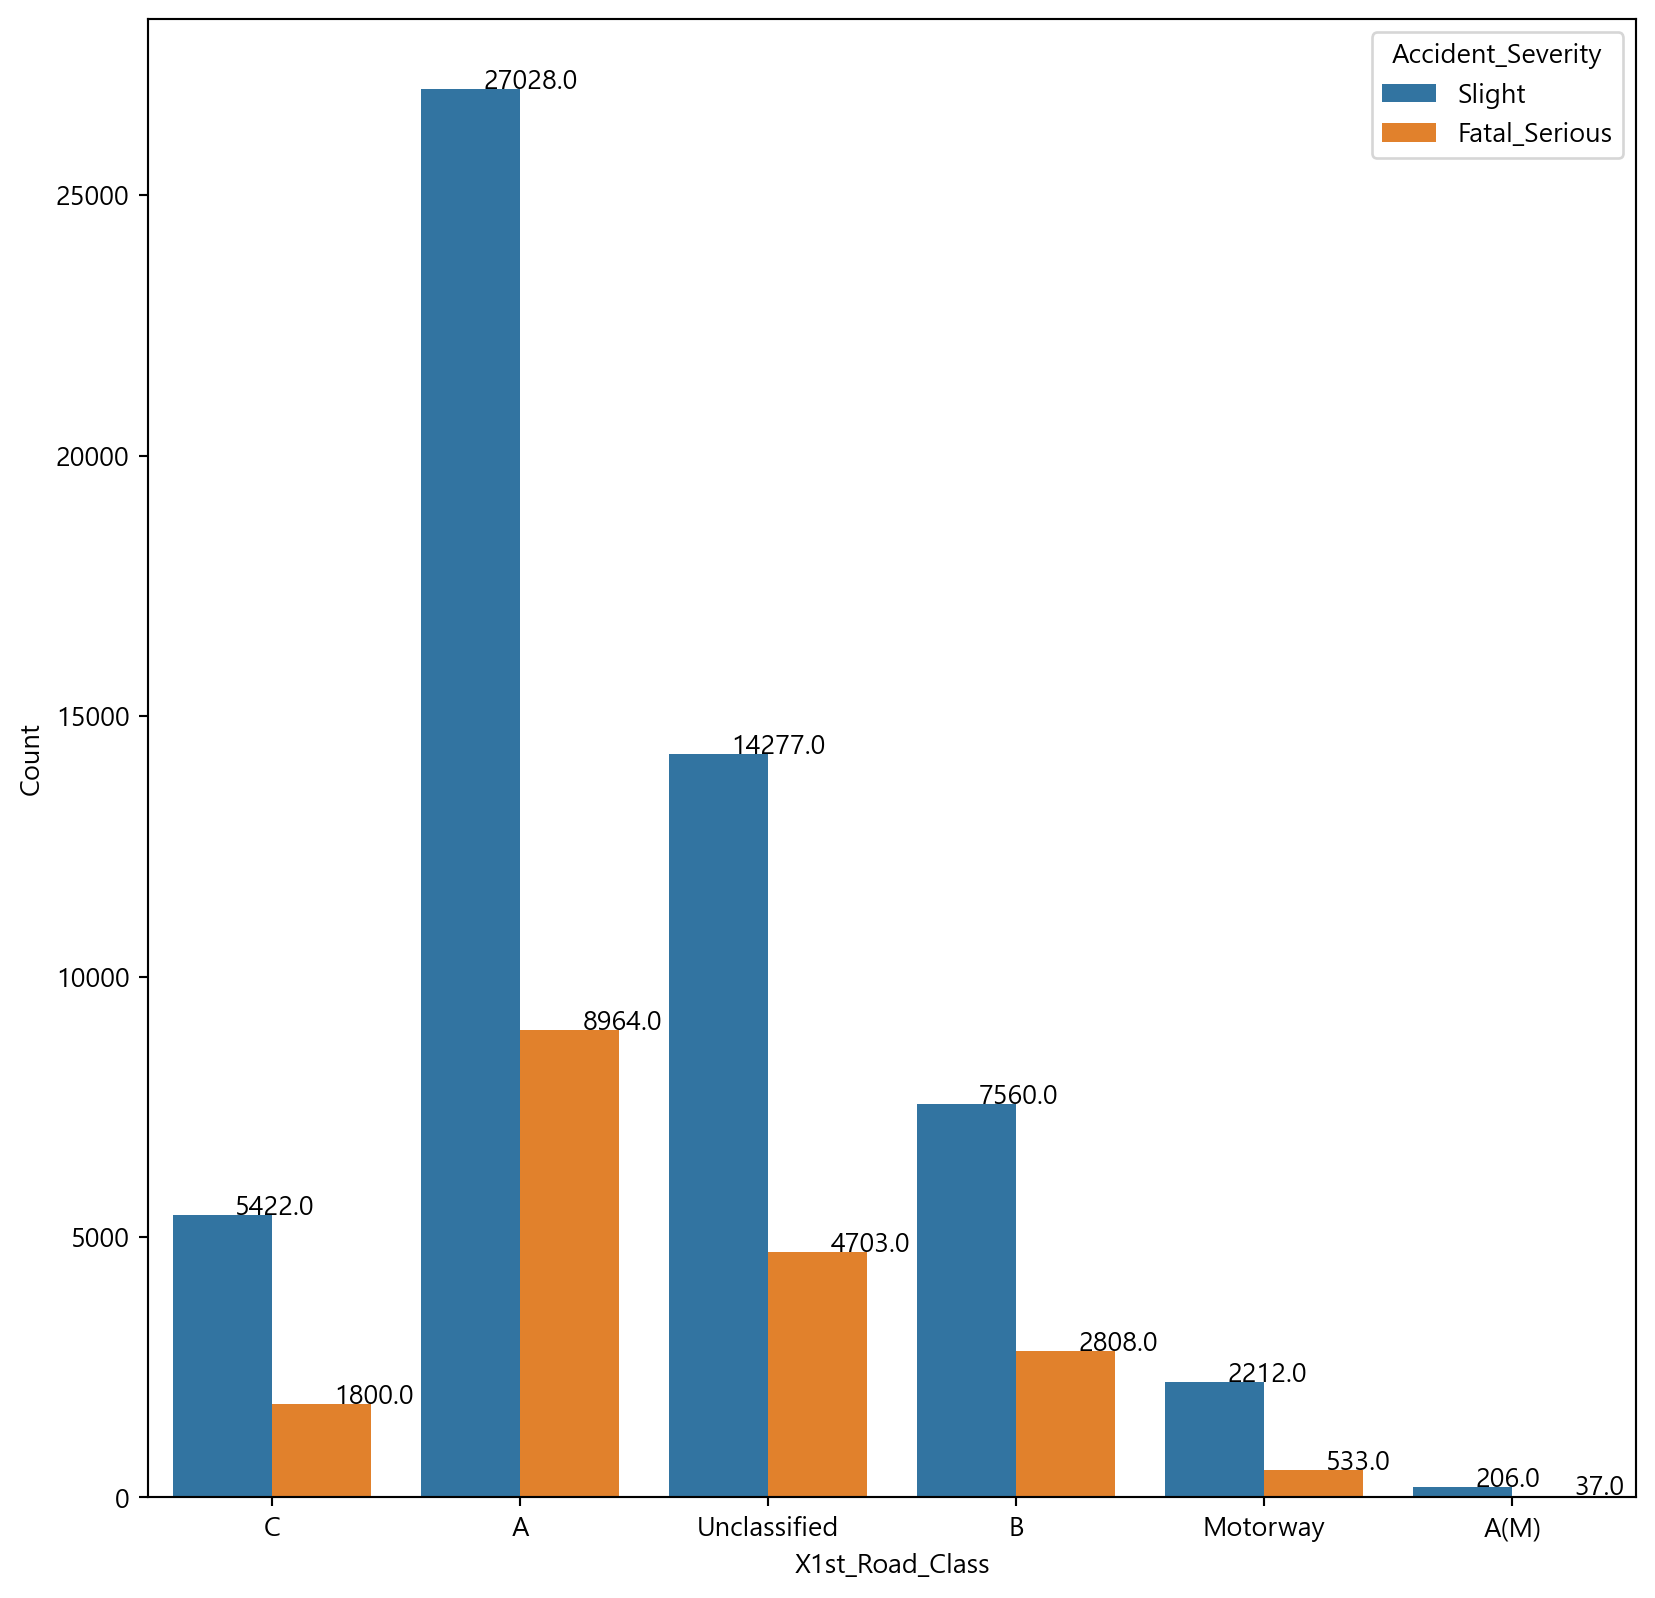

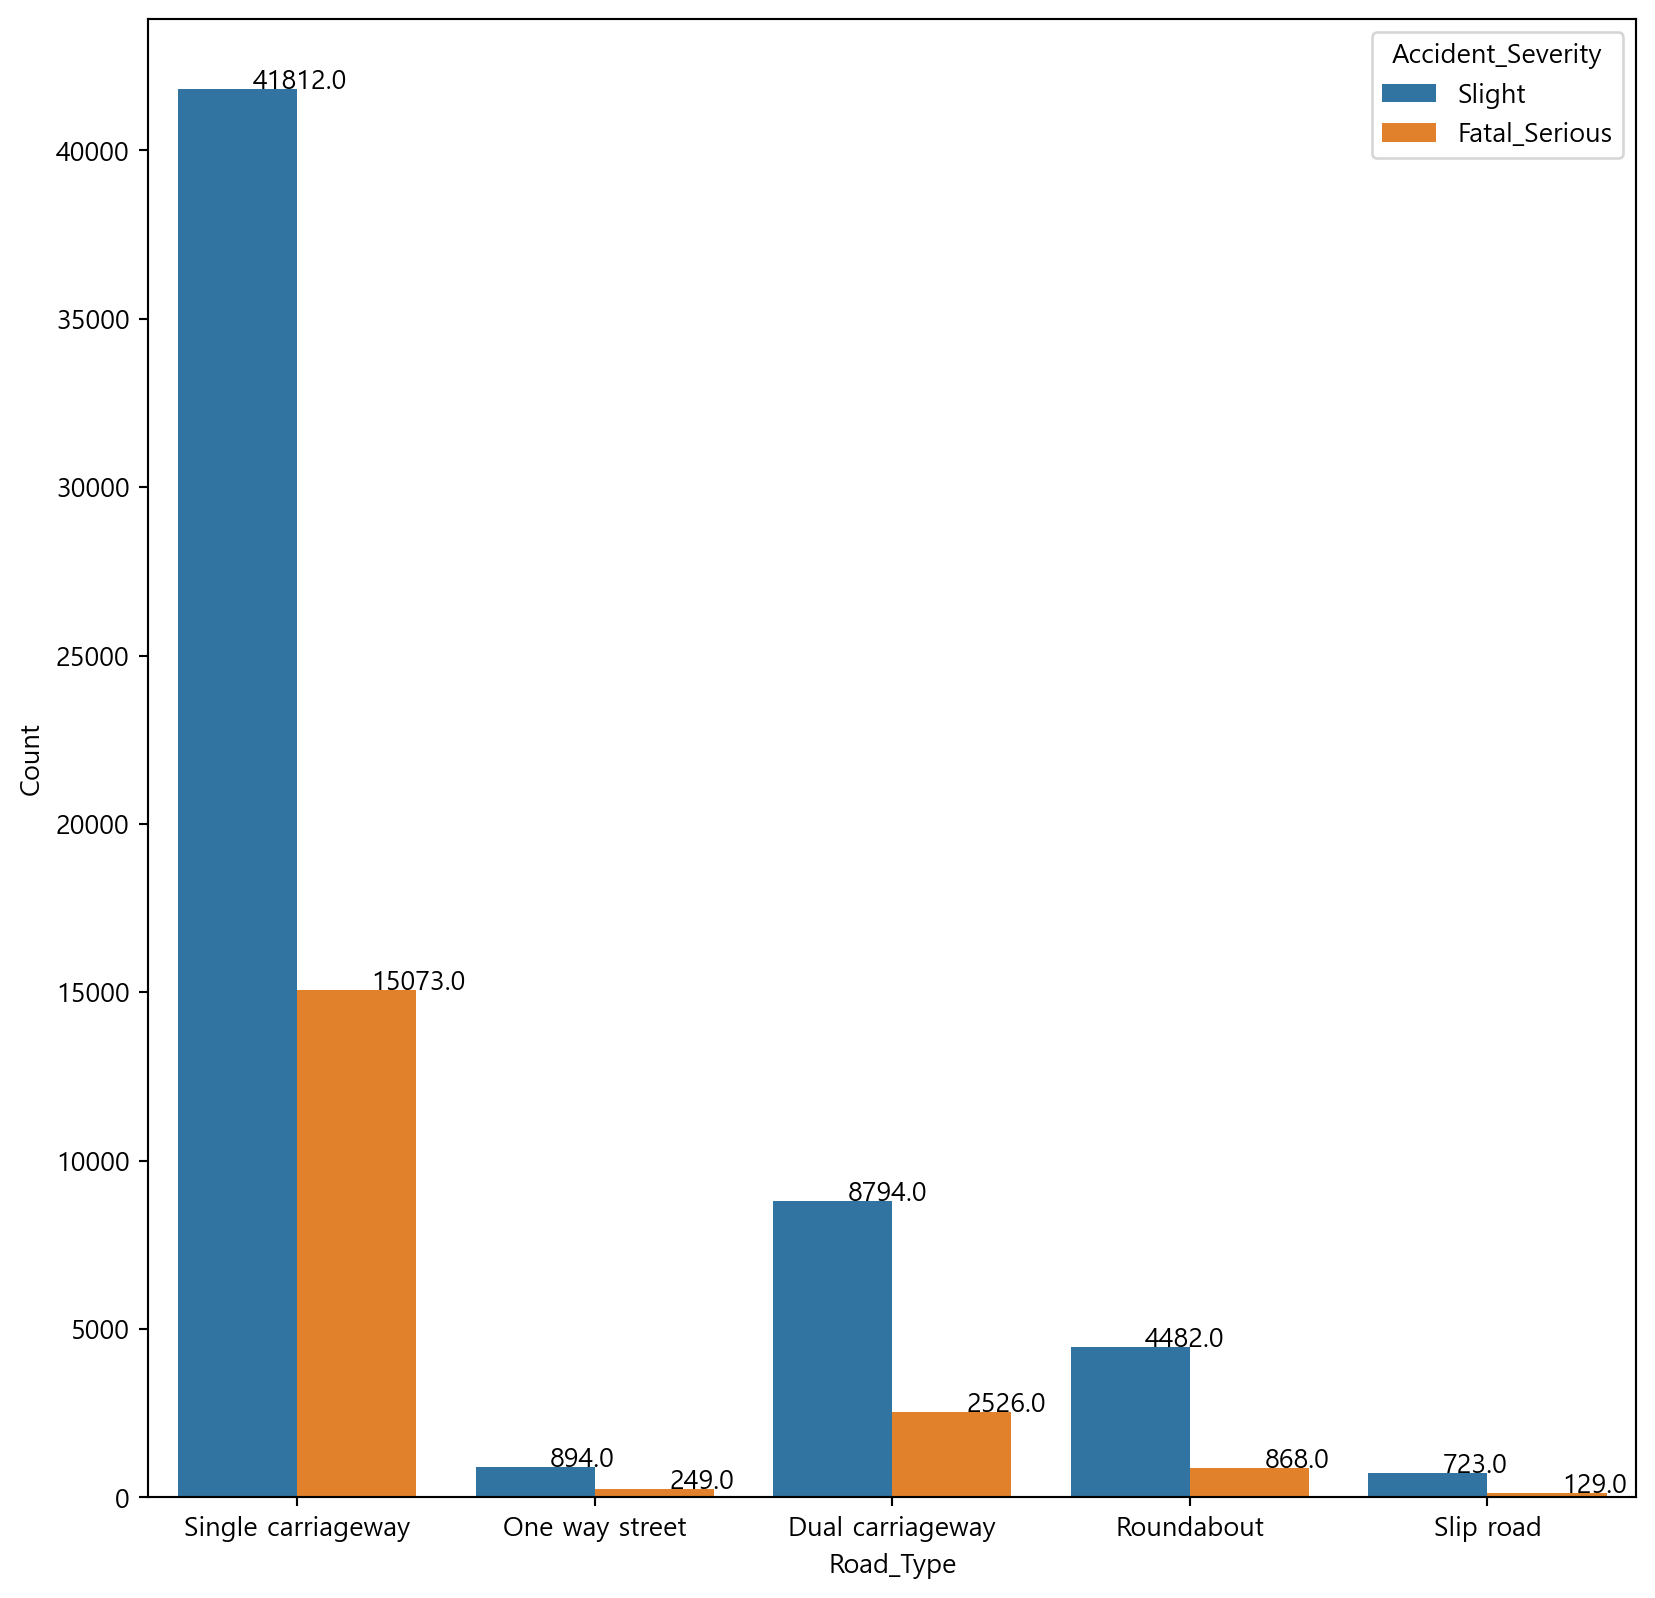

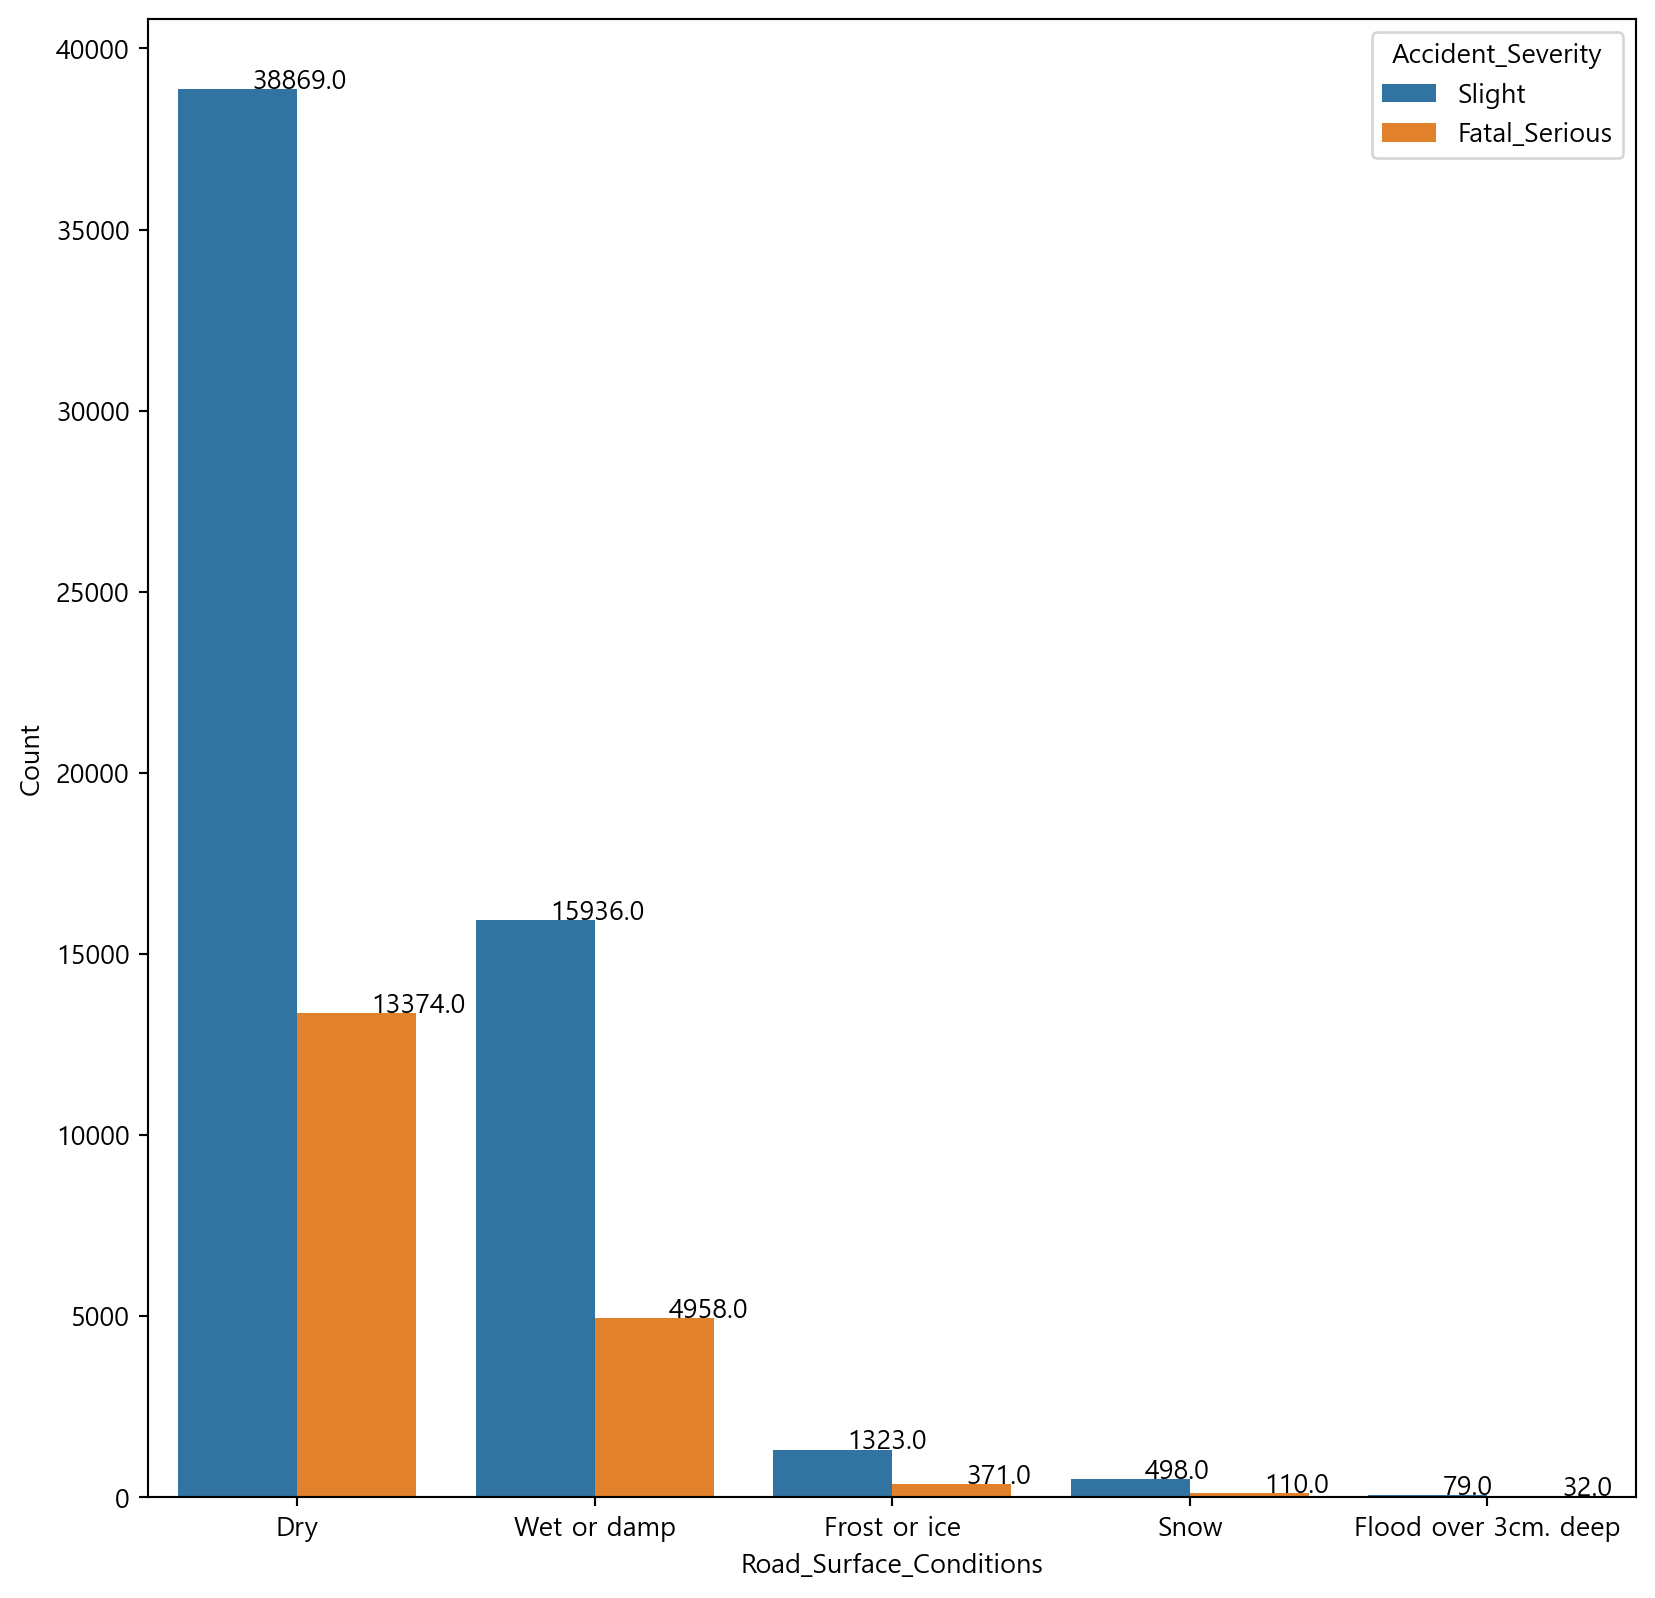

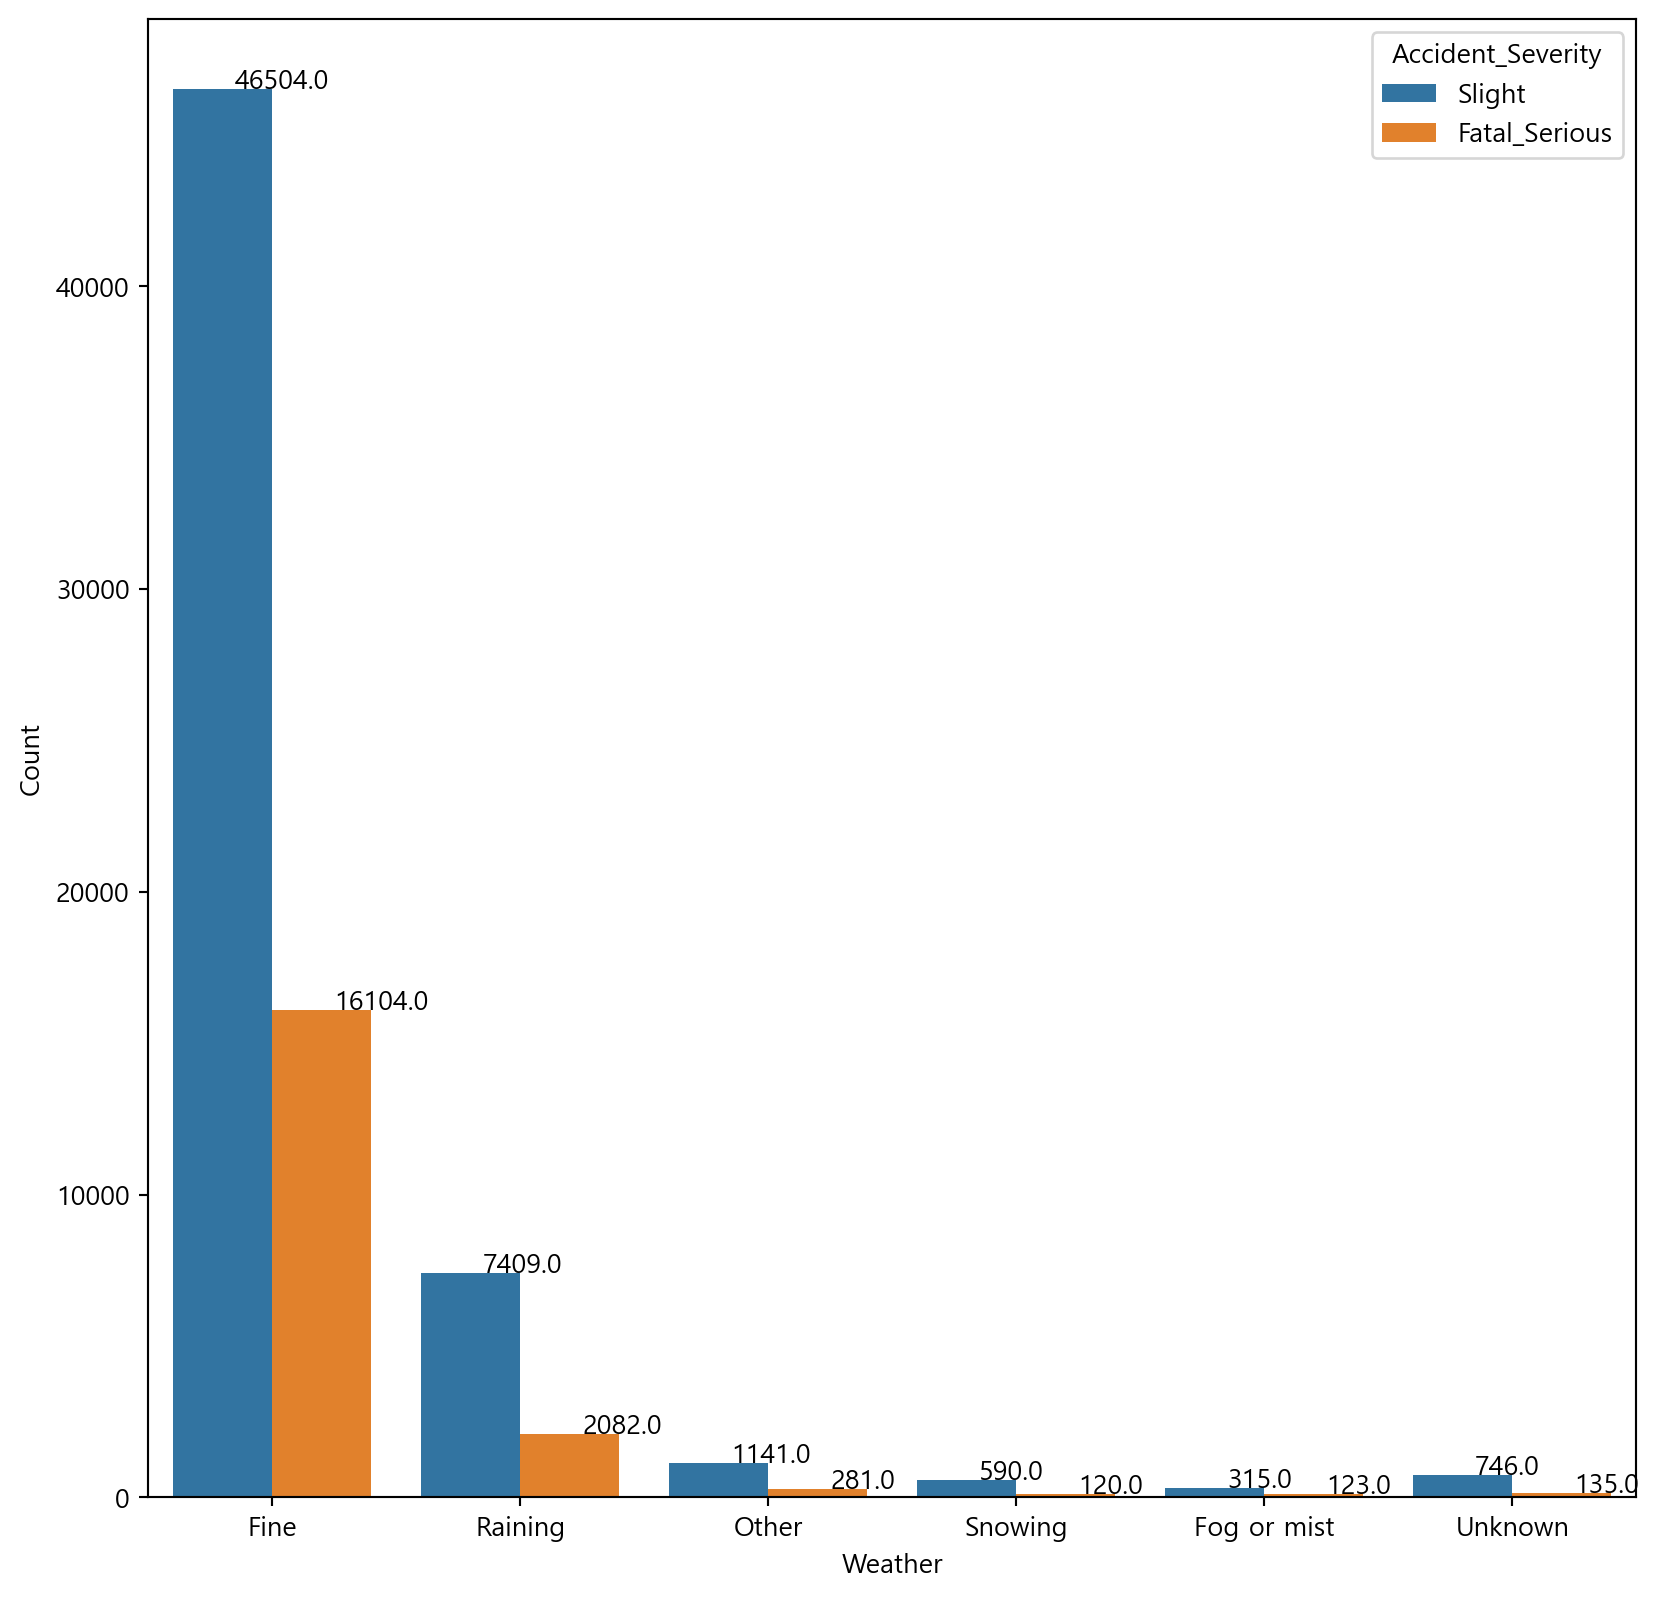

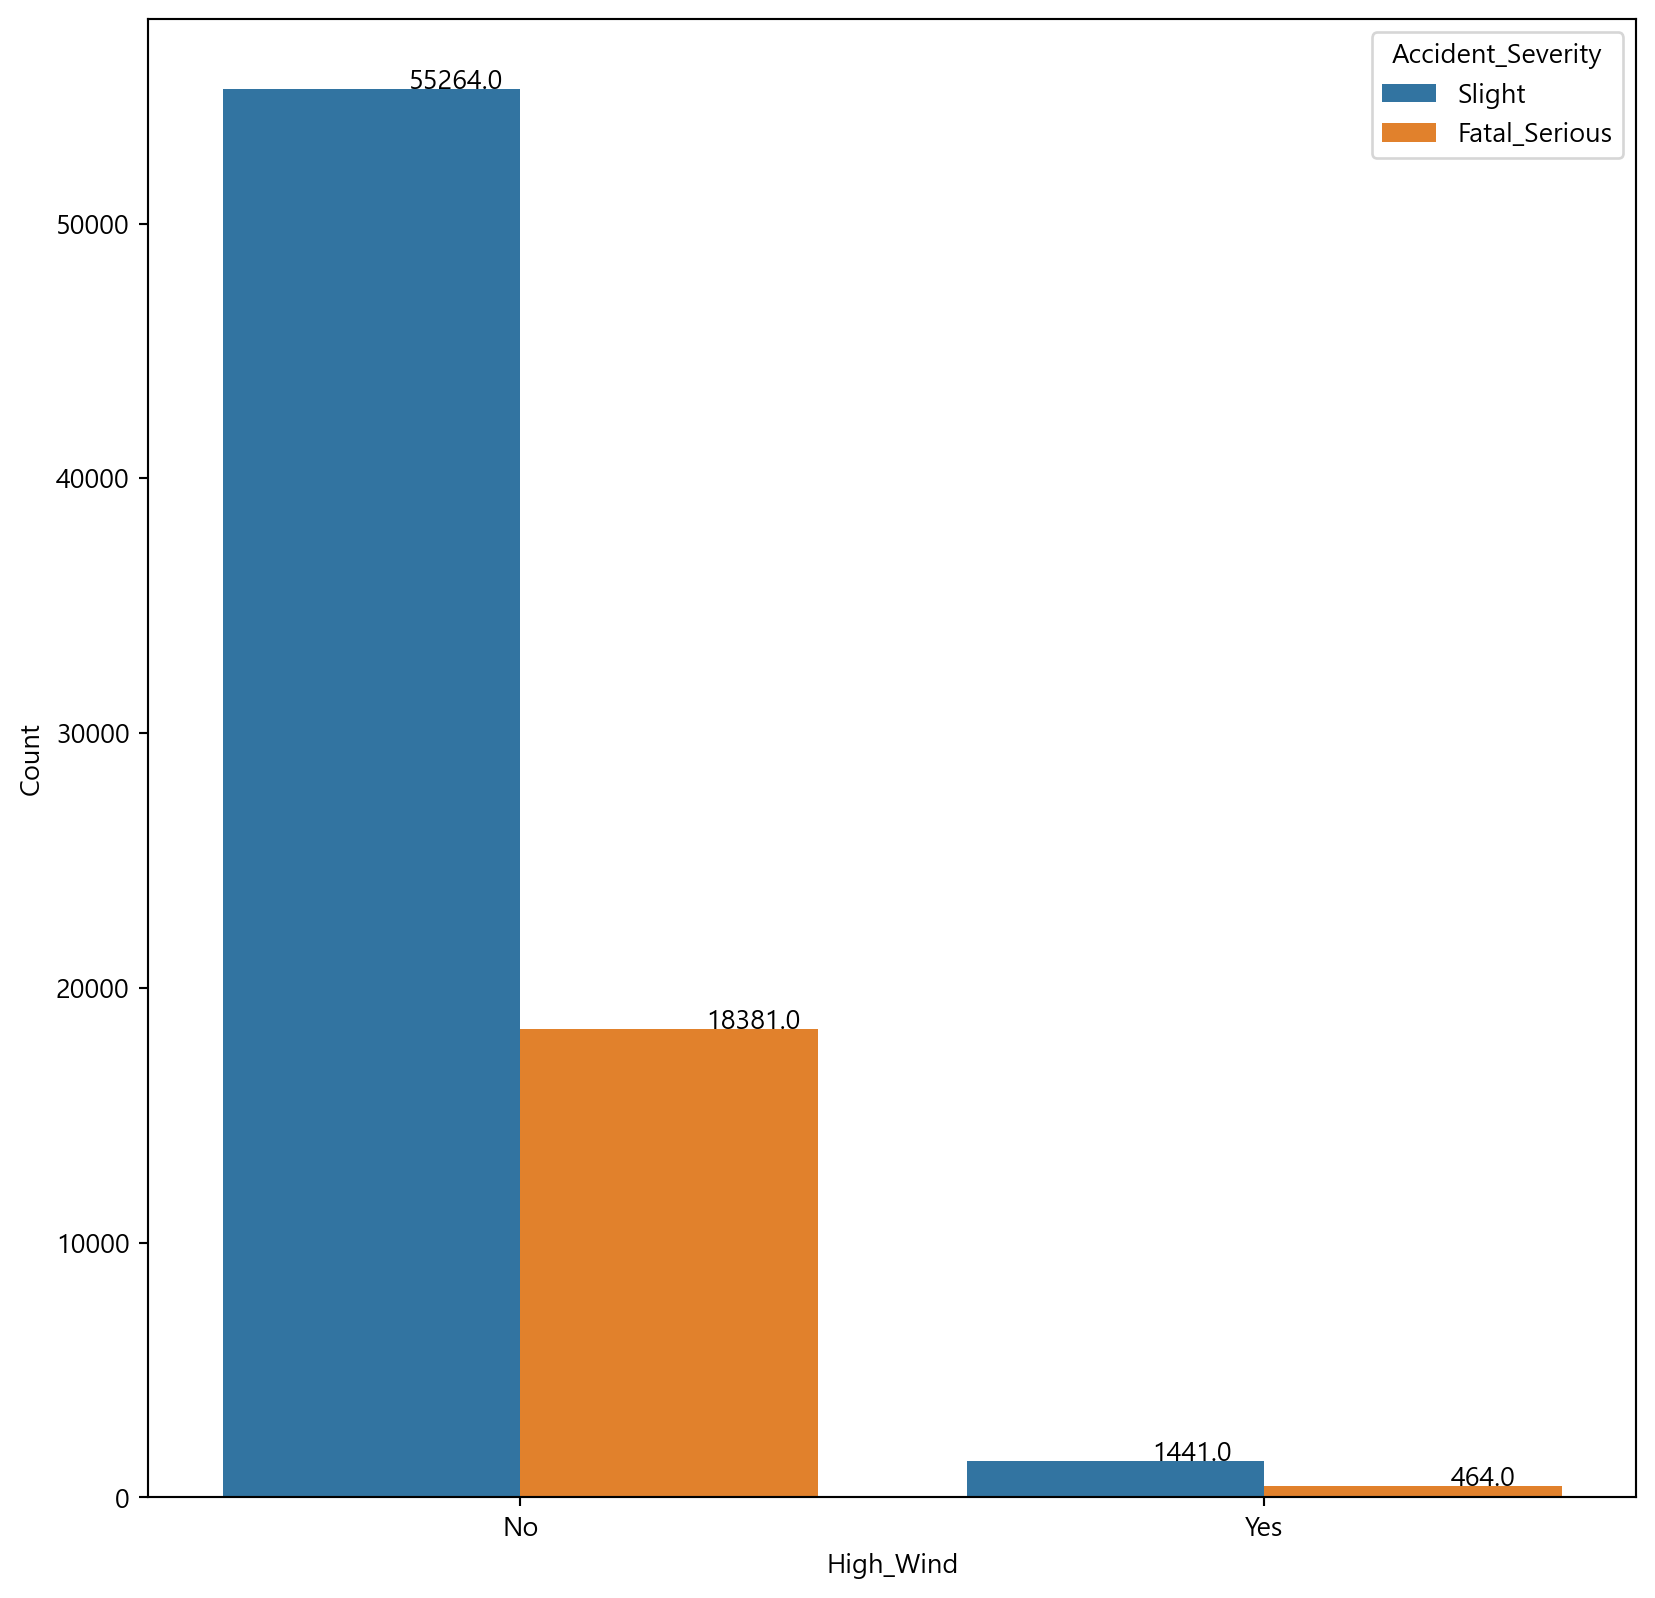

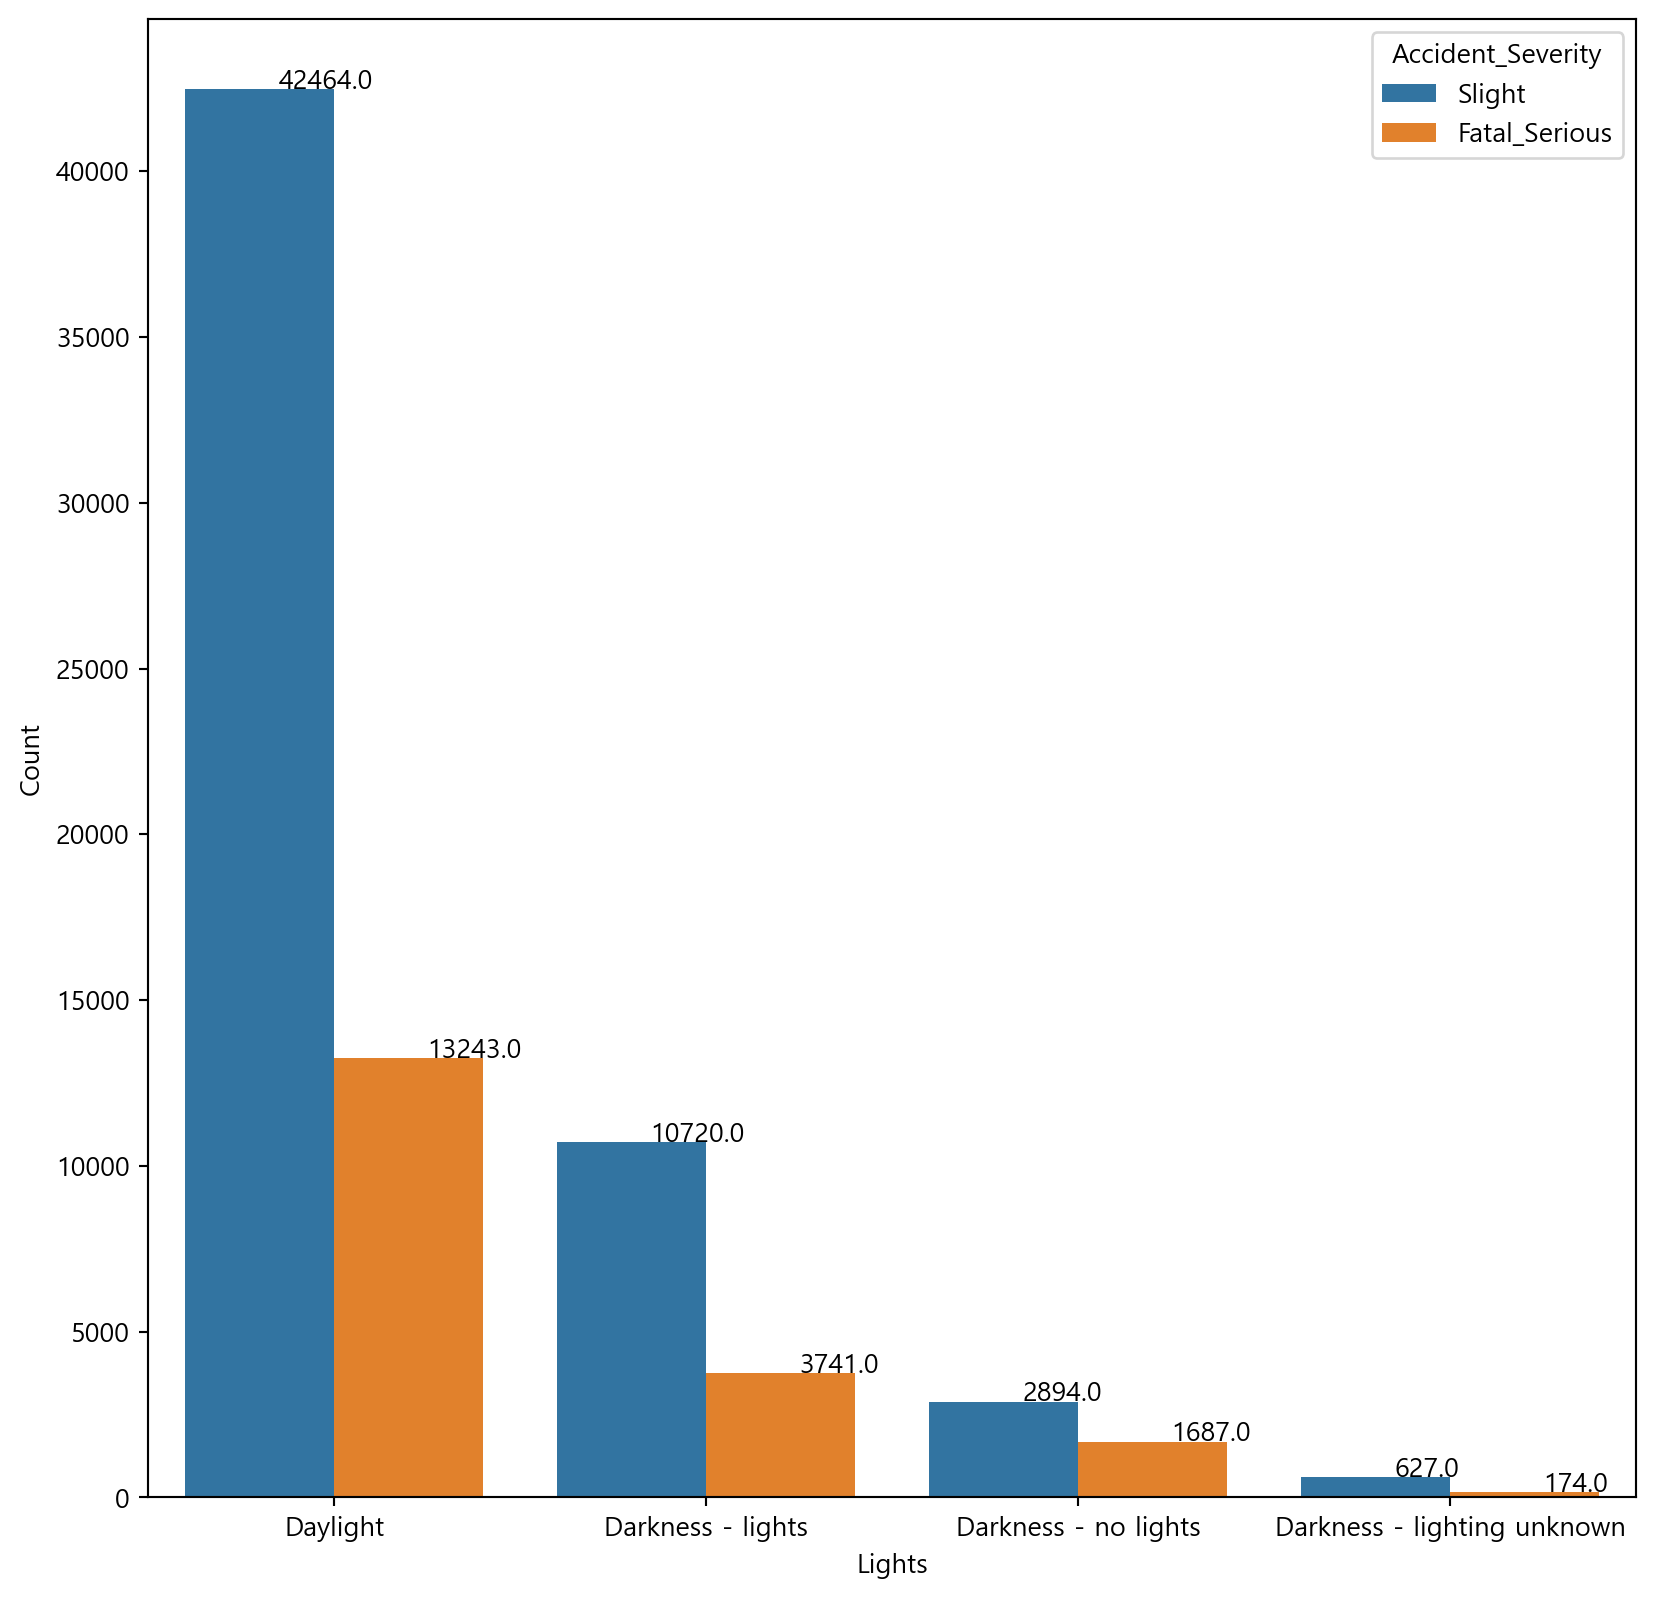

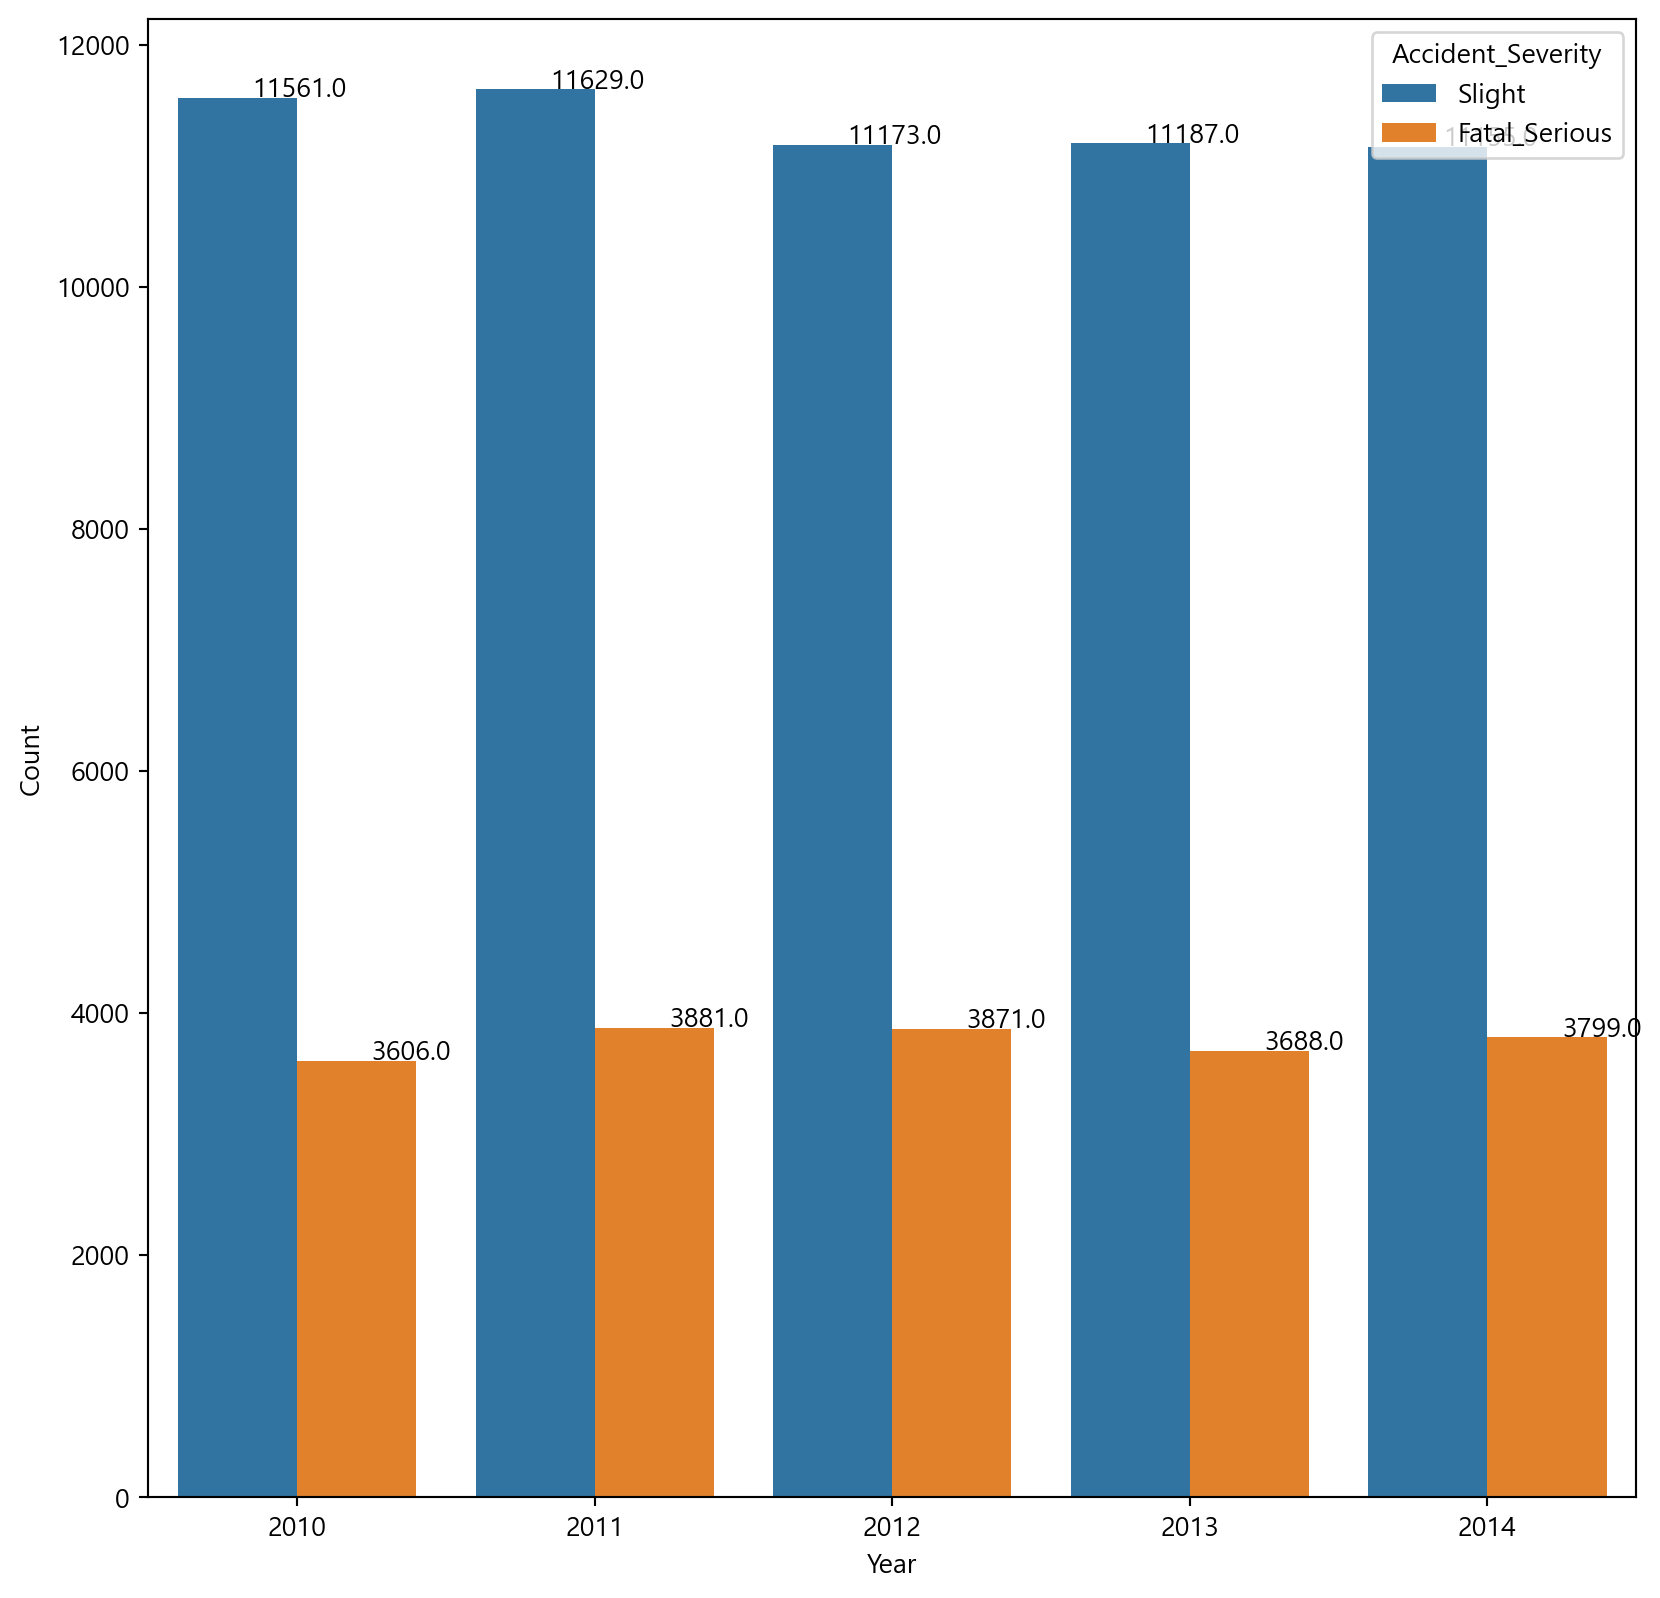

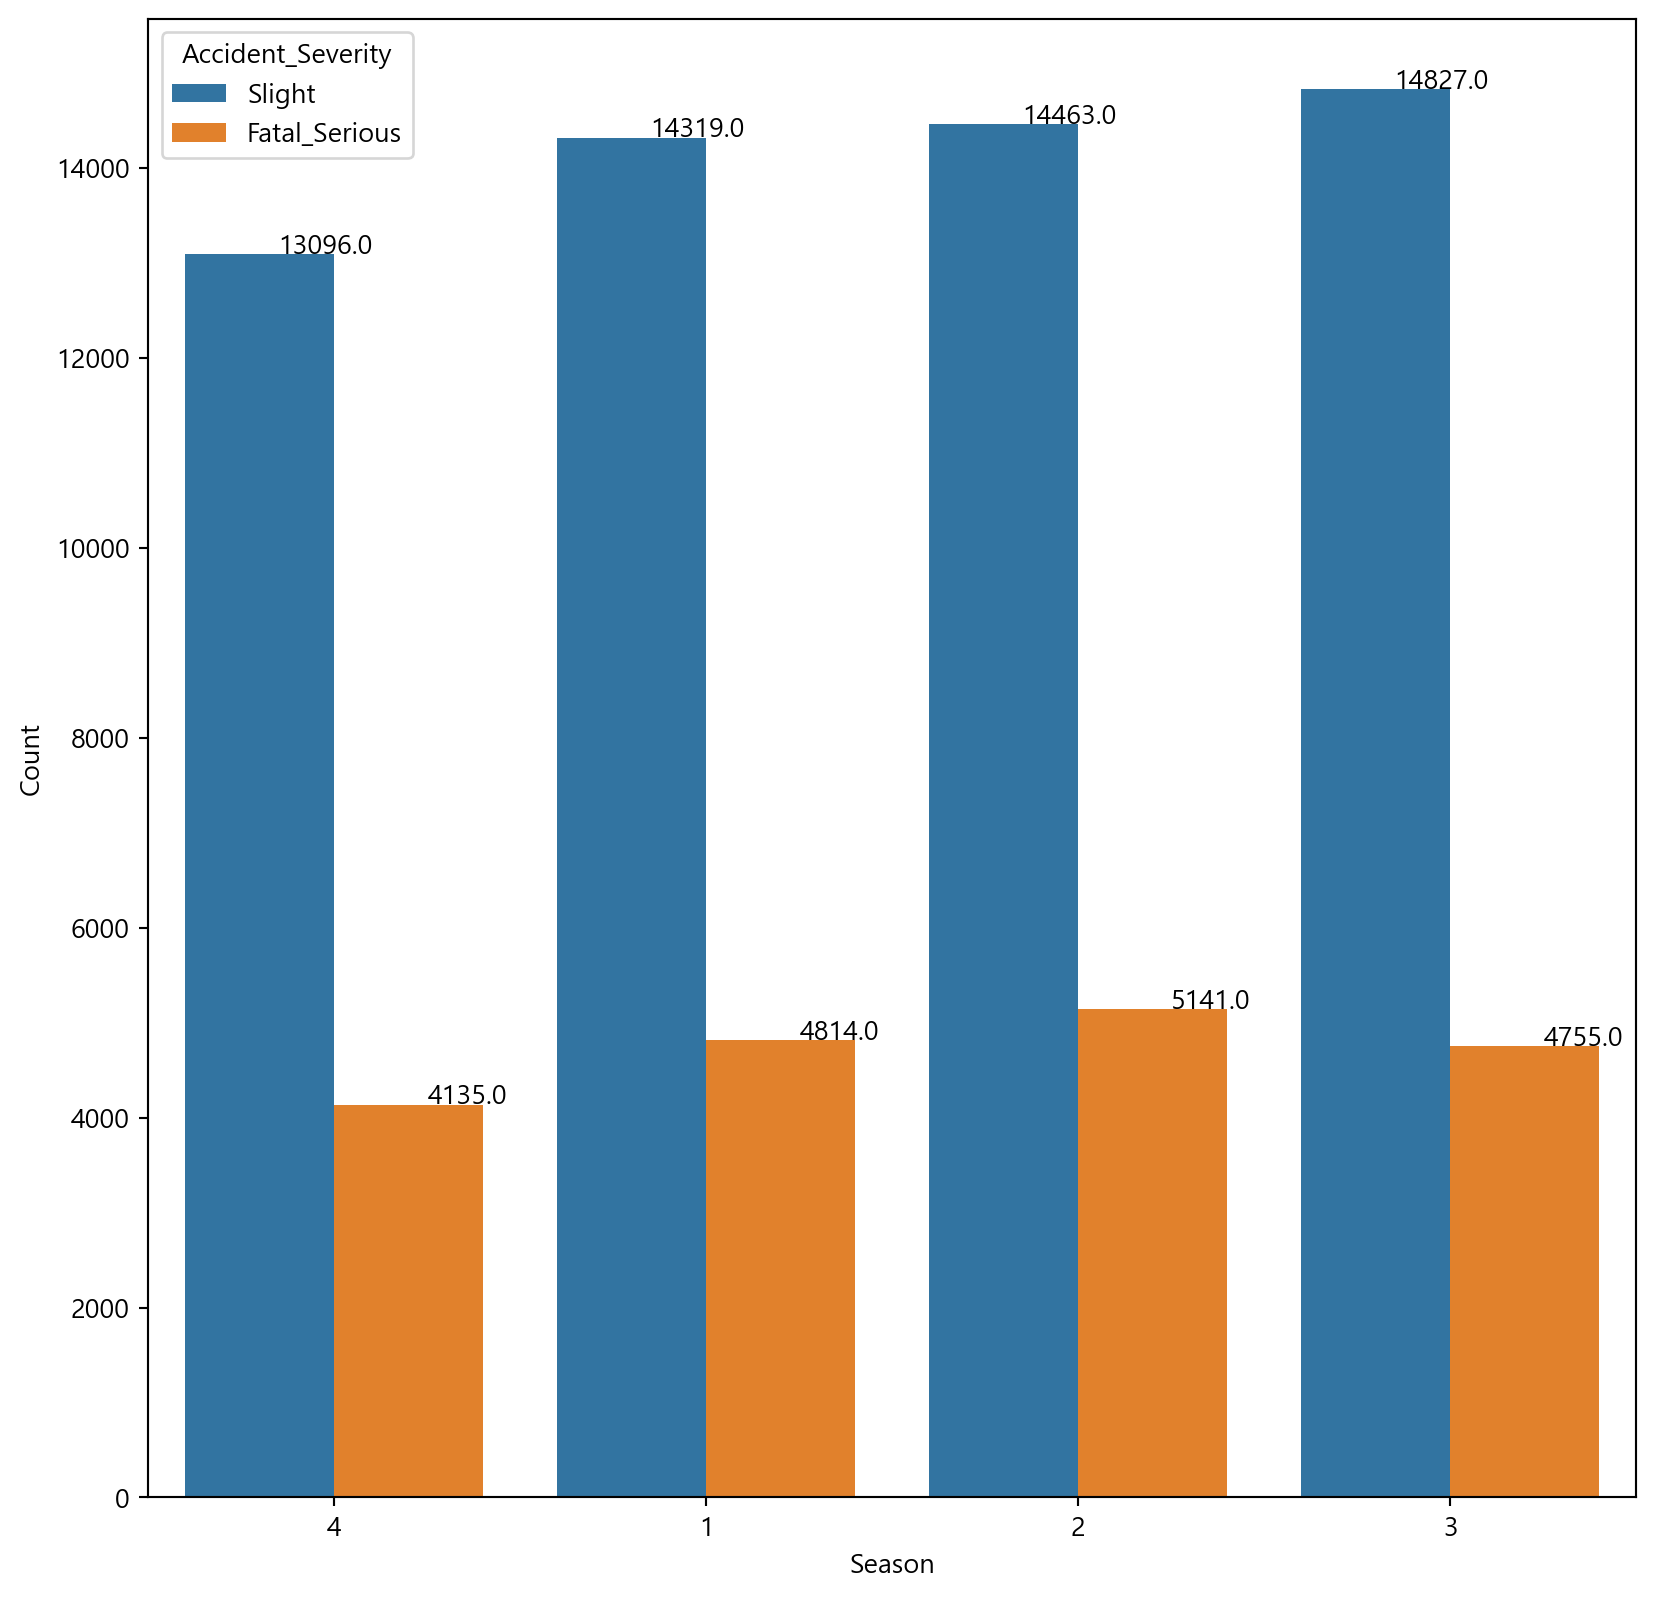

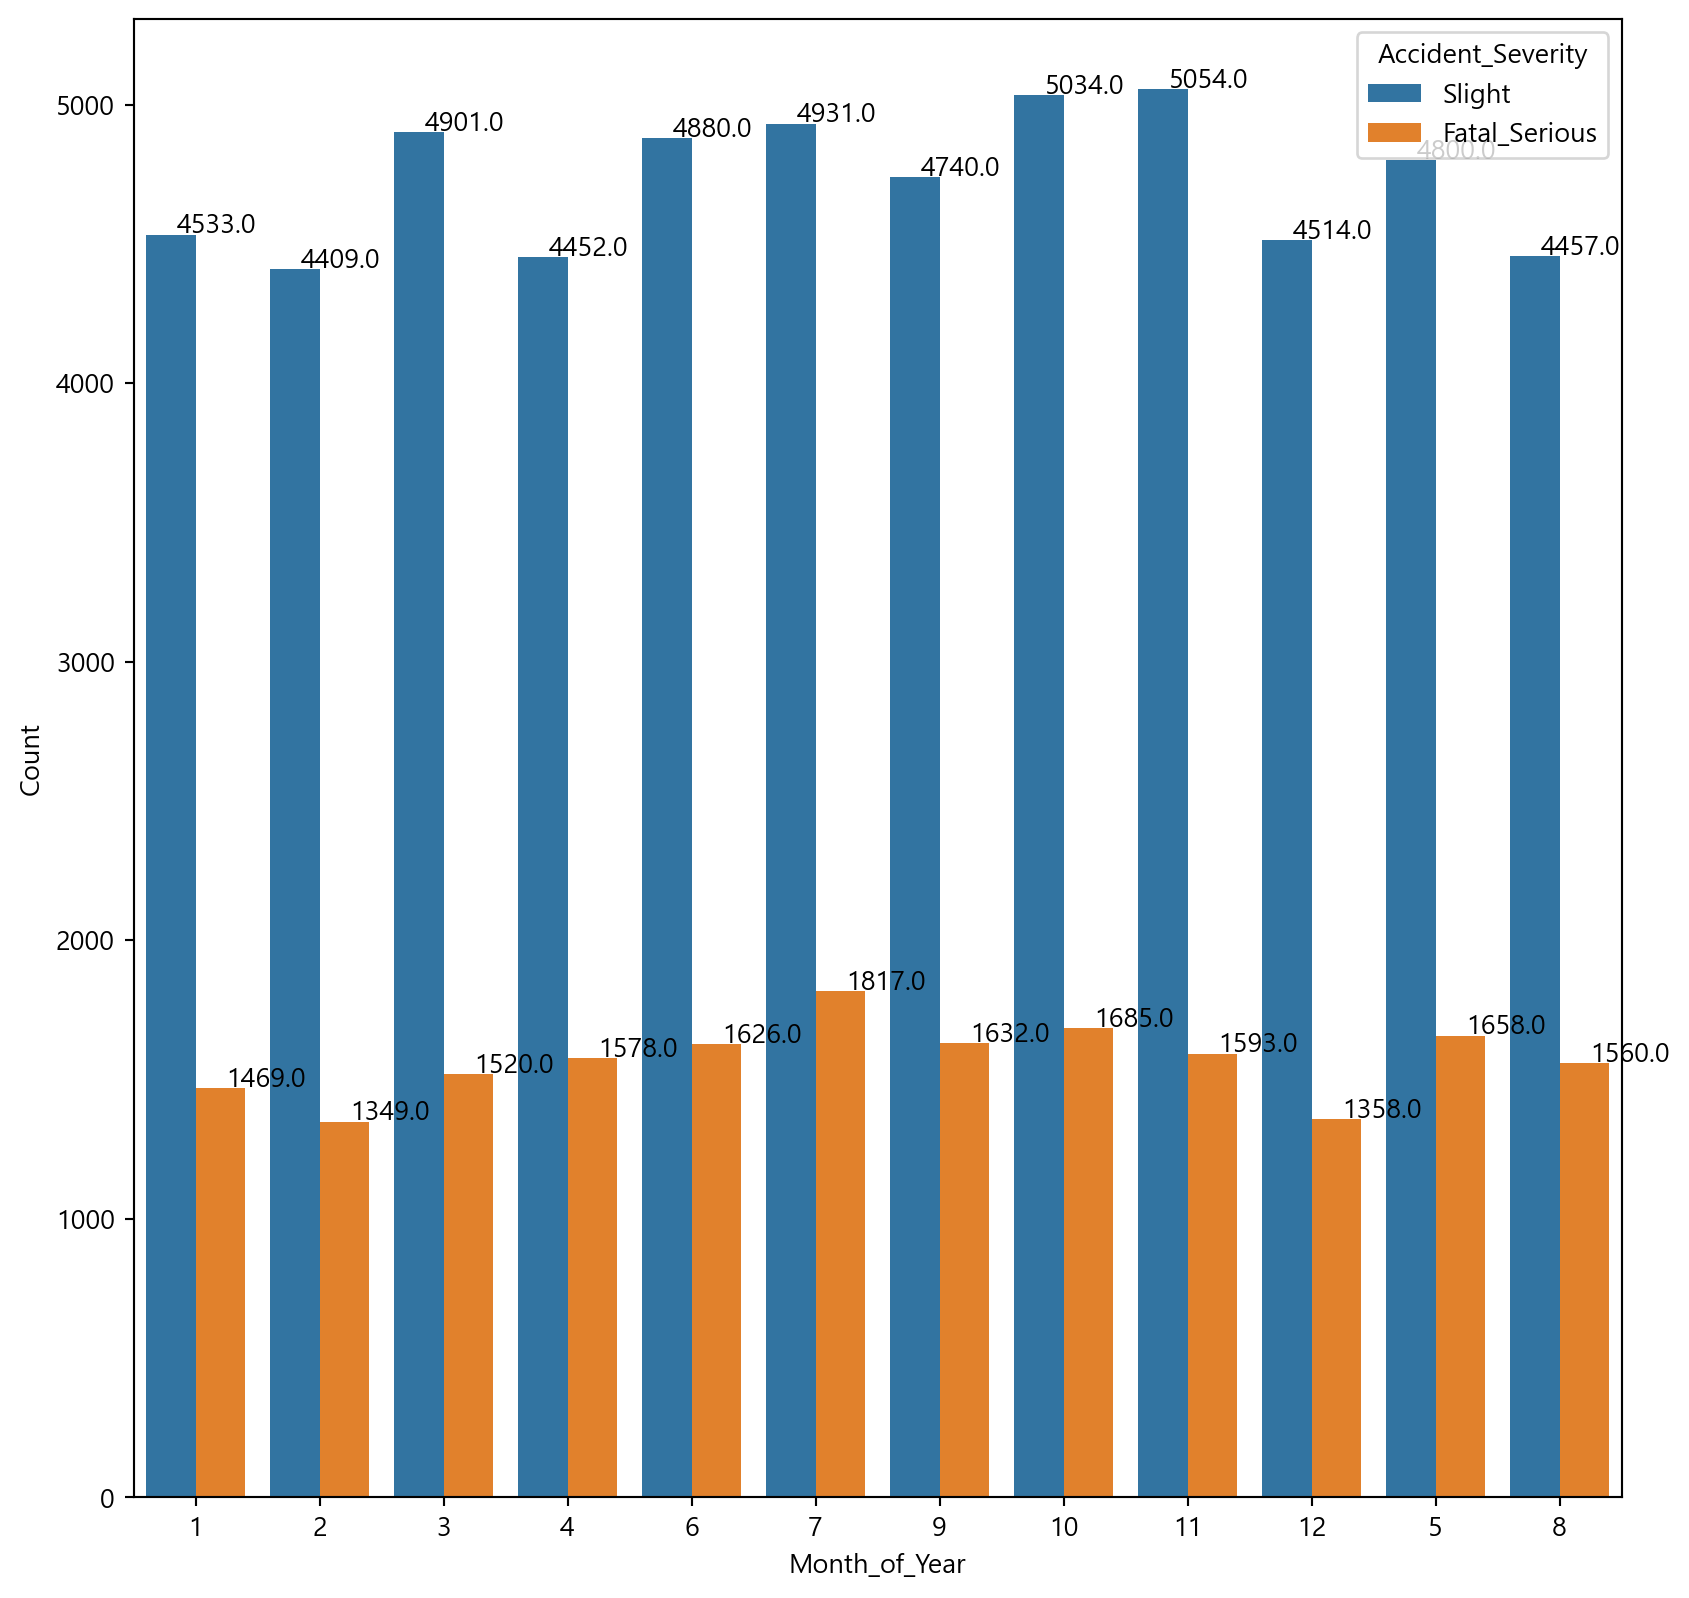

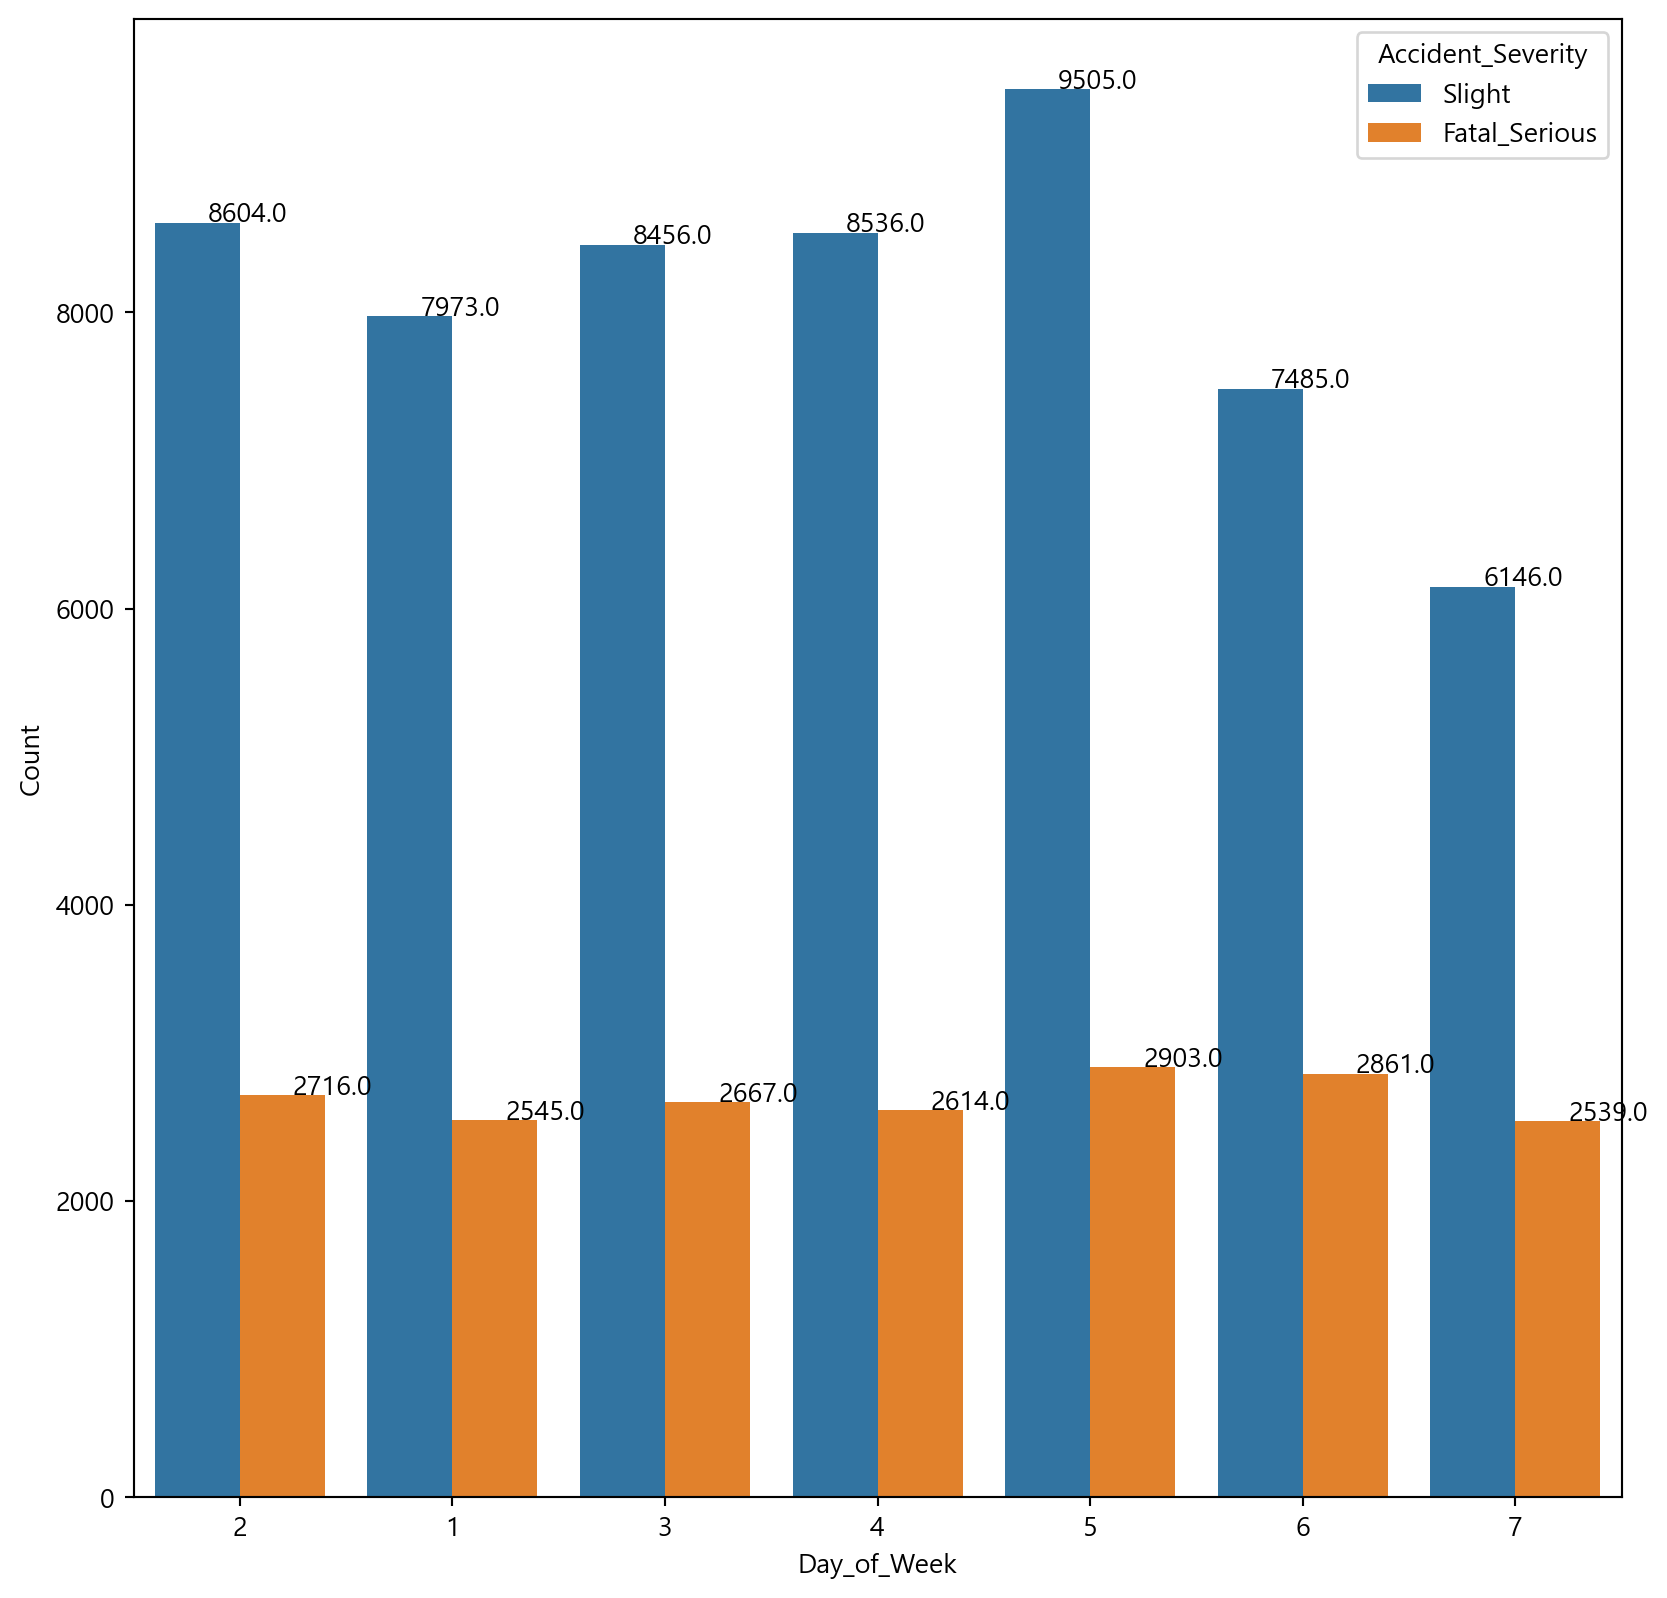

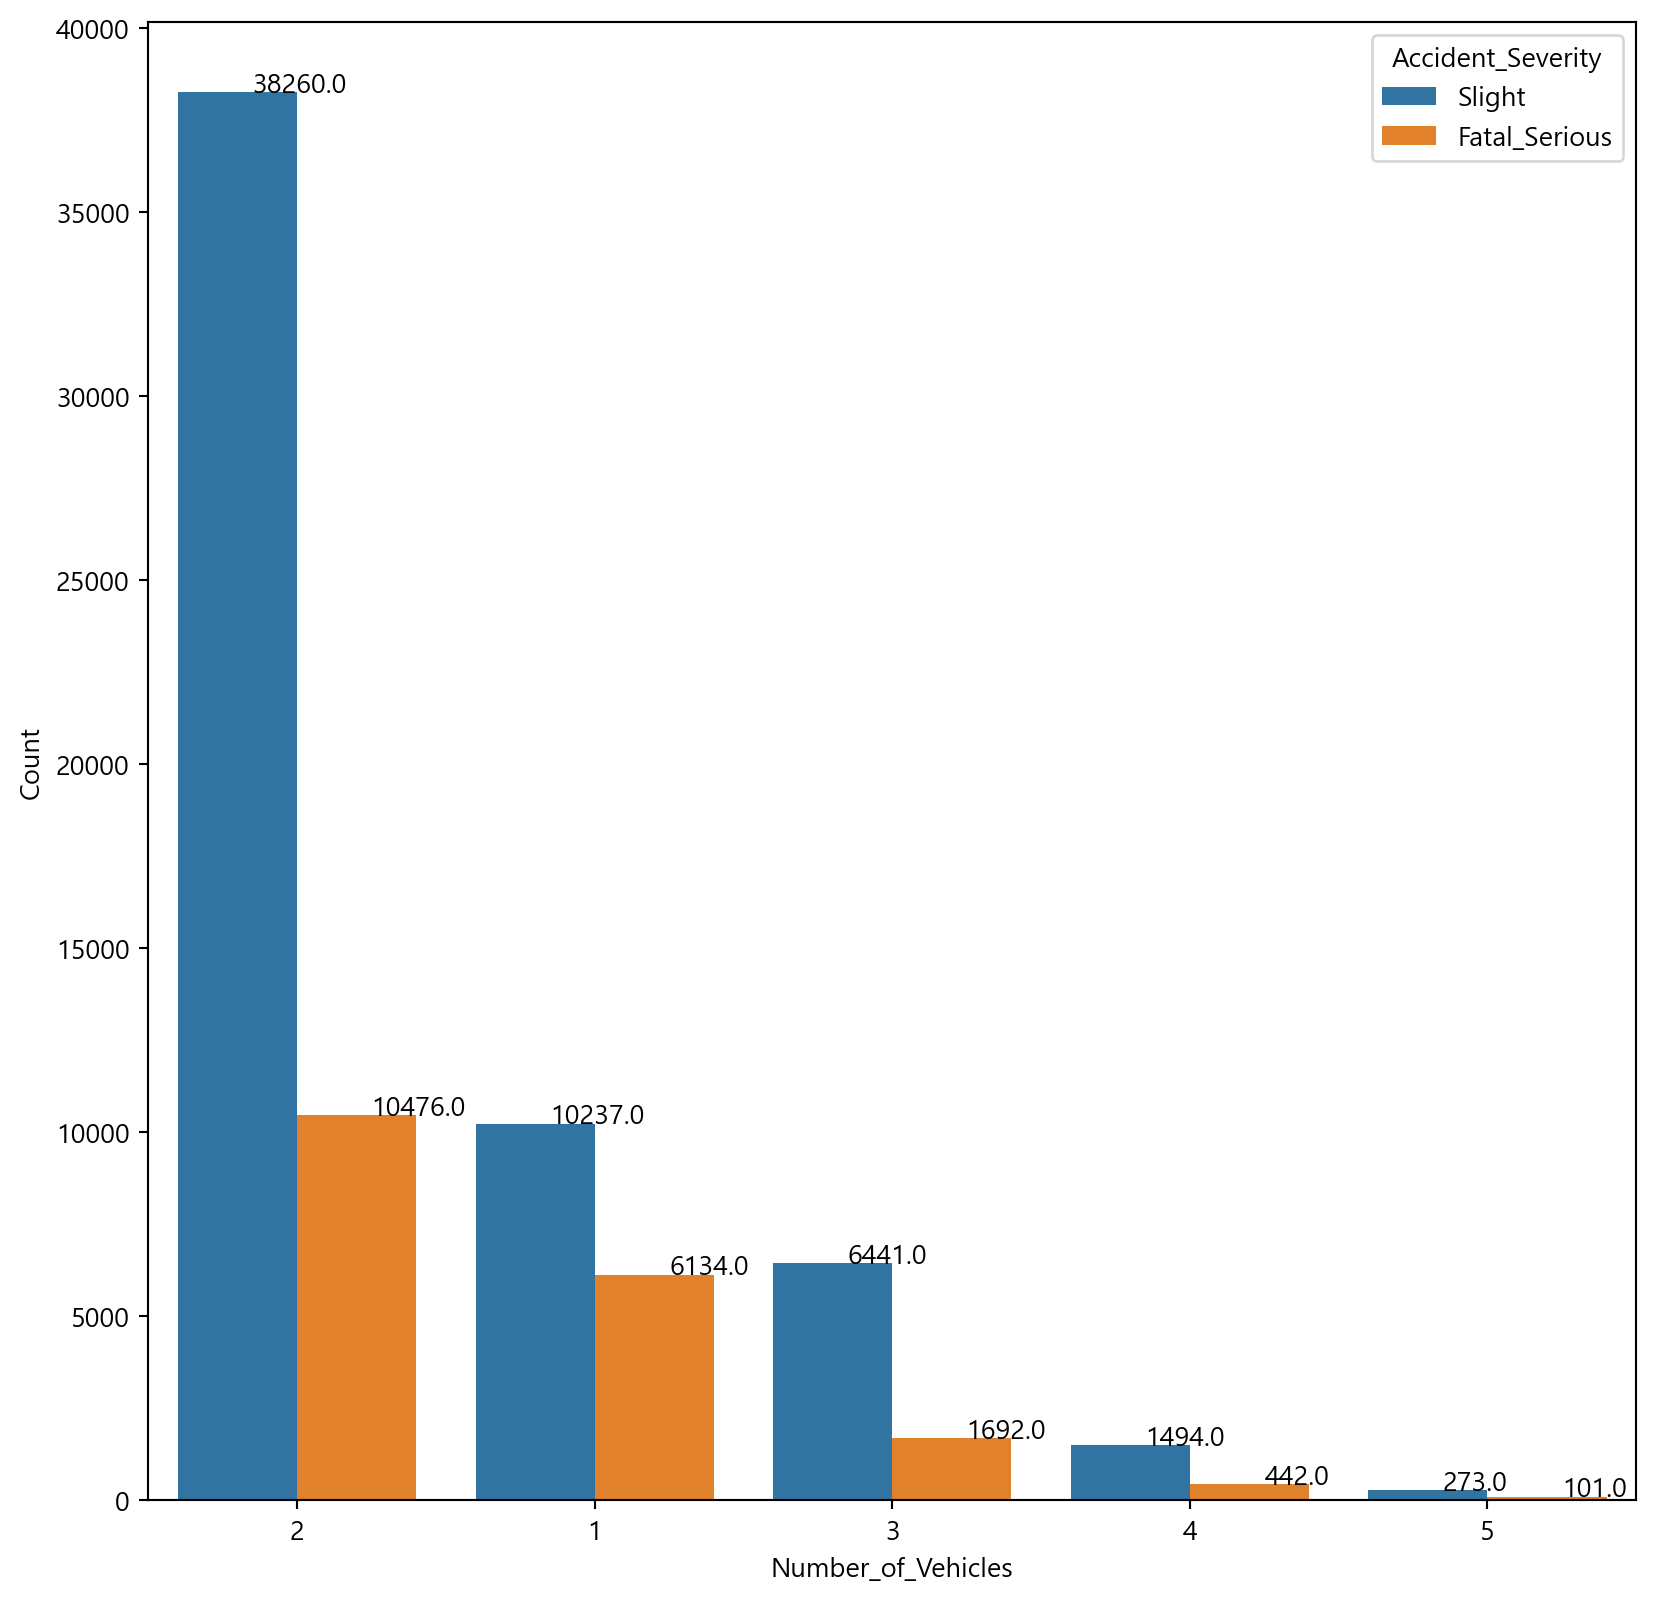

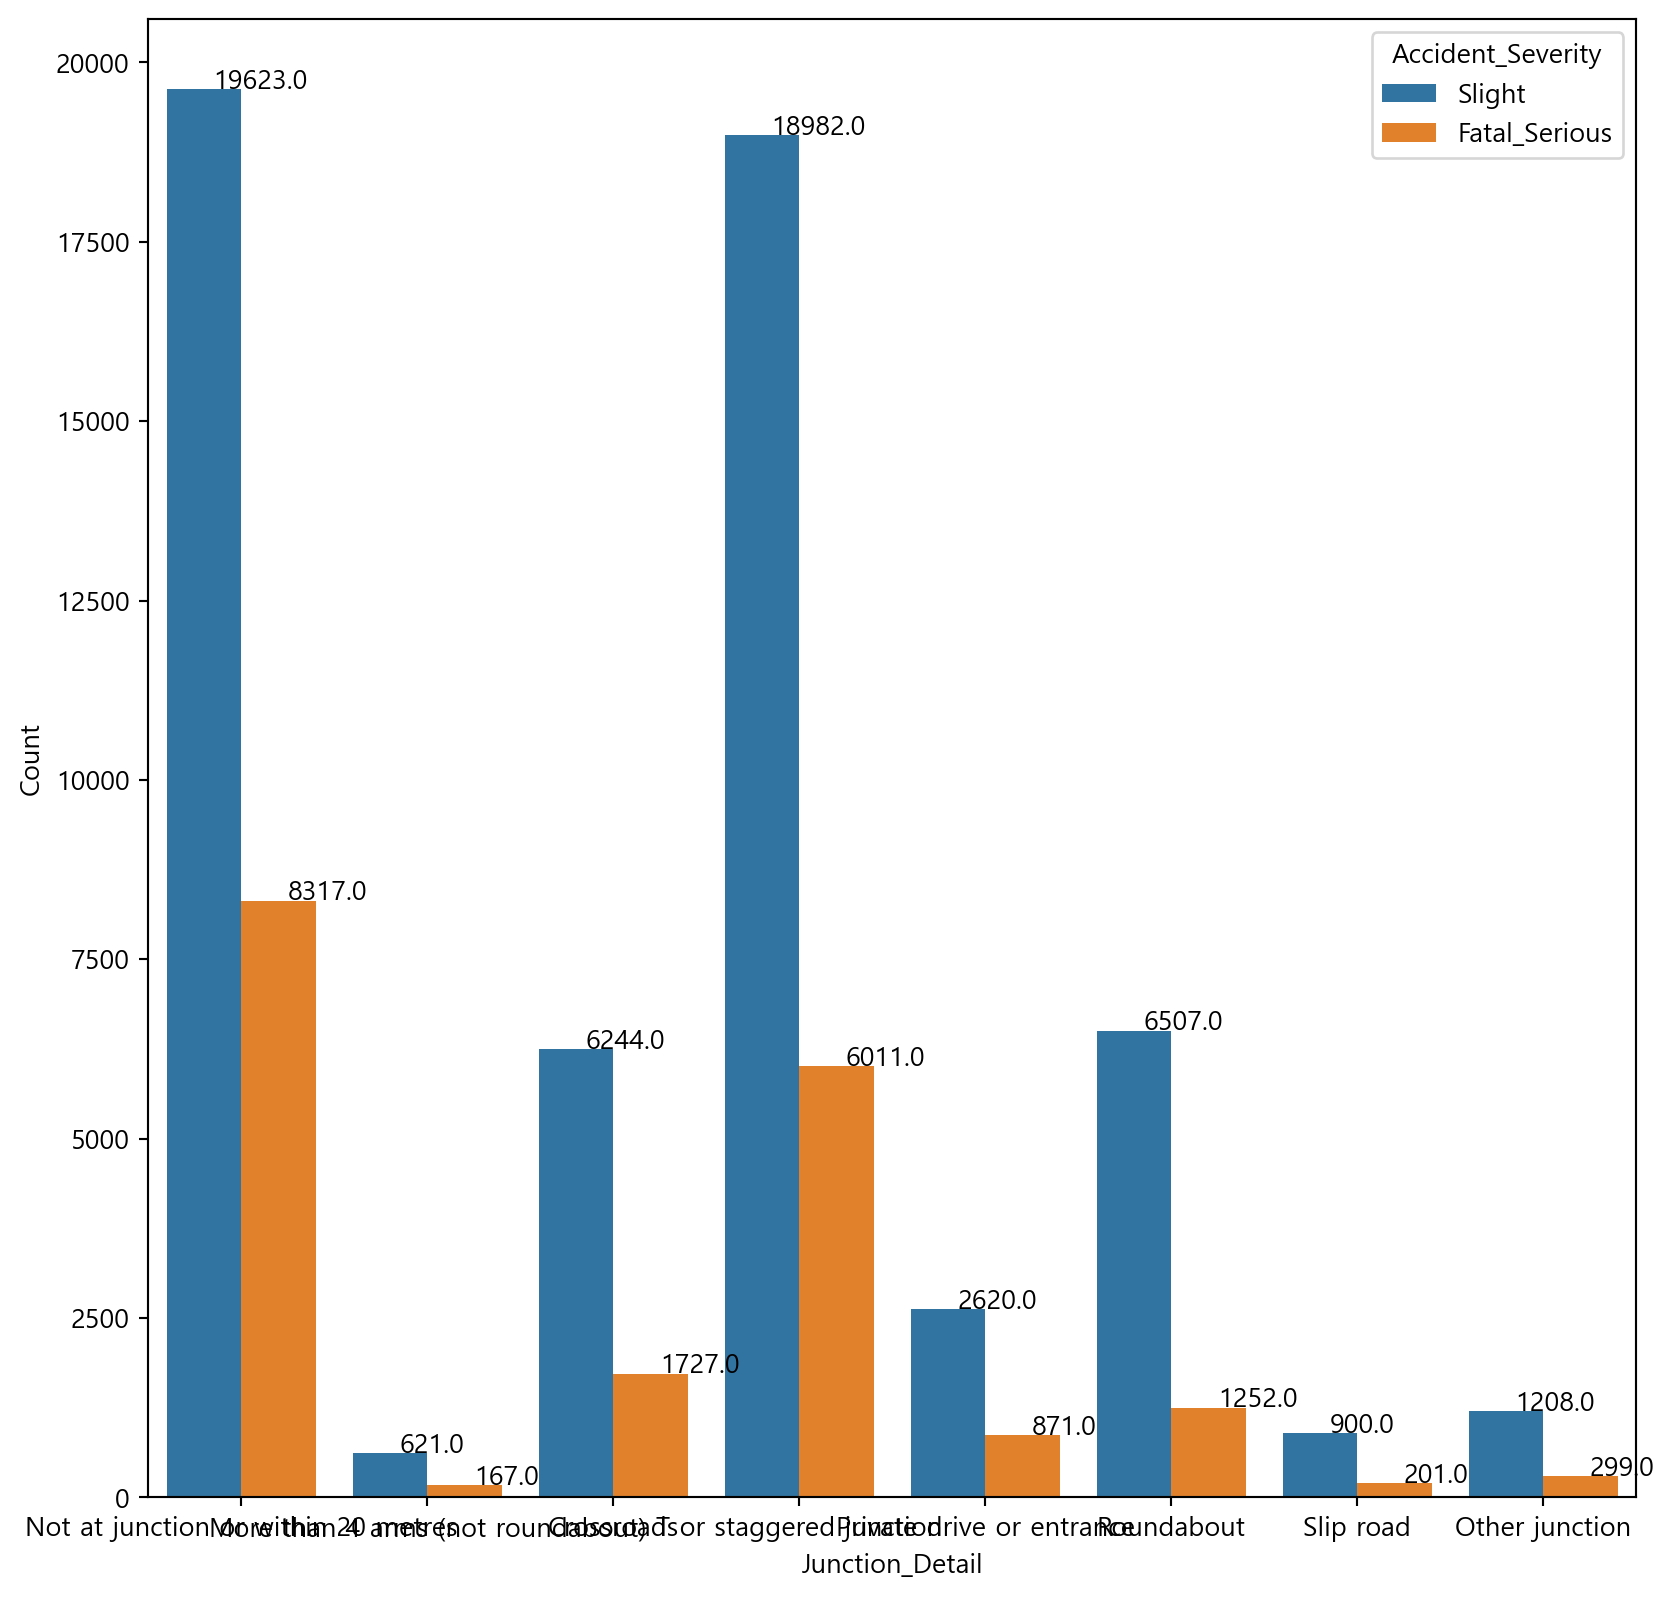

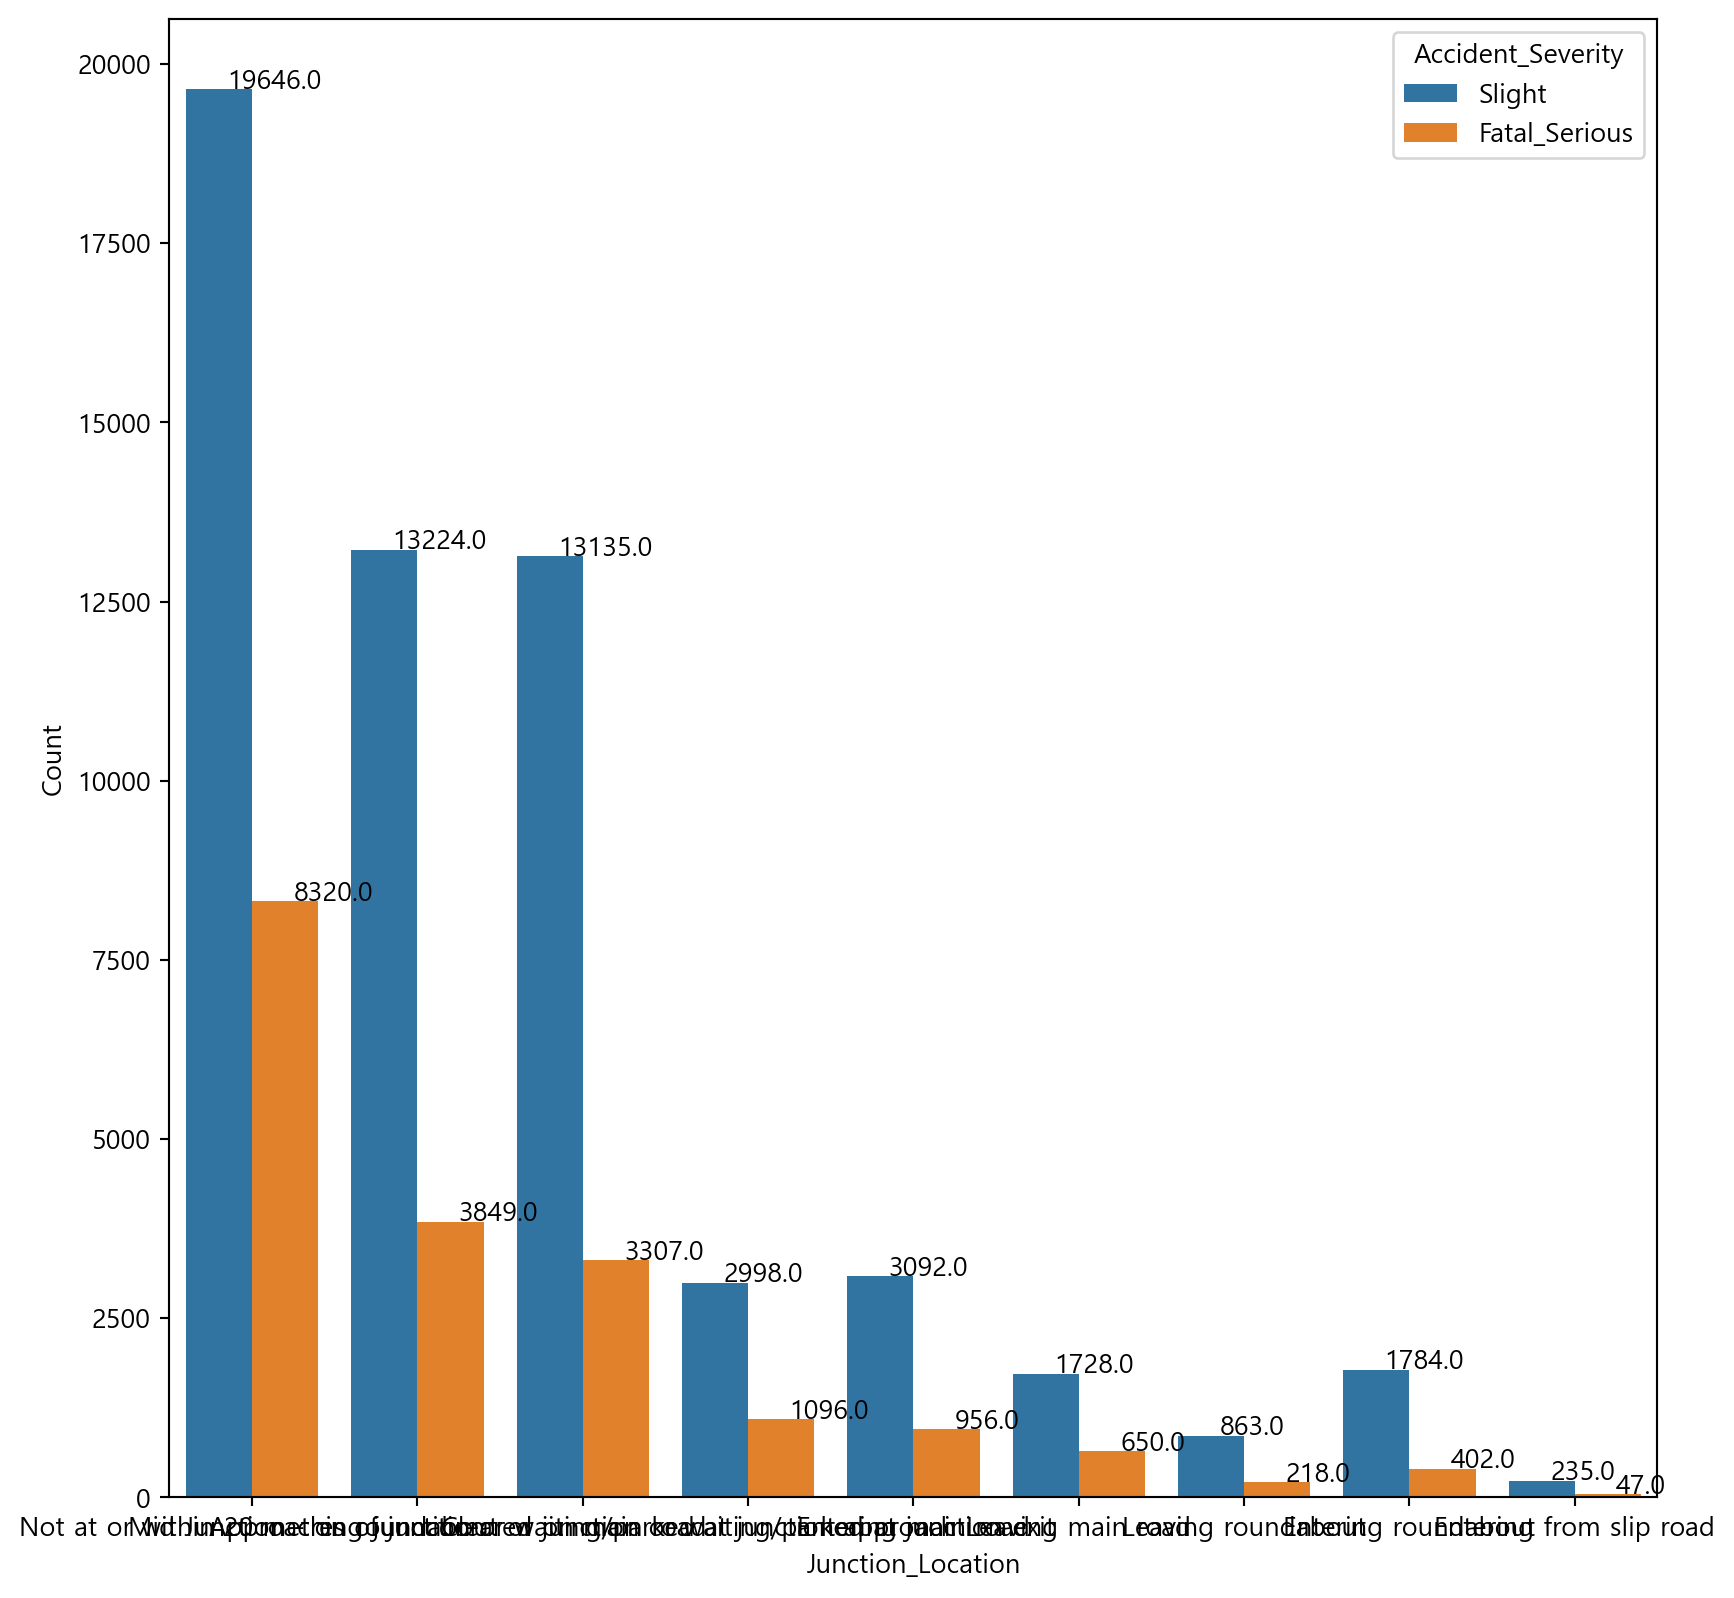

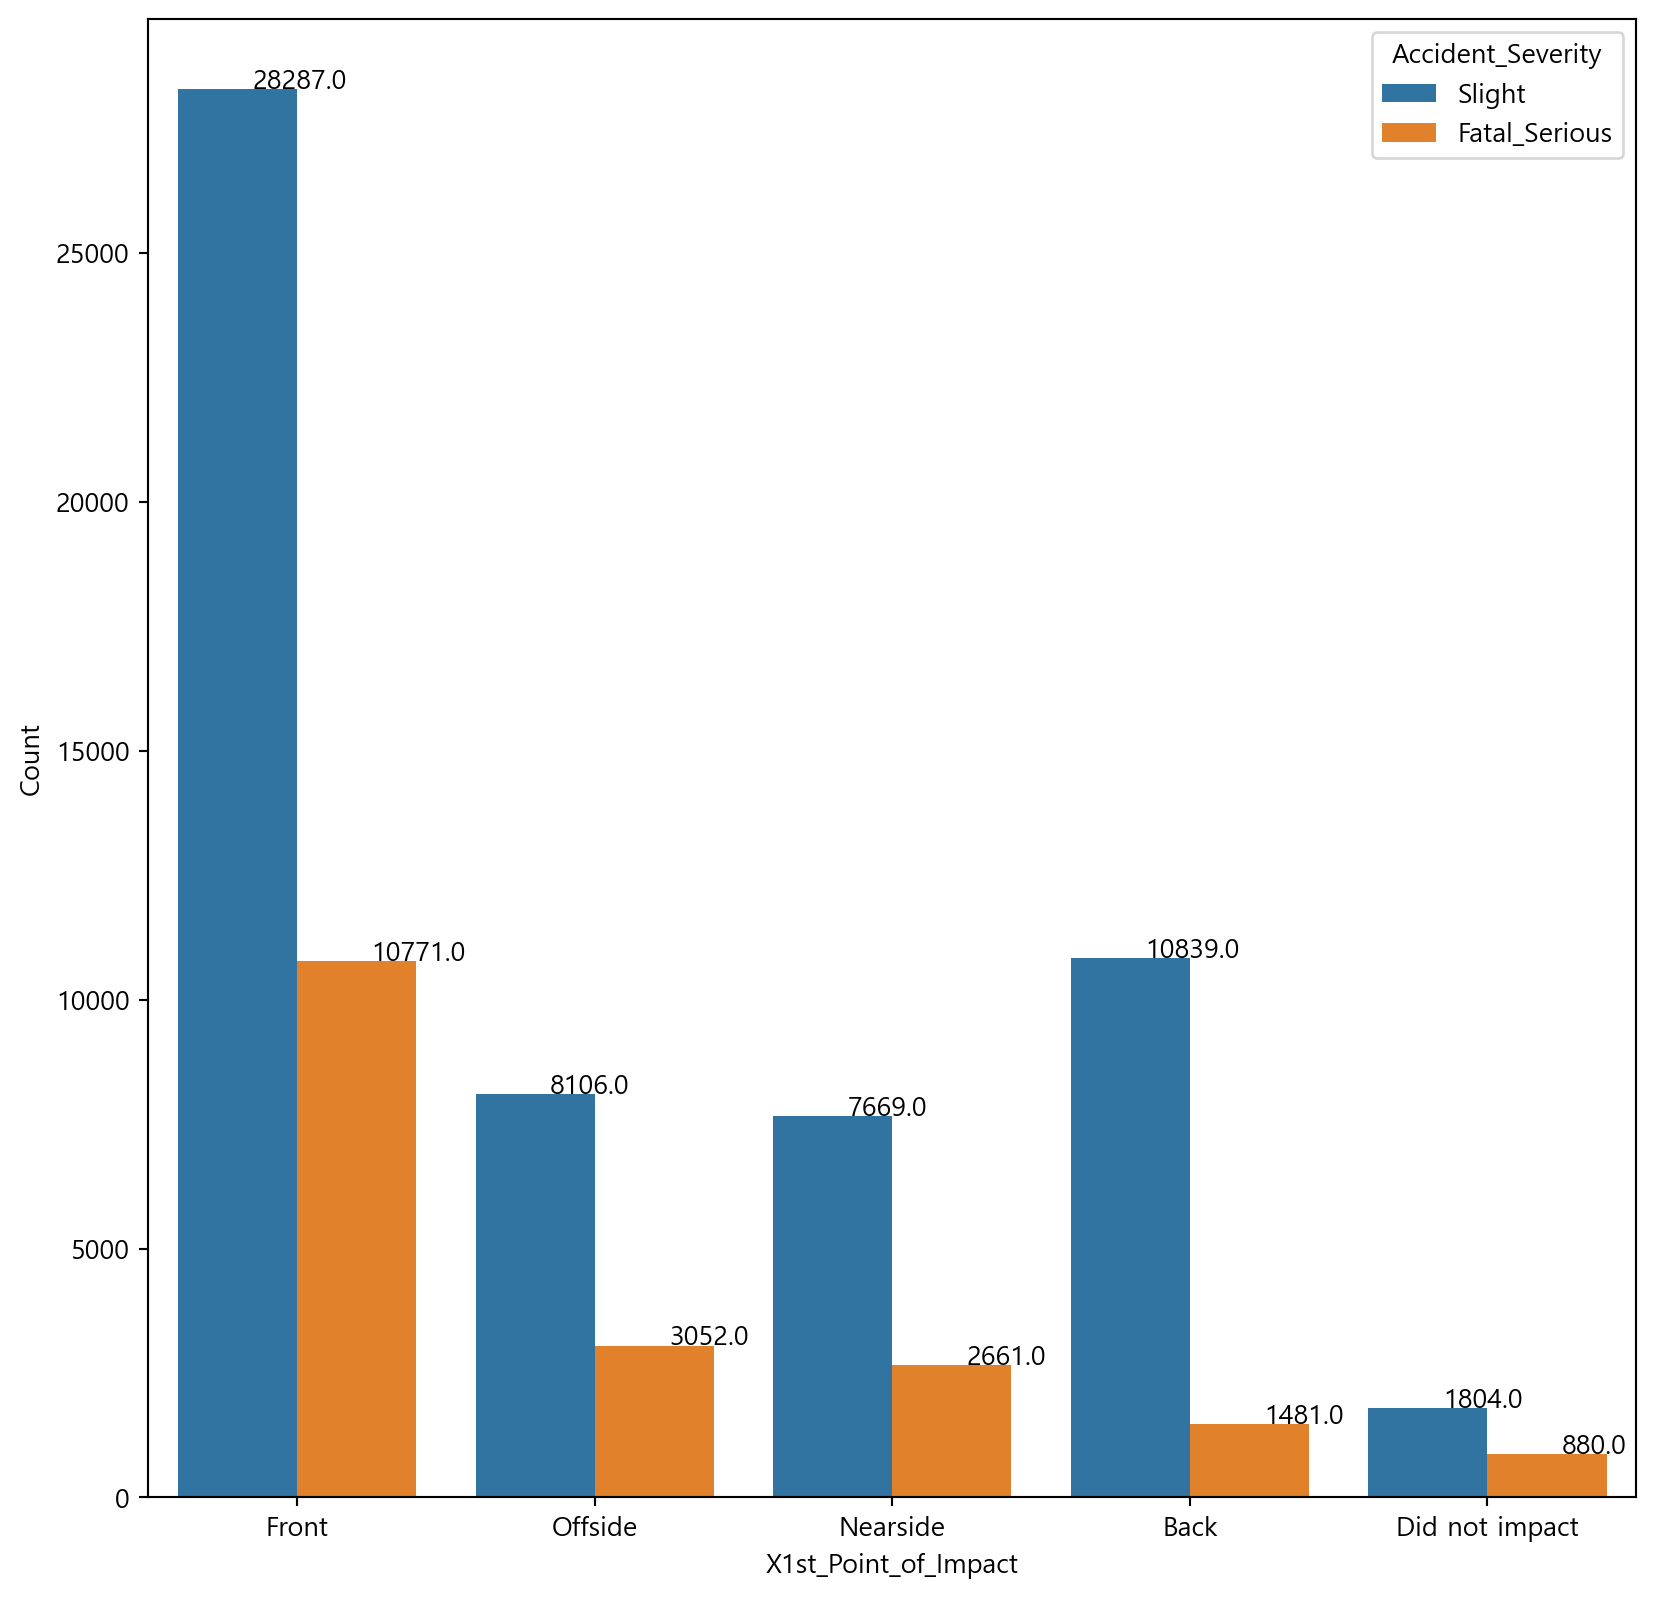

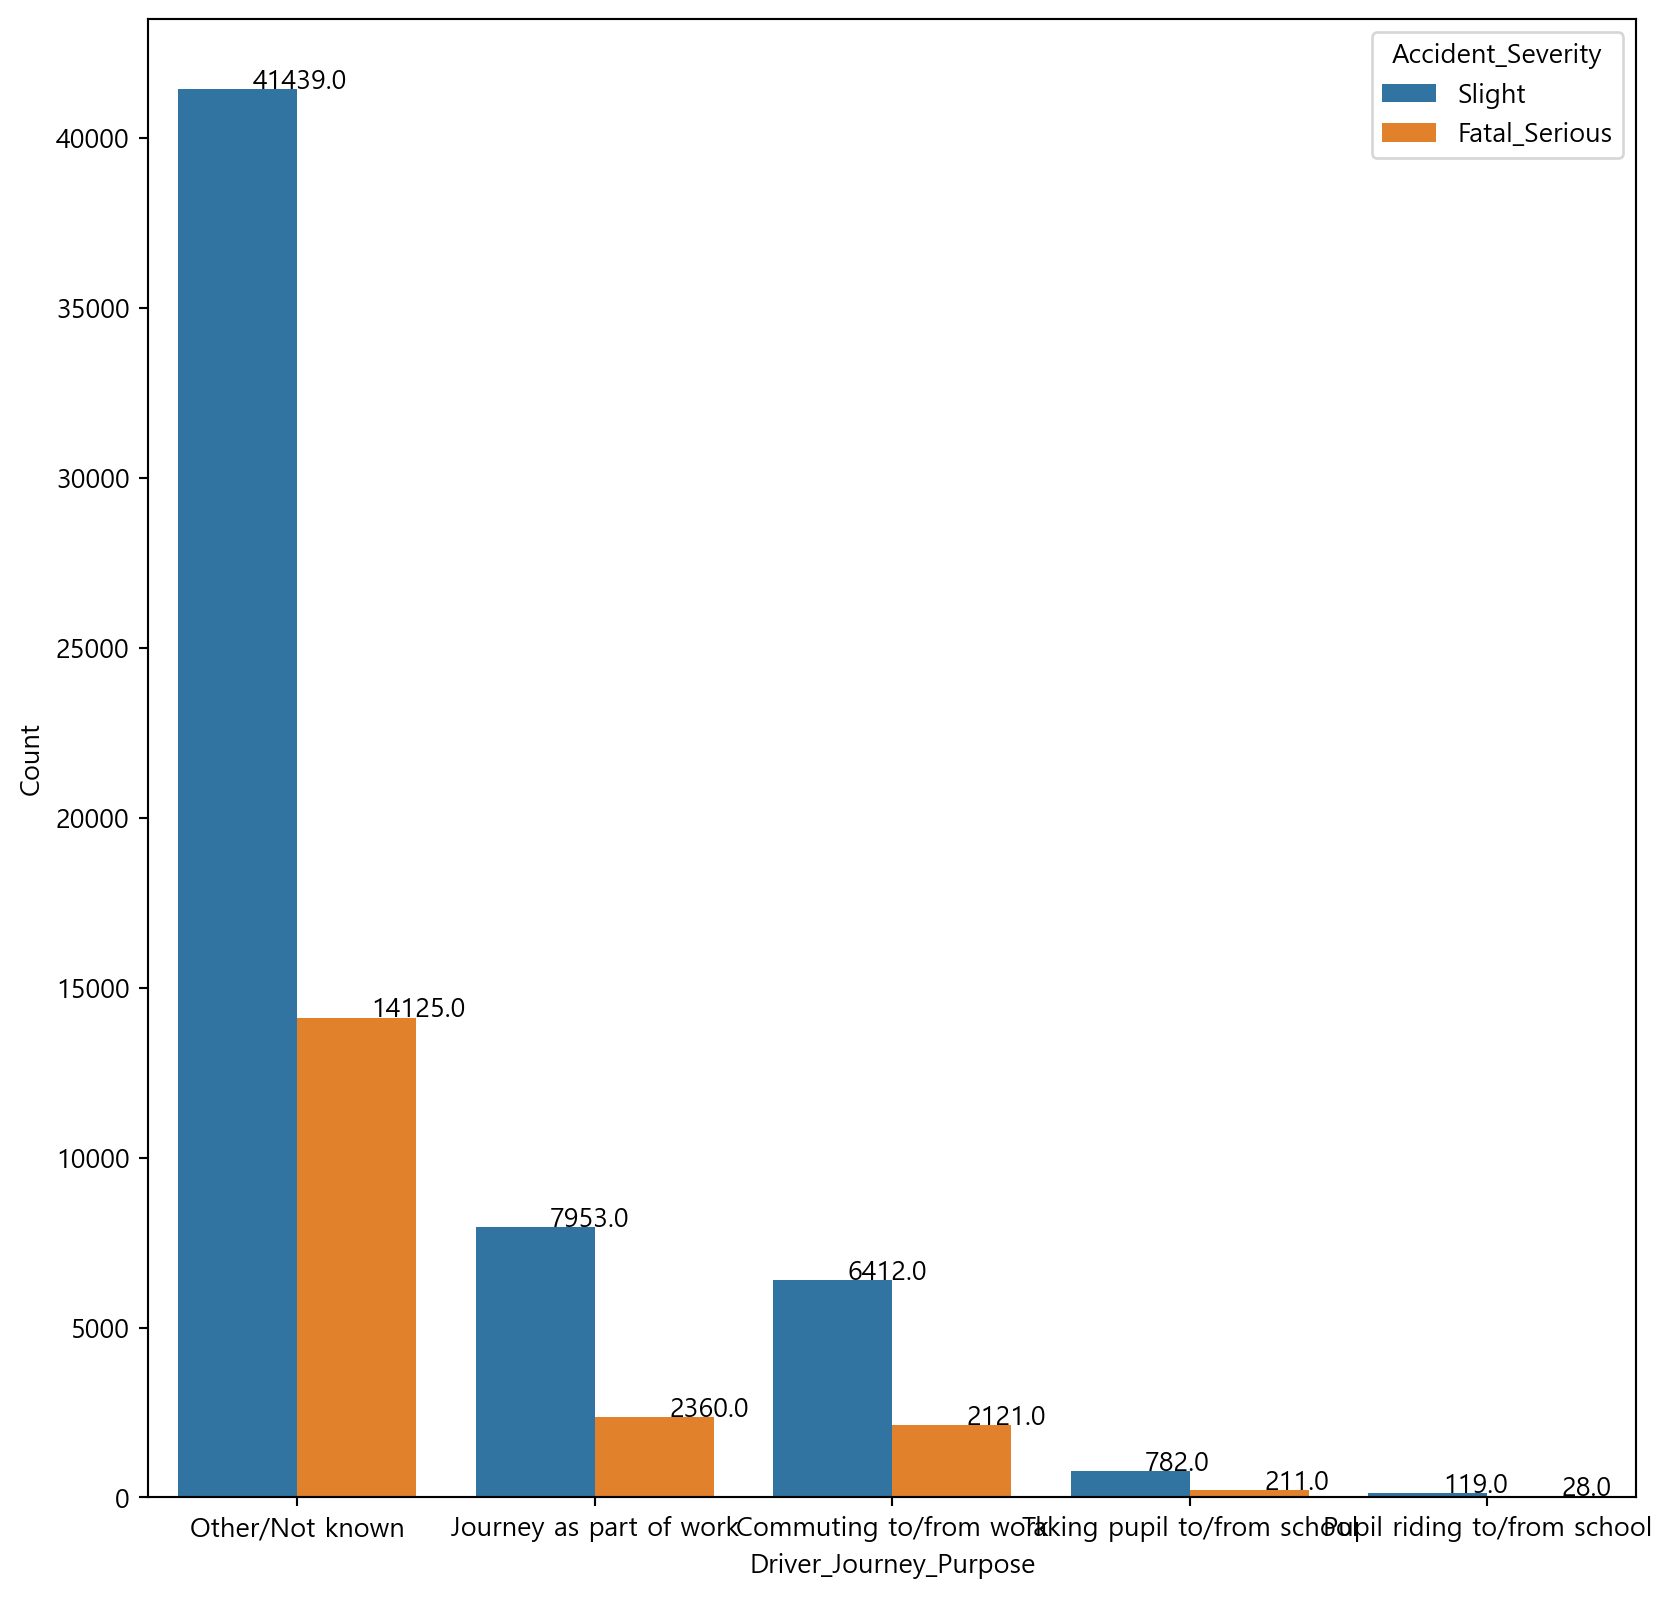

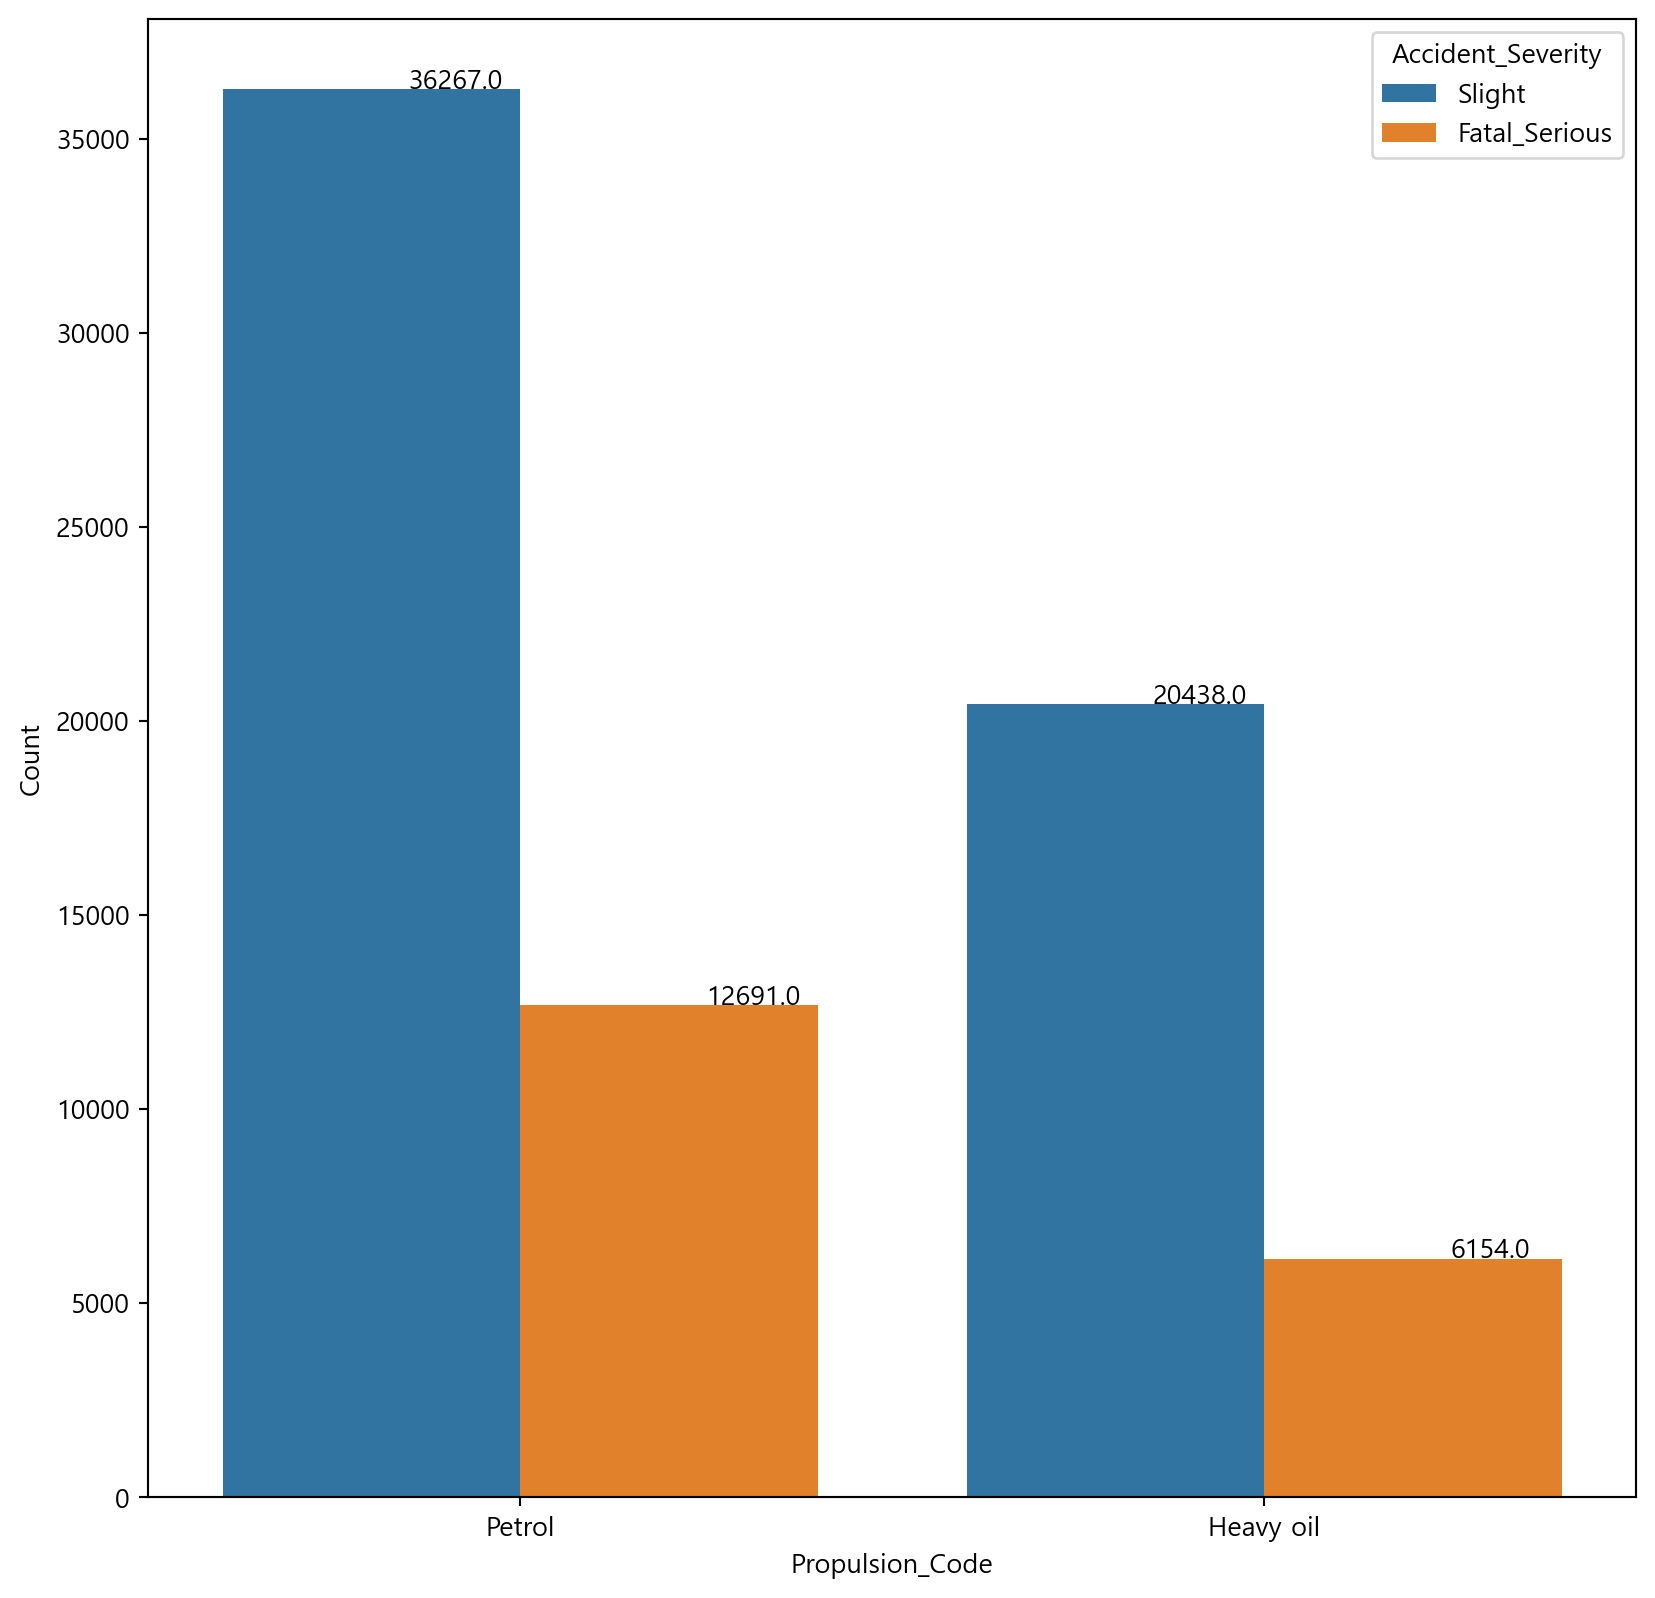

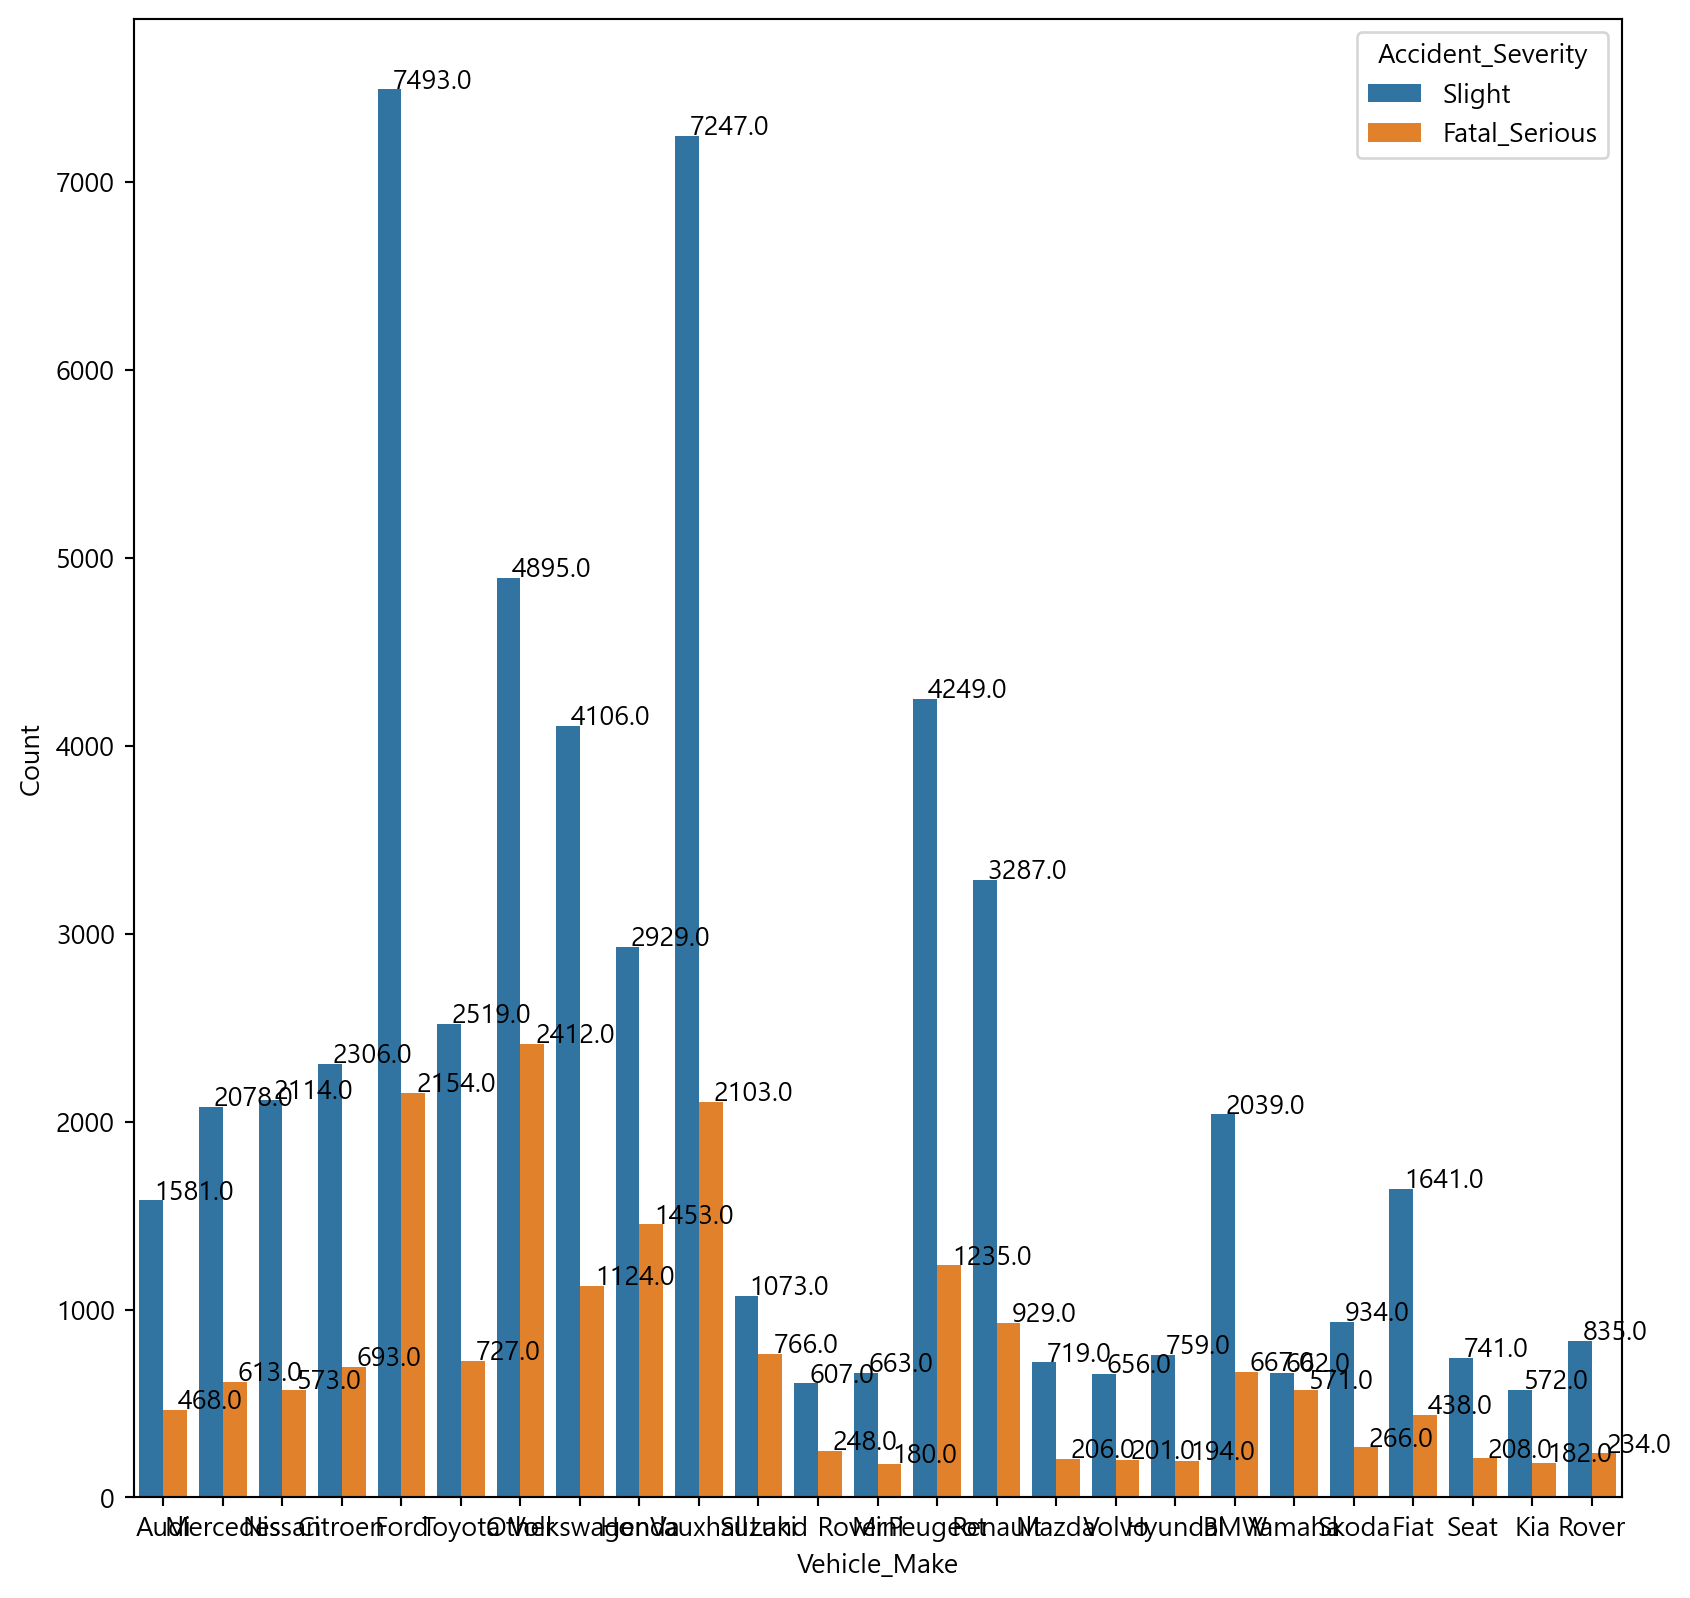

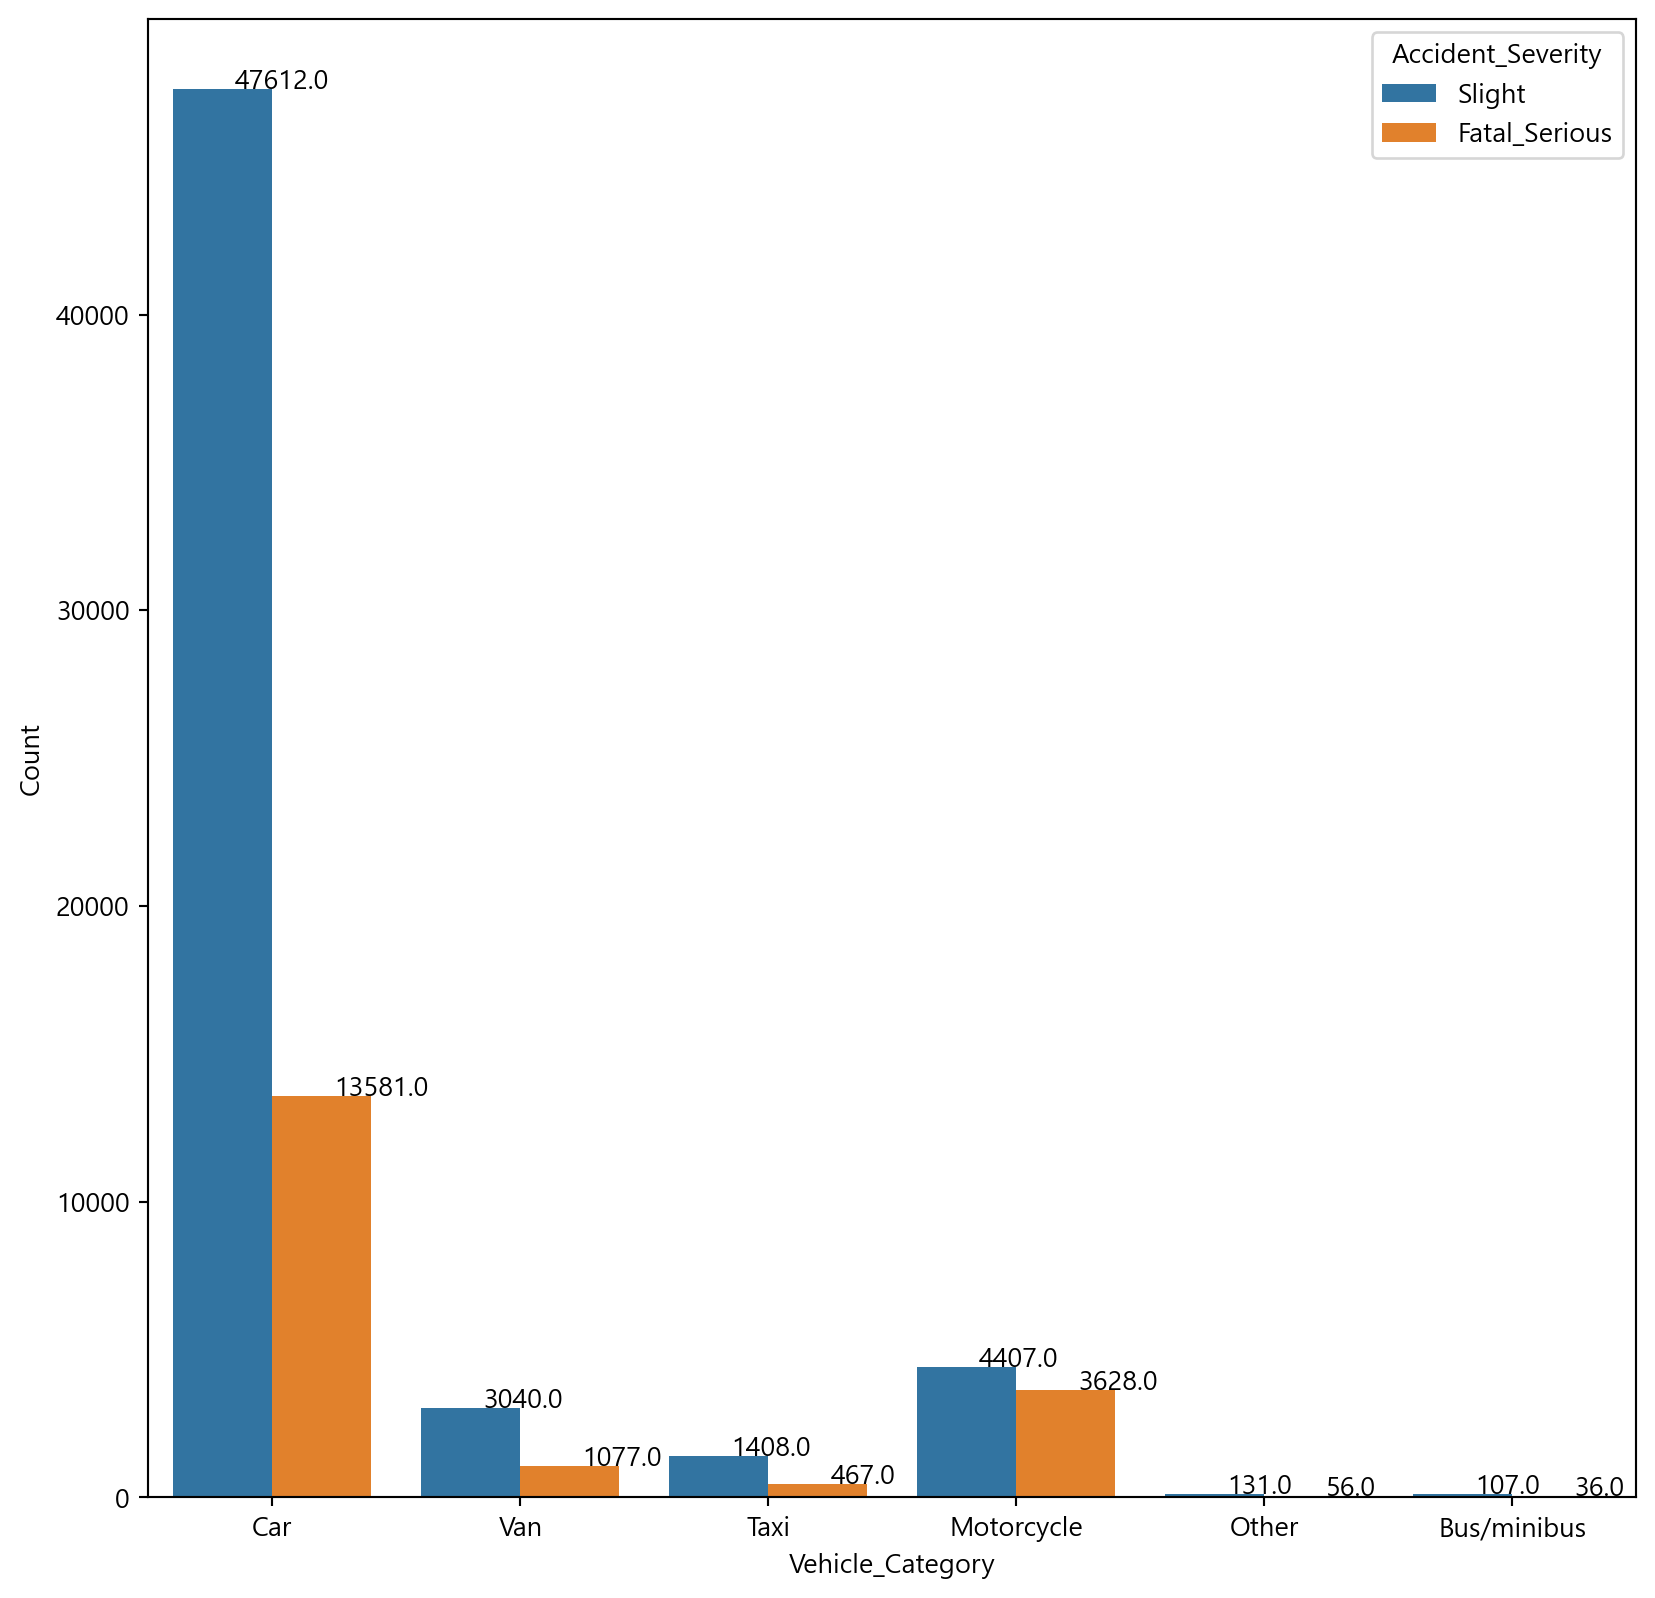

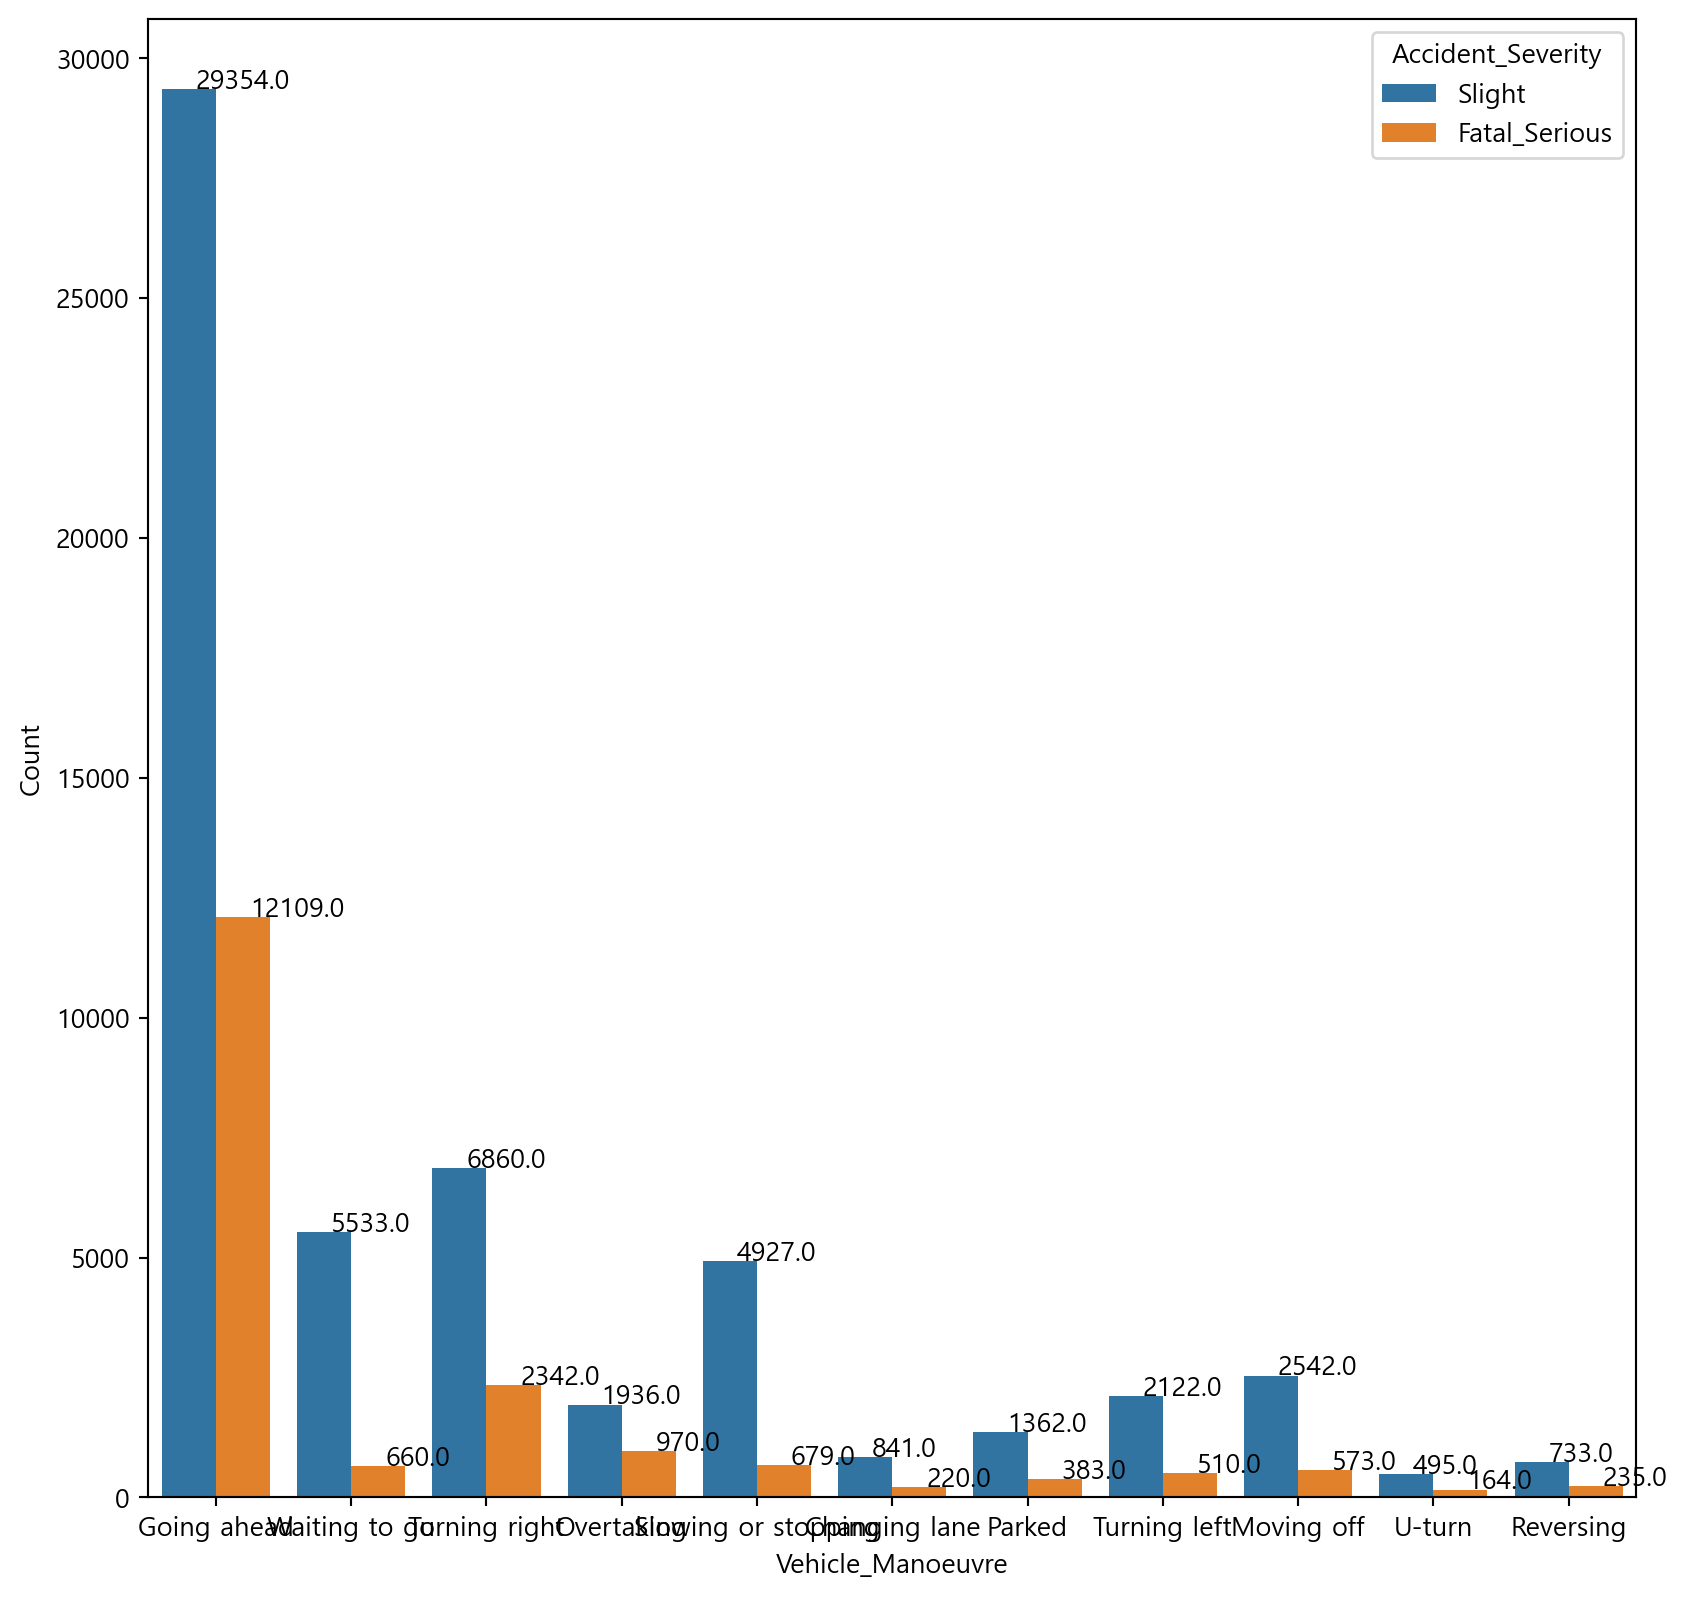

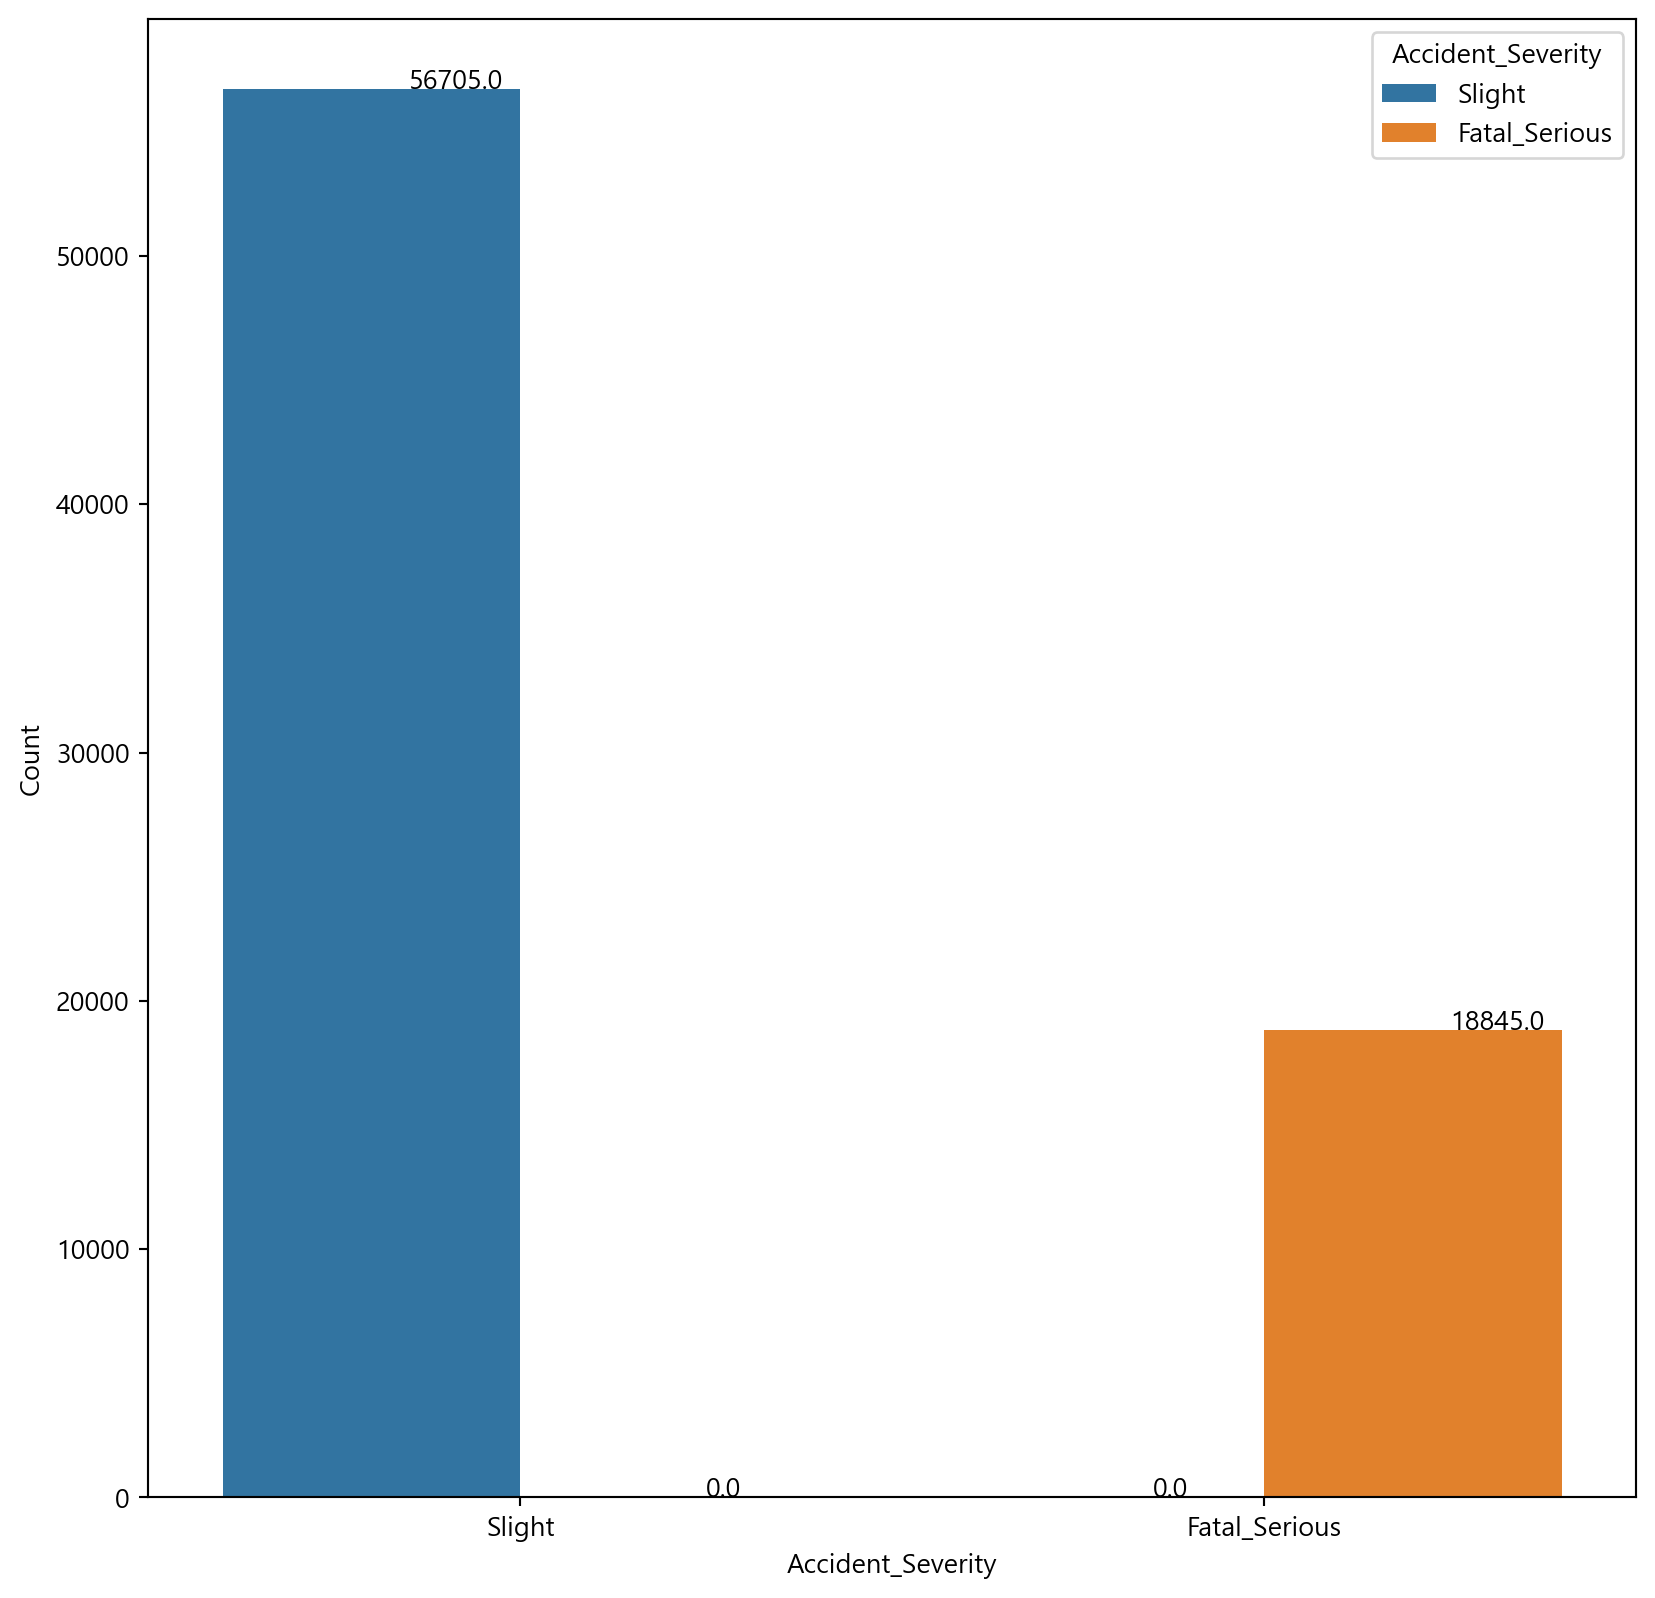

In [15]:
cat_data  = data.select_dtypes(exclude=[np.number])
for i in cat_data:  
  plt.figure(figsize=(10,10))# Creating an empty plot 
  ax=sns.countplot(x=cat_data[i],hue=data["Accident_Severity"])# Countplot of airlines
  plt.tick_params(labelsize=10)# changing the label sizes  
  plt.ylabel("Count" ,fontsize=10) #Adding y-label
  #plt.title("\n", cat_data.columns.values,"\n",fontsize=25) # Adding plot title
  for p in ax.patches:
      ax.annotate('{}'.format(p.get_height()),(p.get_x()+0.25,p.get_height()+5)) # Adding the count above the bars
  plt.show() 

### Look at the distribution of all numerical variables

Latitude


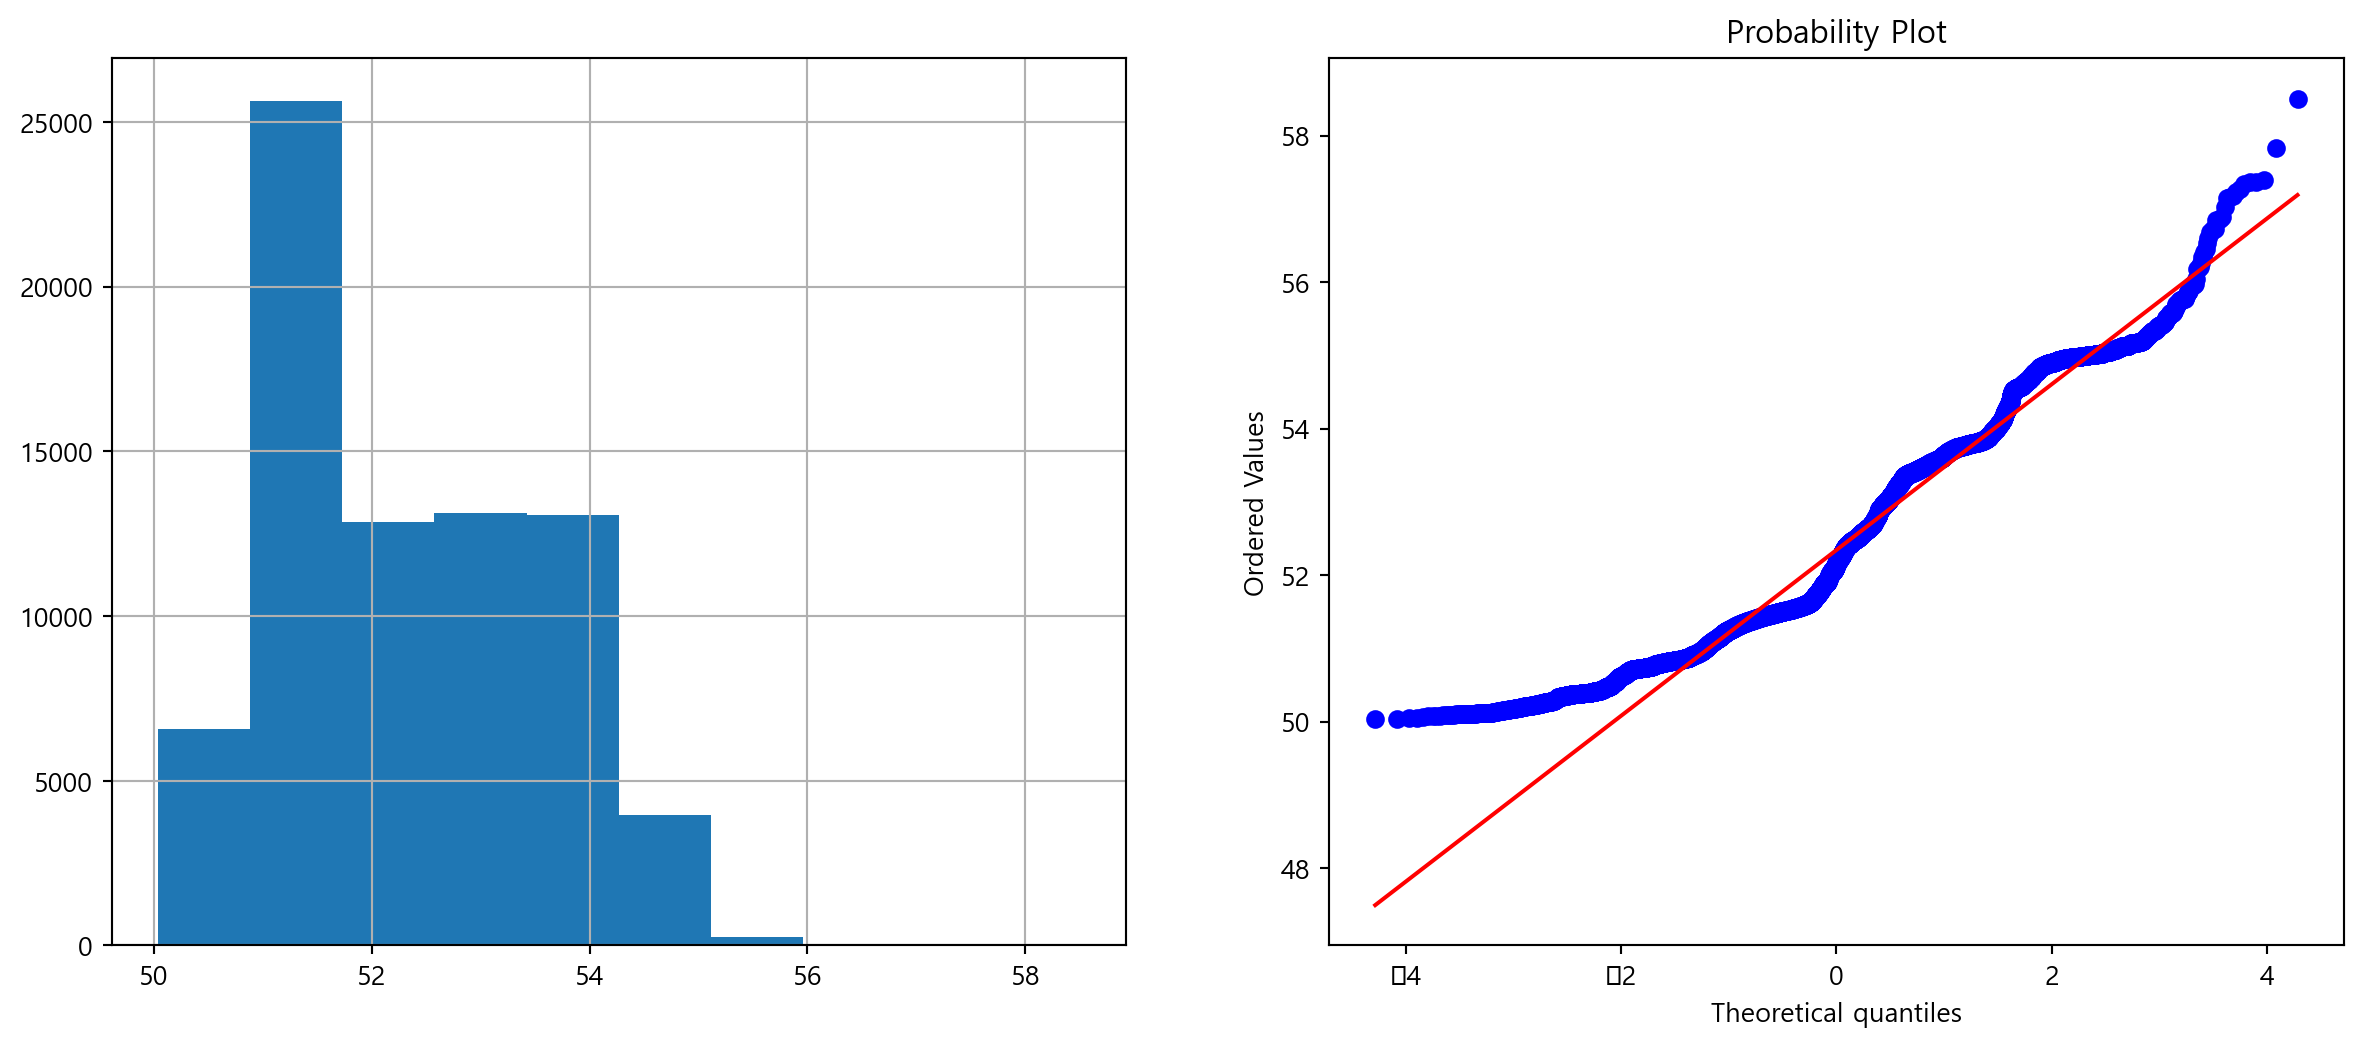

Longitude


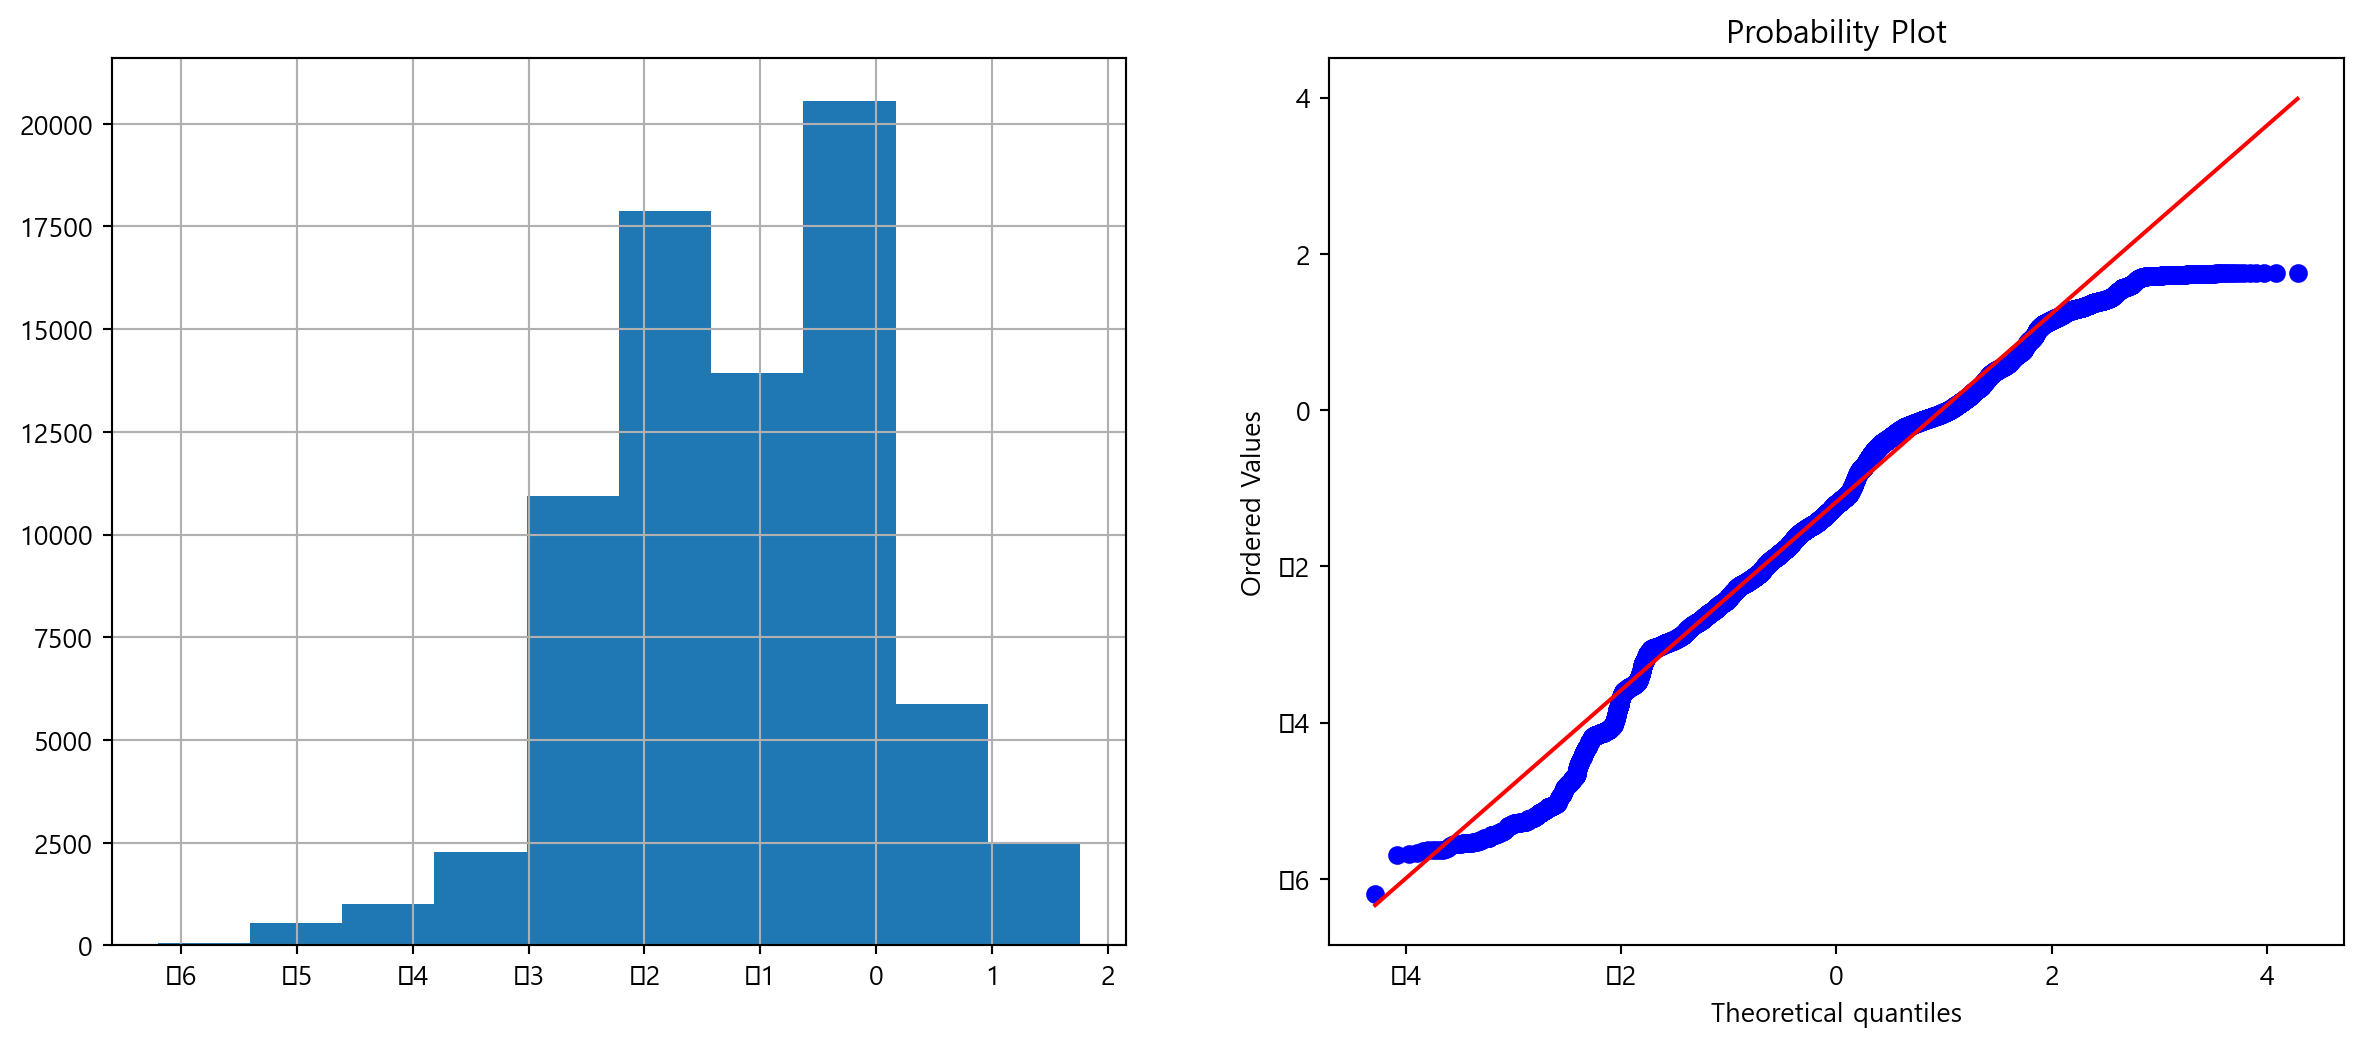

Driver_IMD_Decile


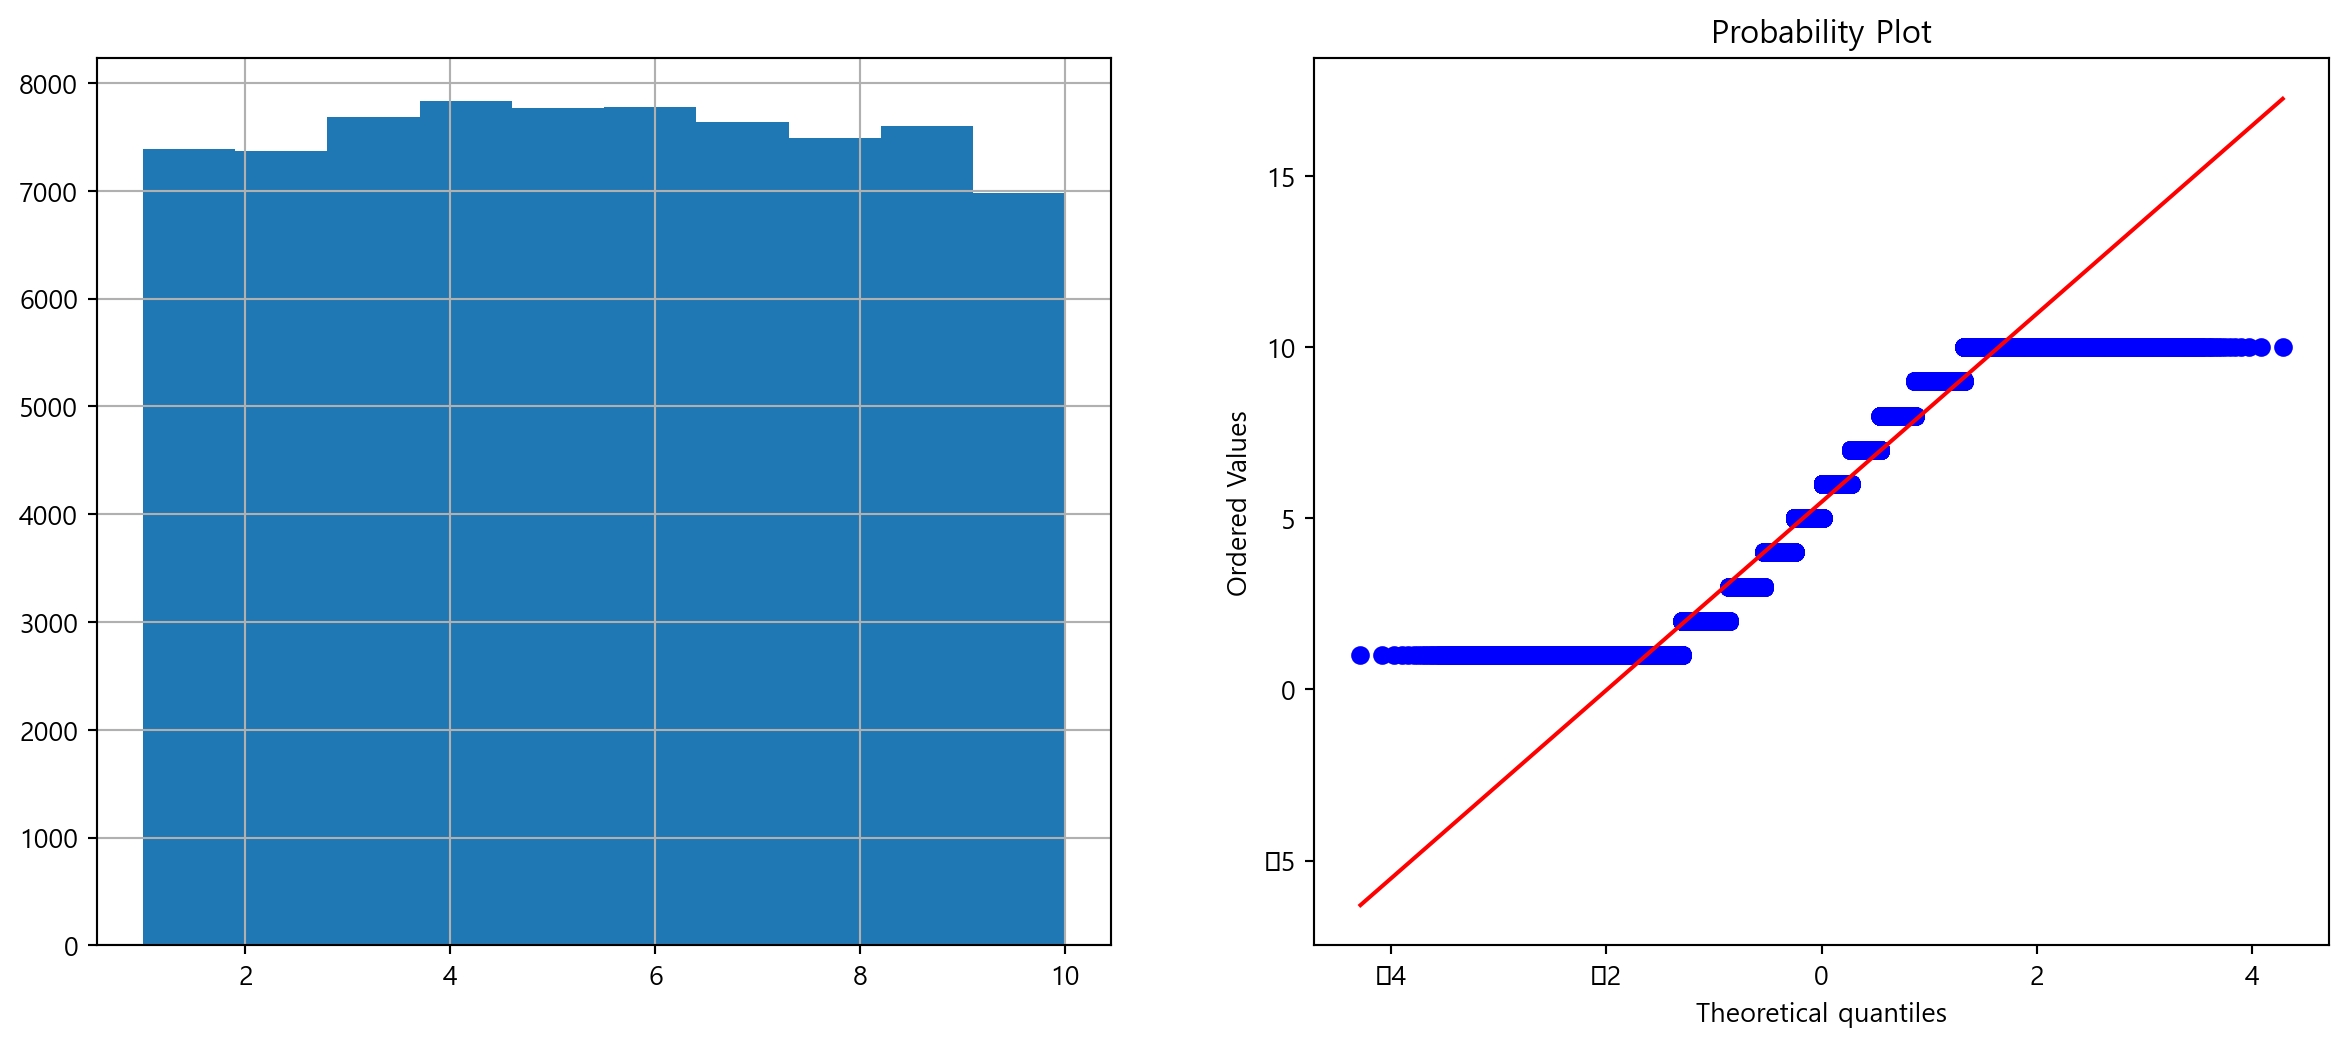

Speed_limit


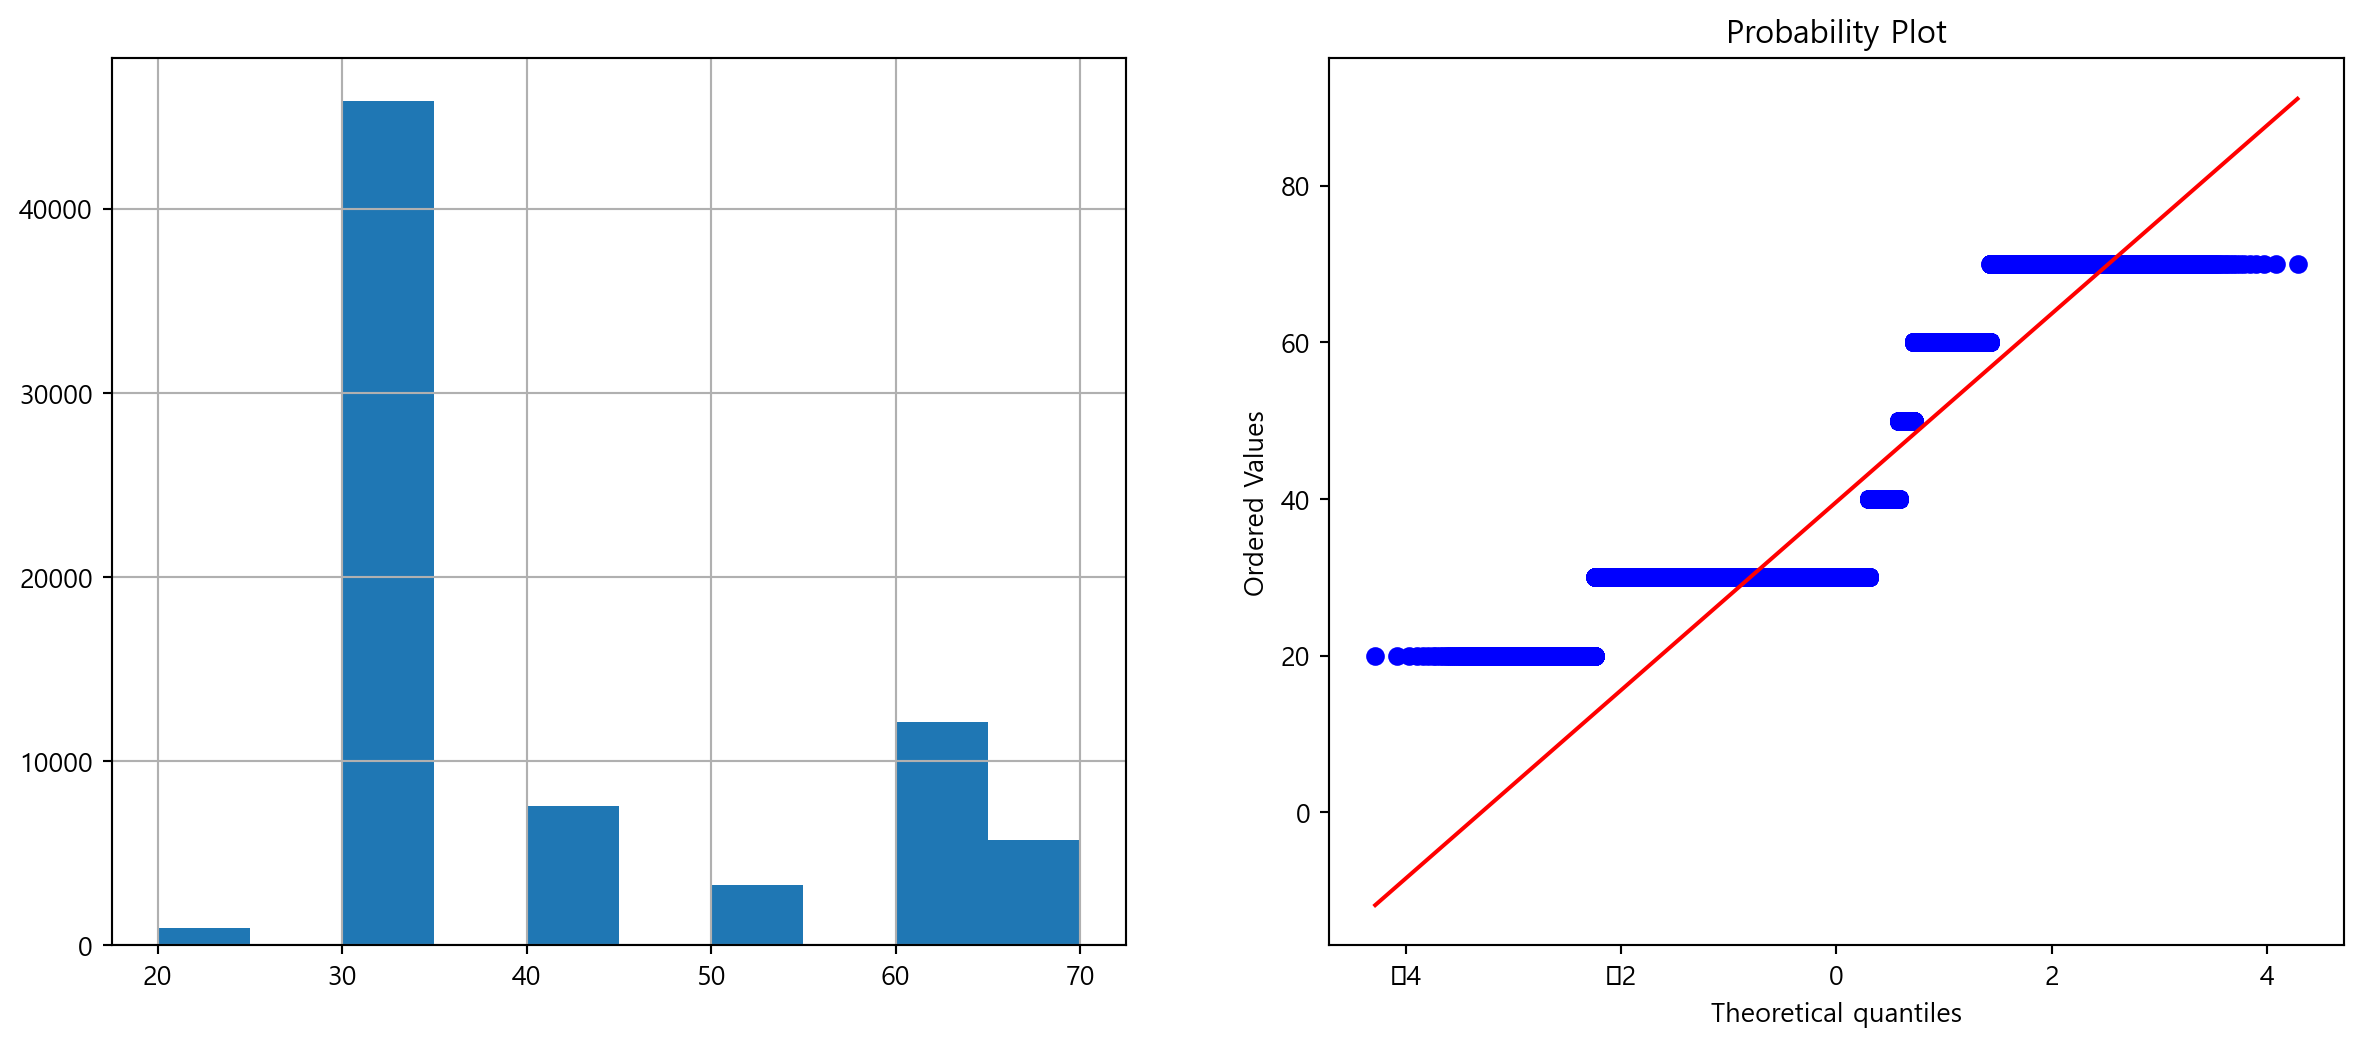

Day_of_Month


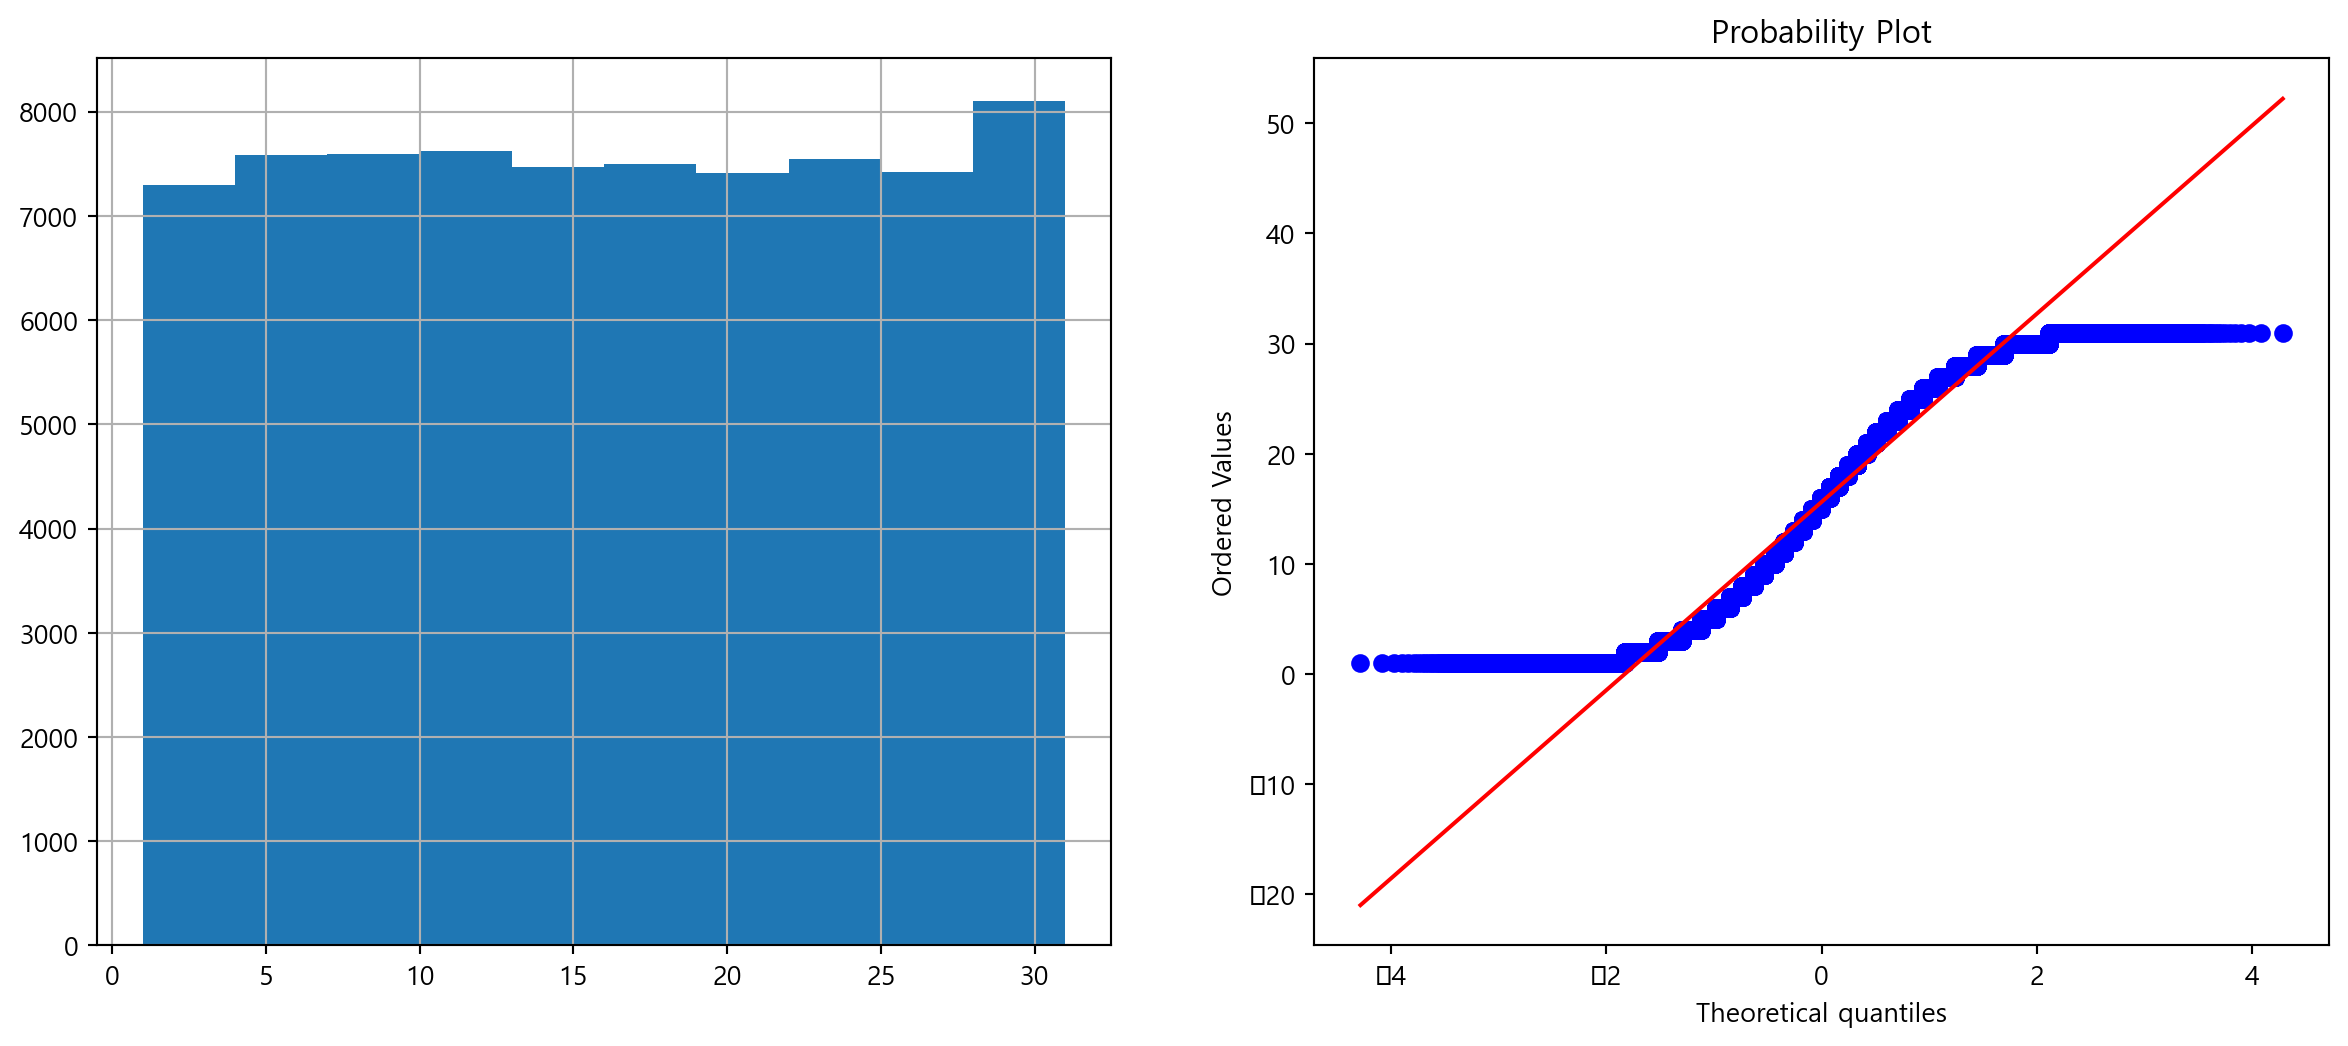

Hour_of_Day


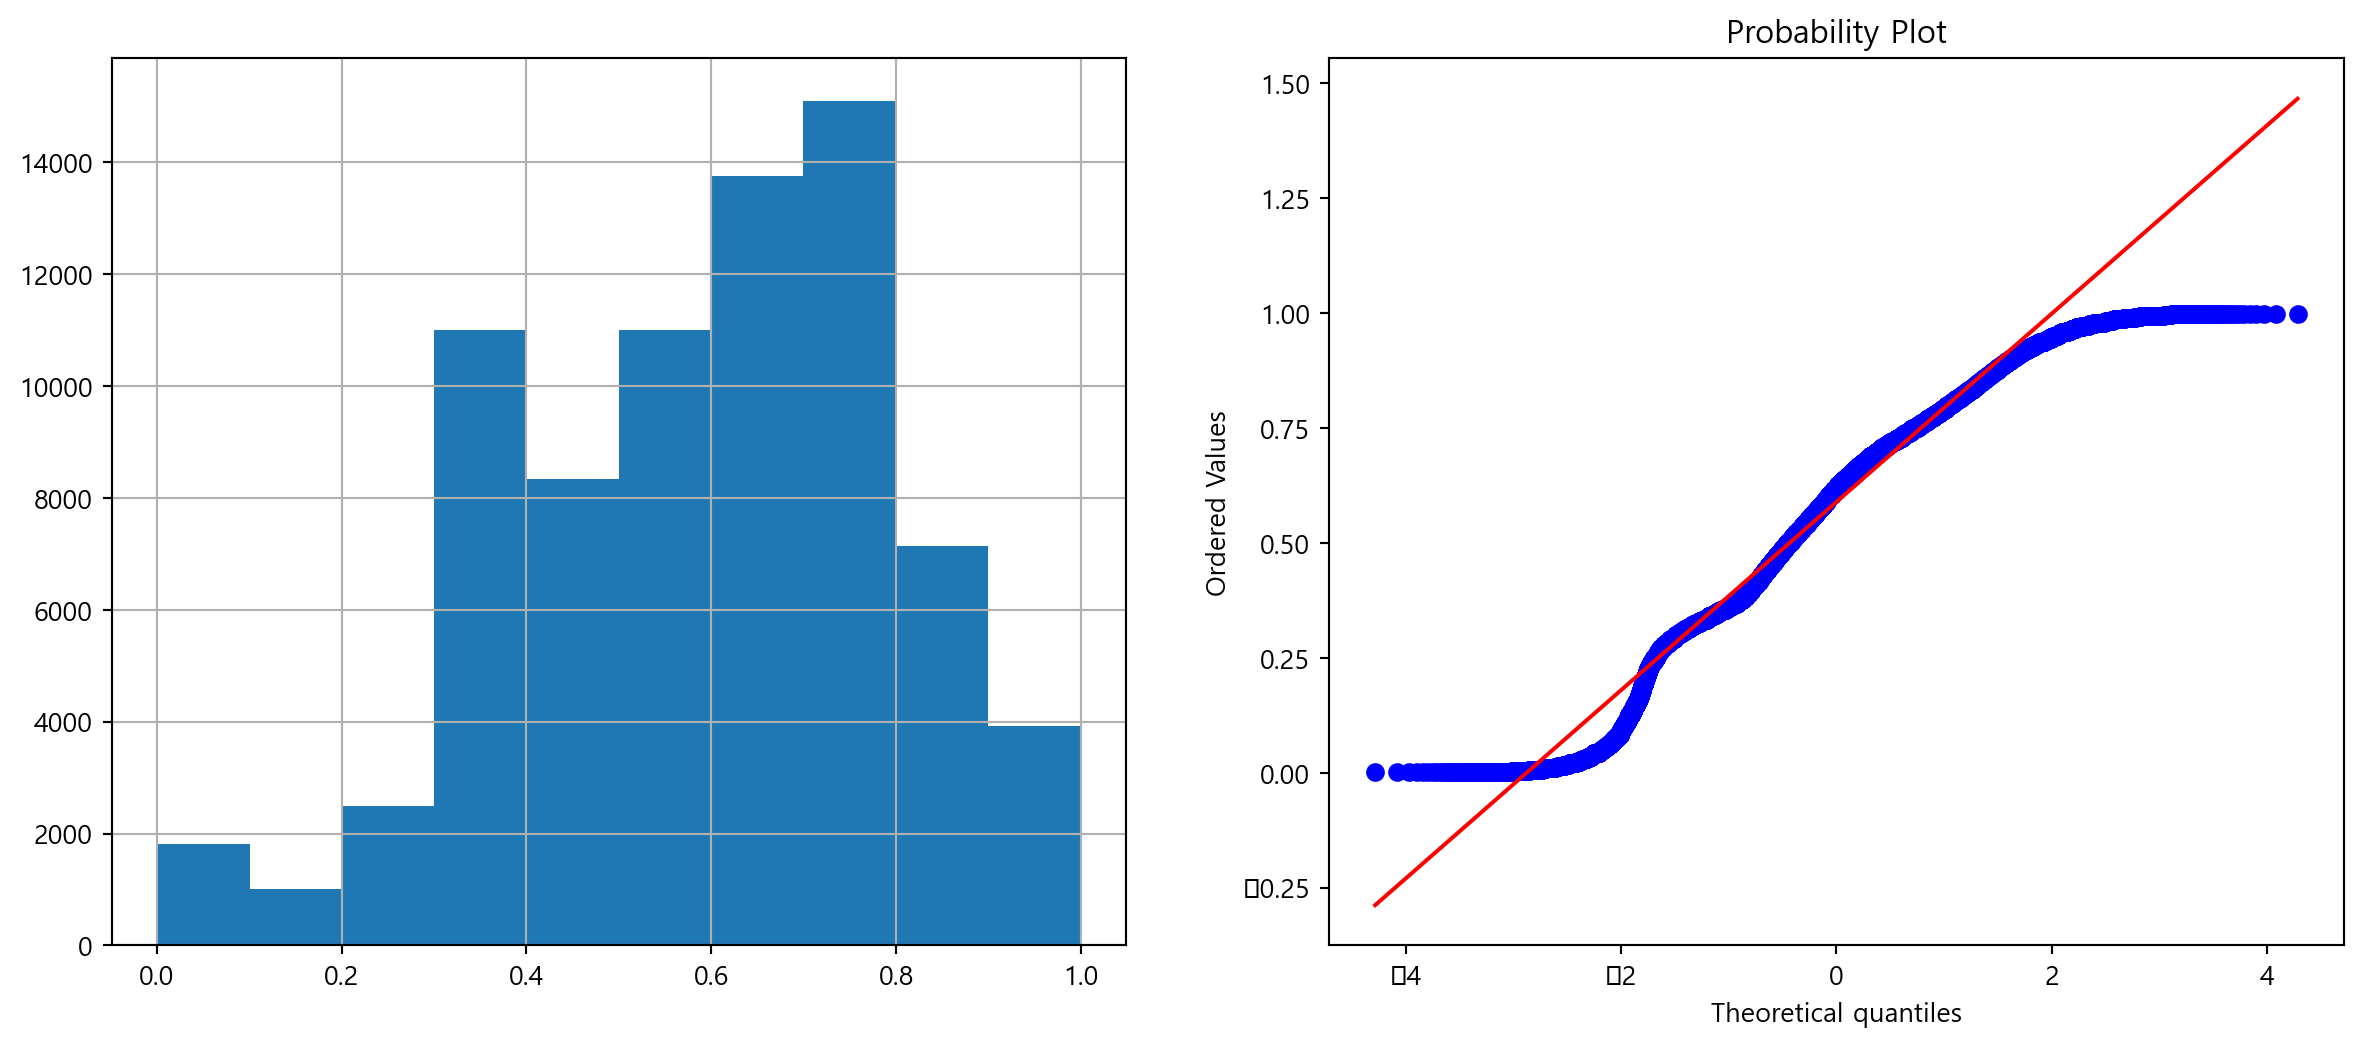

Age_of_Driver


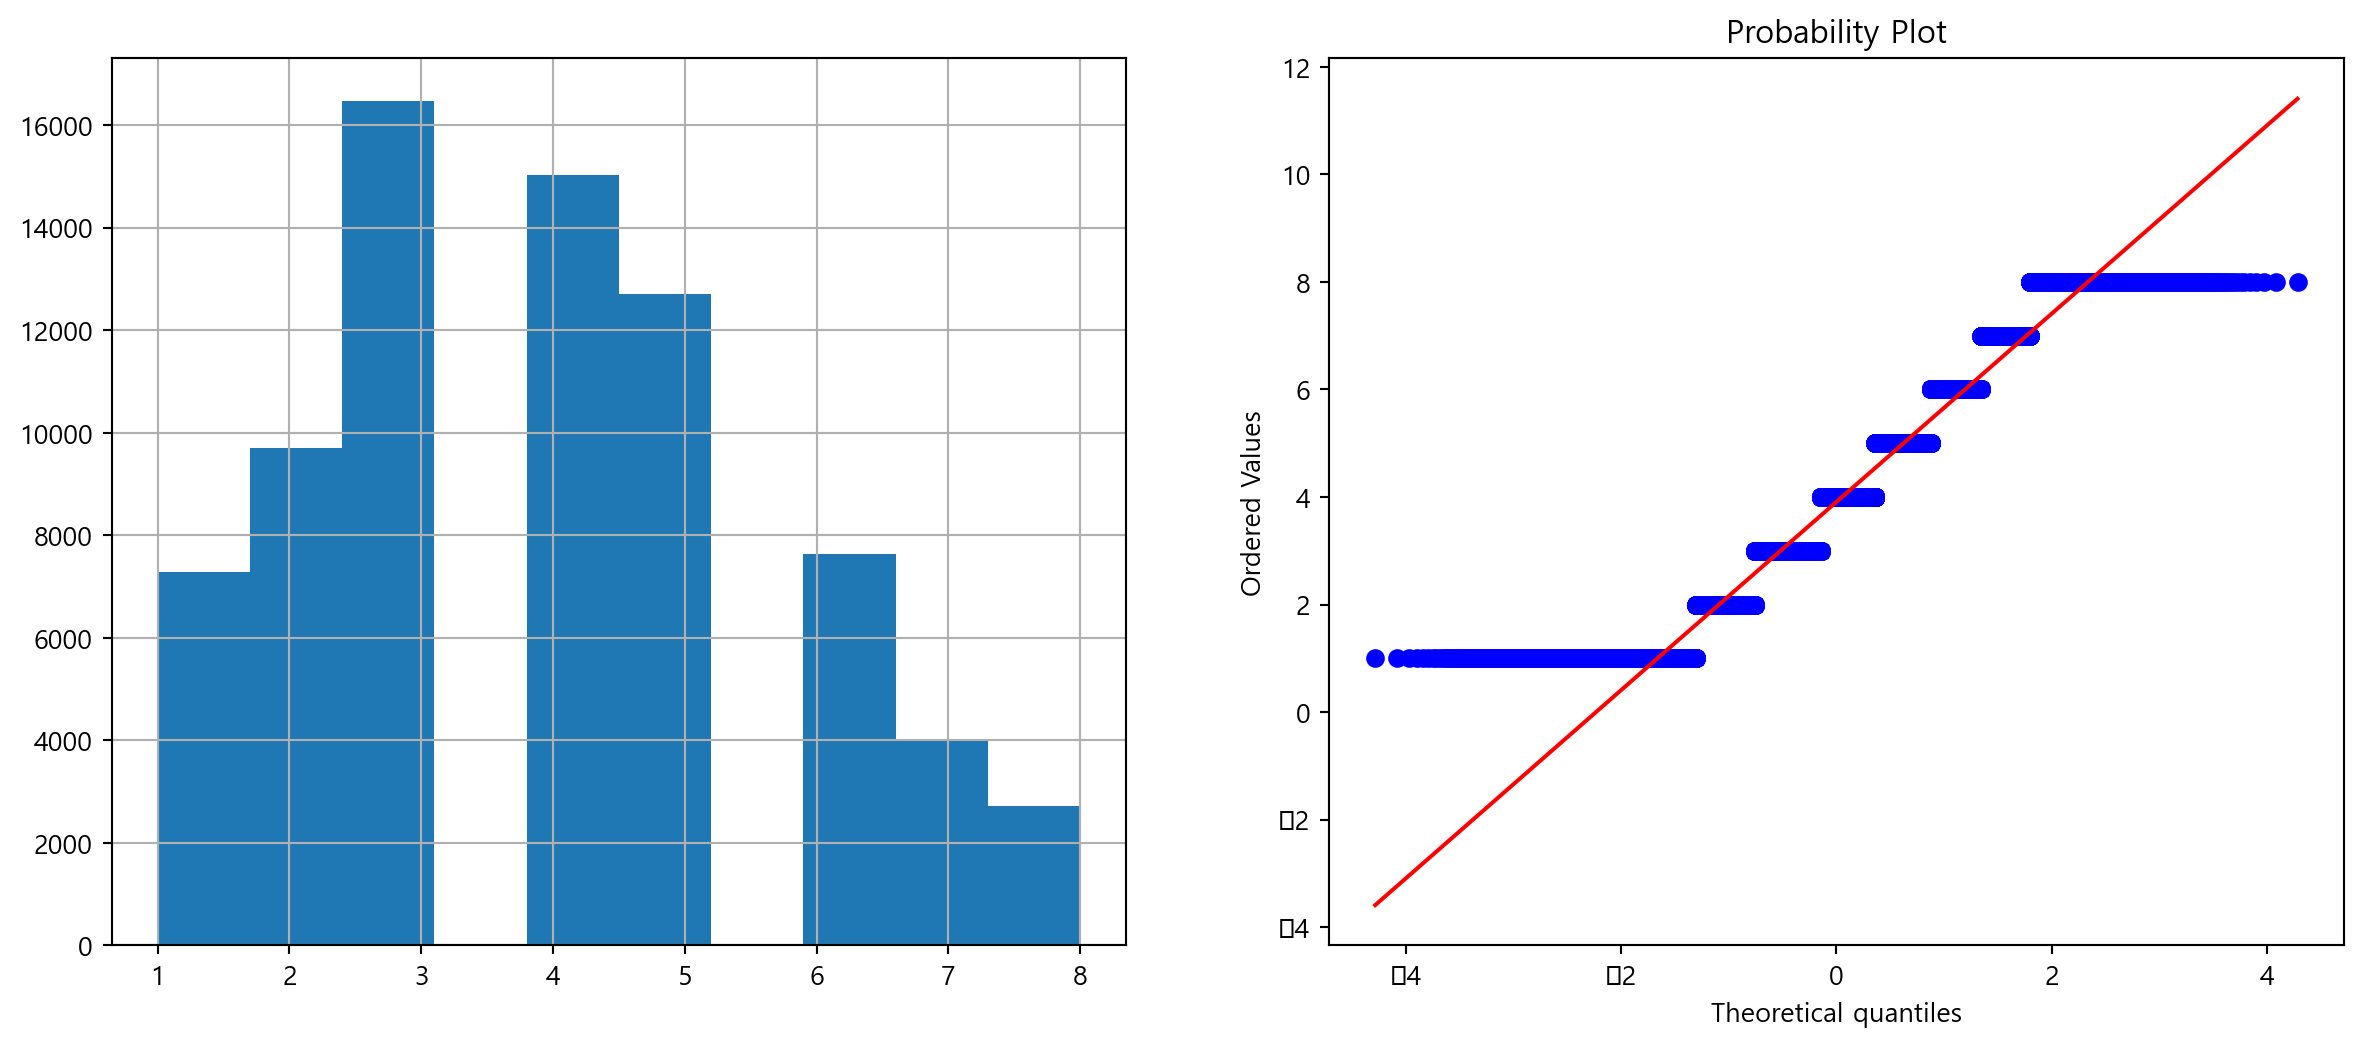

Age_of_Vehicle


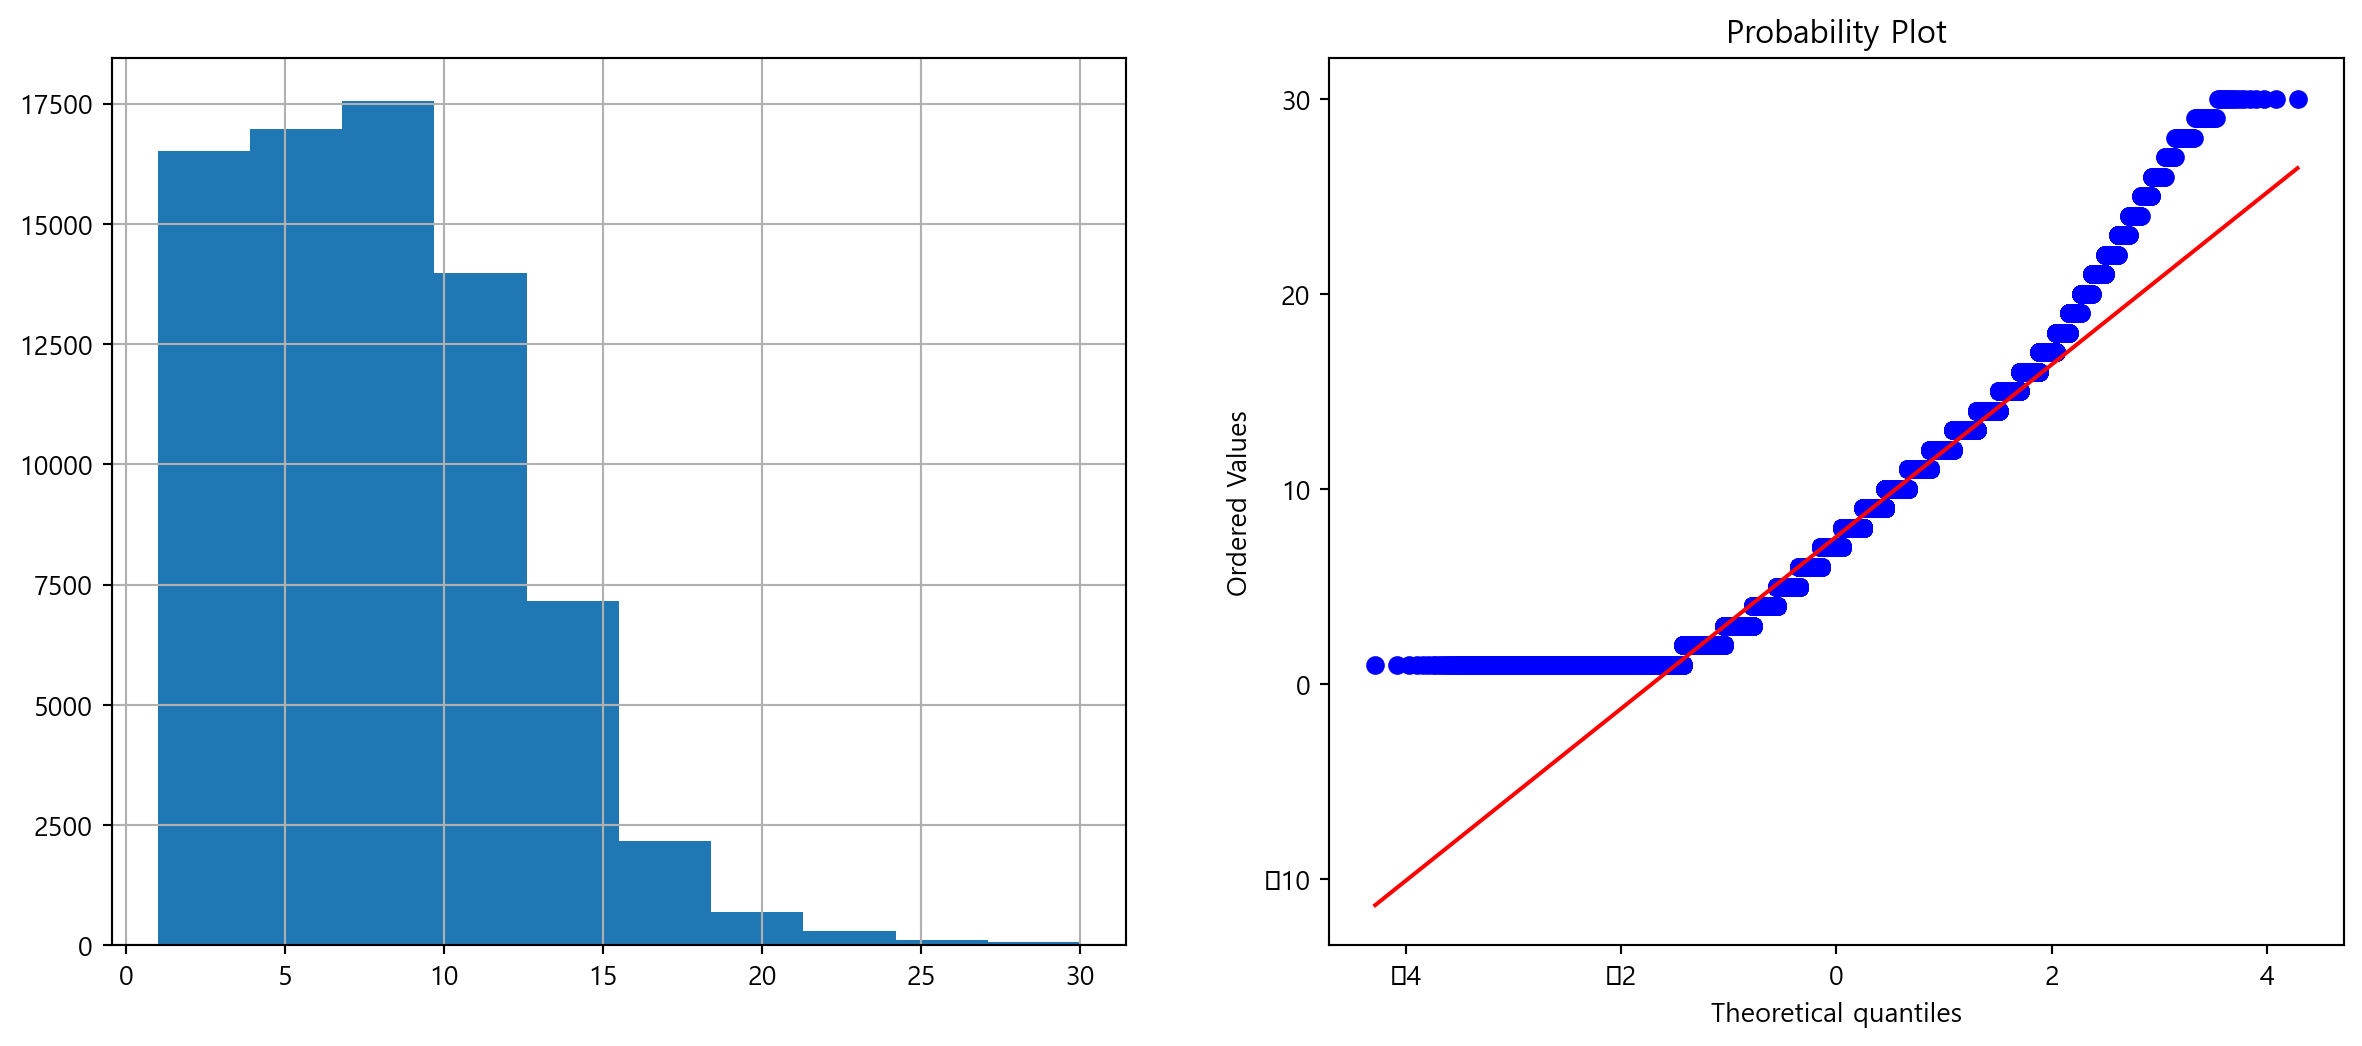

Engine_CC


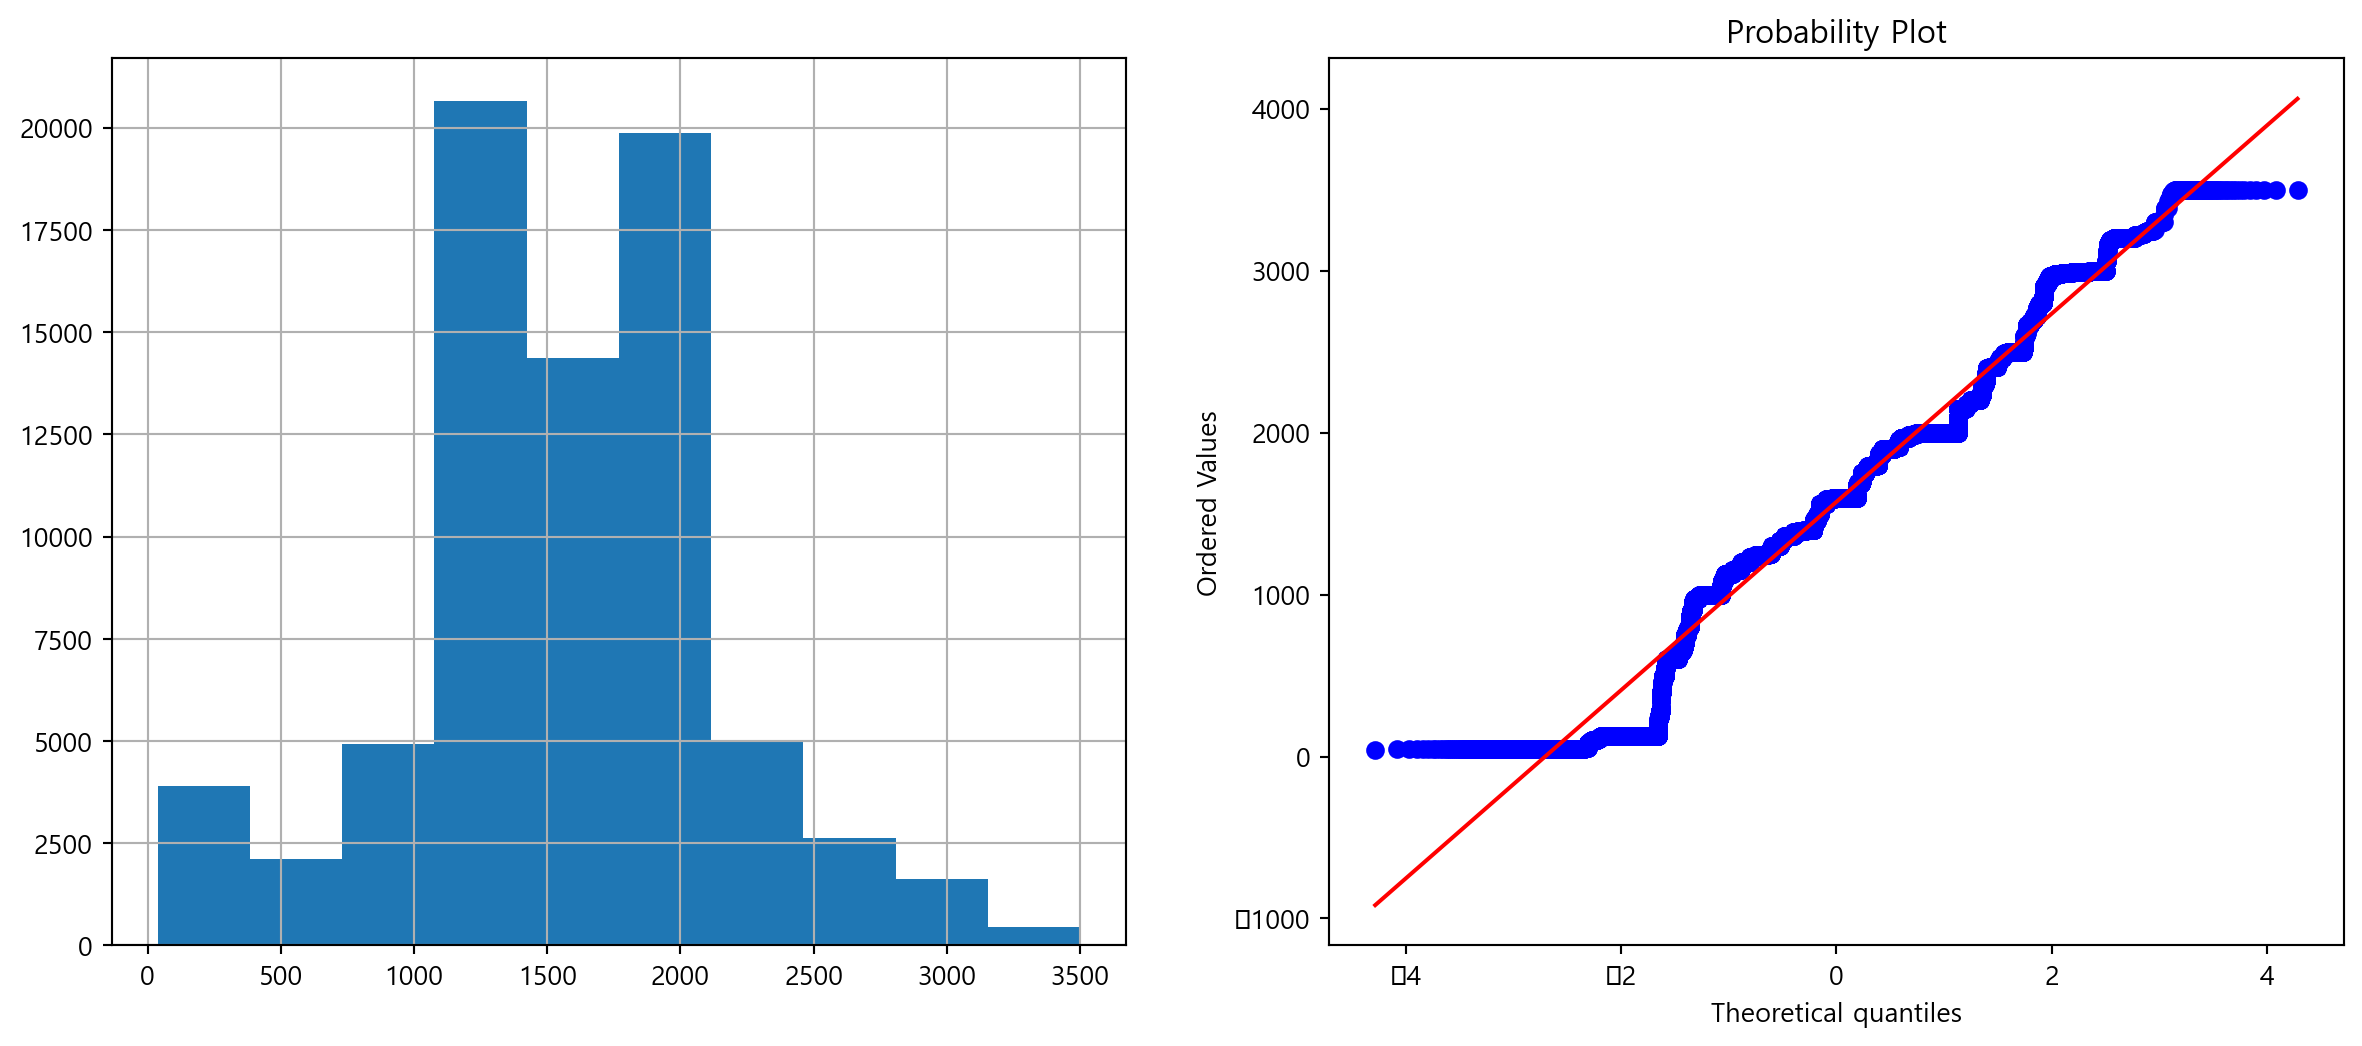

In [16]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    print(str(variable))
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
num_data  = data.select_dtypes(include=[np.number])
for i in num_data:
    diagnostic_plots(num_data, i) 

### Summary of the above distribution plots:
1. For some categorical variable, there are many ranks that have very low frequency. For example, only the 'fine' rank of the 'Weather' variable has significant count, hence the other ranks might be grouped into one for easy processing.
2. For some numerical variables, some features are not normally distributed. This would be taken care of in future analysis.  


### Look at the heatmap of the numerical variables

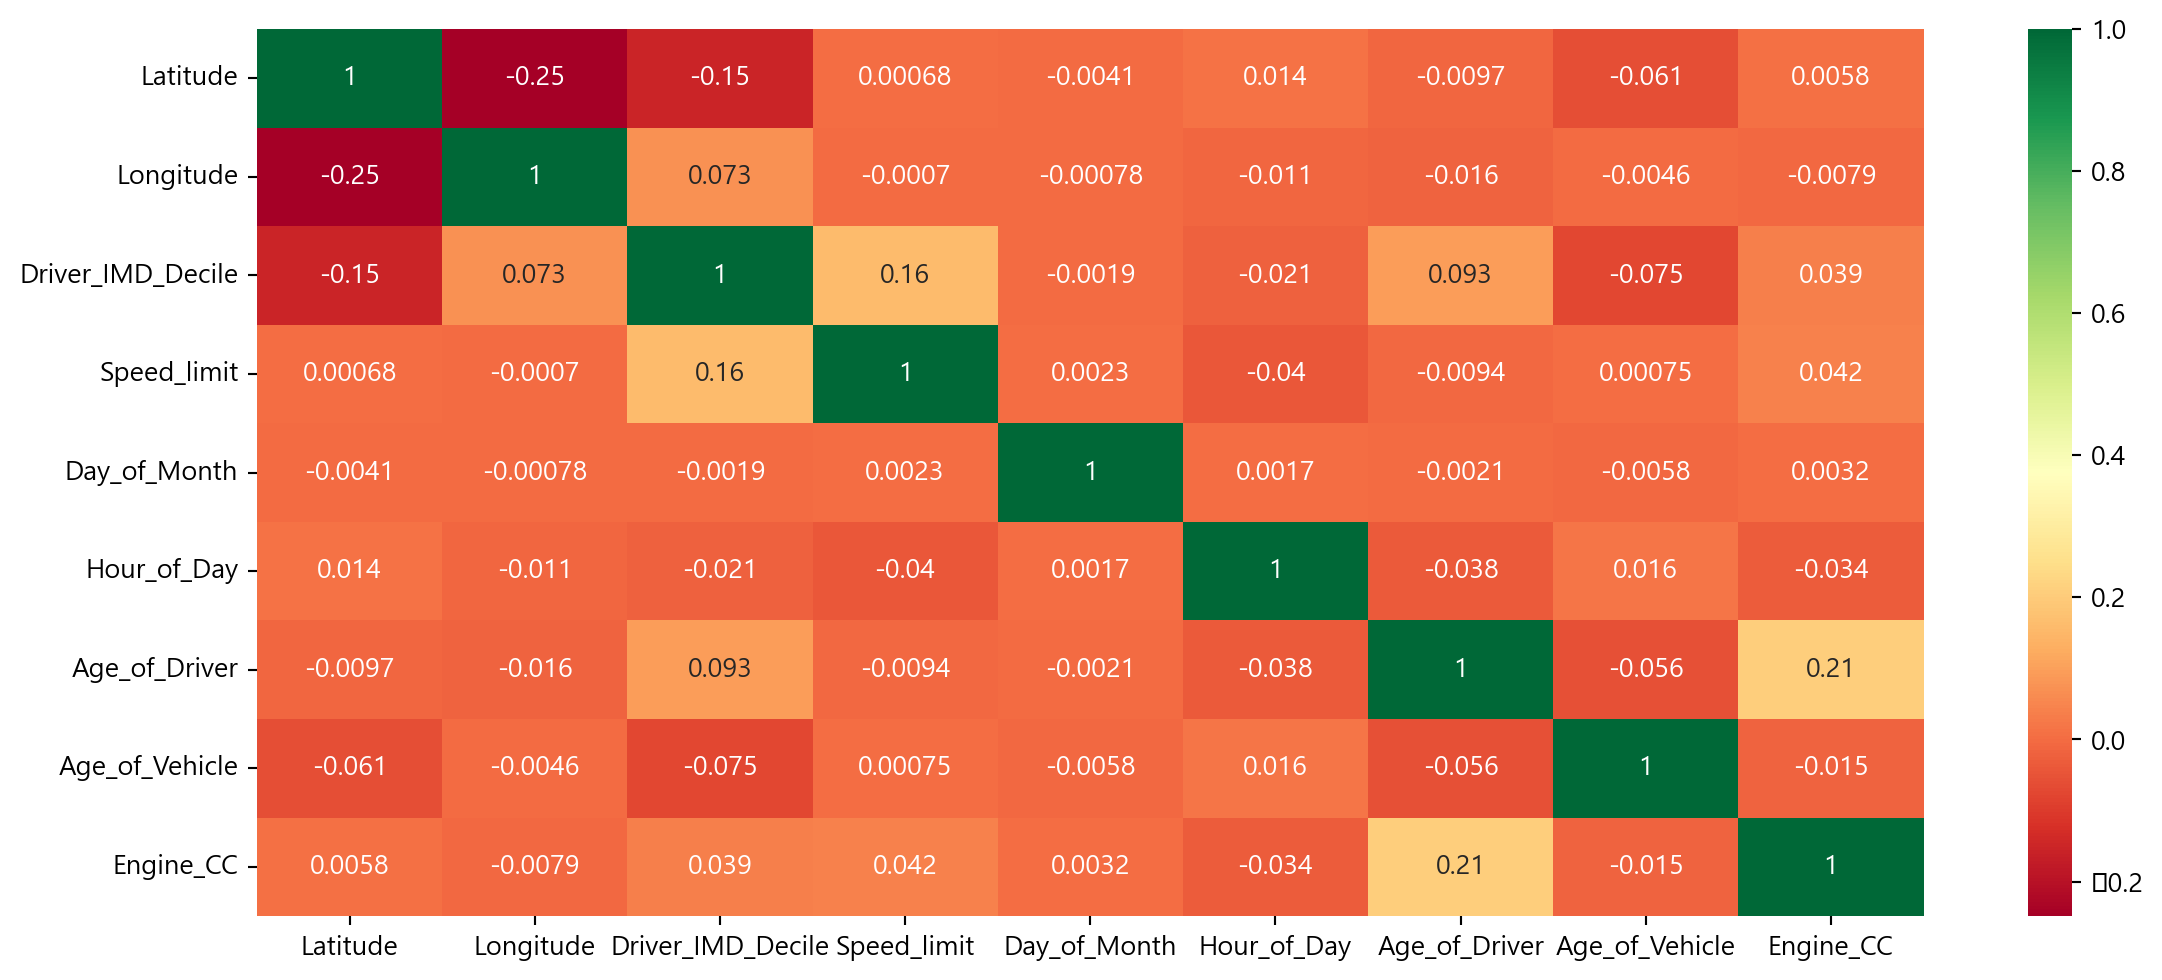

In [17]:
corrmat = data.select_dtypes(include=[np.number]).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(14,6))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### The above heatmap does not indicate any unusual correlation. 